In [3]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode
from scipy import interpolate
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [327]:
# parameters
δ = 0.01
η = 0.032
ξₐ = 1/4000
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ/10
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [162]:
# def func
def solve_smooth(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξ = args
    dy = y_grid[1] - y_grid[0]
    n_y = len(y_grid)
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
    ϕ = - δ*η*y_grid**2
    ems = δ*η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy)
        dϕdyy = derivative_1d(ϕ, 2, dy)
        temp = dϕdy + (η-1)*dΛ
        # update belief
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = dϕdyy*σy**2 - 1/ξ*temp**2*σy**2
        b = (θ_list@π)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
#         C = np.zeros(y_grid.shape)
        C = ems**2*σy**2/2
        D = δ*η*np.log(ems) + (θ_list@π)*(η-1)*dΛ*ems + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
        - 1/(2*ξ)*temp**2*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    h = - temp*ems*σy/ξ
    return ϕ, ems, π, h

In [163]:
# no ambguity
def solve_base(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ, σy, γ1, γ2, γ3, ȳ = args
    hy = y_grid[1] - y_grid[0]
    # initialize the while loop
    episode = 0
    lhs_error = 1
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ϕ =  - δ*η*y_grid**2
    ems = - δ*η/((η-1)*dΛ*θ)
    ems_old = ems
    h_star = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy)
        dϕdyy = derivative_1d(ϕ, 2, hy)
        temp = dϕdy + (η-1)*dΛ
        a = dϕdyy*σy**2  
        b = temp*θ
        c = δ*η
        Δ = b**2 - 4*a*c
        ems_new = (-b - np.sqrt(Δ))/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15    
        ems = ems_new*1 + ems_old*0
        # coefficients
        A = -δ*np.ones(y_grid.shape)
        B = ems*θ
        C = σy**2*ems**2/2
        D = δ*η*np.log(ems) + (η-1)*dΛ*ems*θ

        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems

In [164]:
# intensity
def get_intensity(y_grid, ς, ȳ=2):
    temp = 1/(np.sqrt(np.pi*2)*ς)*np.exp(-(y_grid - ȳ)**2/(2*ς**2))
#     temp *= v_bar - v_new
    return temp

In [165]:
# solve for ϕⱼ
ϕ_list = list()
ems_list = list()
π_list = list()
h_list = list()
ξₐ = 1/15_000
ξ = 0.002
for γ3 in γ3_list:
    args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξ)
    ϕ, ems, π ,h = solve_smooth(y_grid, args)
    ϕ_list.append(ϕ)
    ems_list.append(ems)
    π_list.append(π)
    h_list.append(h)

episode: 1,	 ode error: 0.0017016403904338965,	 ft error: 0.001443636112991214
episode: 2,	 ode error: 0.0014064108280398325,	 ft error: 0.0012758068019328393
episode: 3,	 ode error: 0.0013052304174657305,	 ft error: 0.0012121582420587793
episode: 4,	 ode error: 0.0012389520791442356,	 ft error: 0.0011688399123368945
episode: 5,	 ode error: 0.0011879869562060328,	 ft error: 0.001133781799233532
episode: 6,	 ode error: 0.0011462560349501869,	 ft error: 0.0011034808505053229
episode: 7,	 ode error: 0.0011111238608528485,	 ft error: 0.0010766138661258997
episode: 8,	 ode error: 0.0010810300266519937,	 ft error: 0.0010525054069118397
episode: 9,	 ode error: 0.001054888233724831,	 ft error: 0.0010307655225830345
episode: 10,	 ode error: 0.0010318379671073372,	 ft error: 0.0010109909235031798
episode: 11,	 ode error: 0.001011258927662908,	 ft error: 0.0009929456392228624
episode: 12,	 ode error: 0.0009926451076851877,	 ft error: 0.0009762950689647833
episode: 13,	 ode error: 0.00097563677435

episode: 115,	 ode error: 0.0004613797057968832,	 ft error: 0.00046027763015246464
episode: 116,	 ode error: 0.00045898769779469226,	 ft error: 0.00045789799844650947
episode: 117,	 ode error: 0.00045661489787658476,	 ft error: 0.0004555373588536448
episode: 118,	 ode error: 0.00045426104676540304,	 ft error: 0.0004531954537697359
episode: 119,	 ode error: 0.00045192588652356175,	 ft error: 0.0004508720277035412
episode: 120,	 ode error: 0.00044960916136886663,	 ft error: 0.0004485668279017793
episode: 121,	 ode error: 0.0004473106183627062,	 ft error: 0.0004462796048991177
episode: 122,	 ode error: 0.0004450300079791251,	 ft error: 0.00044401011297489035
episode: 123,	 ode error: 0.0004427670845535916,	 ft error: 0.0004417581105063453
episode: 124,	 ode error: 0.00044052160661586434,	 ft error: 0.0004395233602199483
episode: 125,	 ode error: 0.00043829333711835924,	 ft error: 0.00043730562935089673
episode: 126,	 ode error: 0.00043608204357431404,	 ft error: 0.00043510468972748445
epi

episode: 279,	 ode error: 0.00022001962999964025,	 ft error: 0.00021969704024522863
episode: 280,	 ode error: 0.00021911727365283575,	 ft error: 0.00021879637847892672
episode: 281,	 ode error: 0.00021821929169231133,	 ft error: 0.0002179000767438035
episode: 282,	 ode error: 0.00021732565679419974,	 ft error: 0.0002170081078747832
episode: 283,	 ode error: 0.00021643634187432537,	 ft error: 0.00021612044494423907
episode: 284,	 ode error: 0.00021555132008527276,	 ft error: 0.00021523706125928707
episode: 285,	 ode error: 0.00021467056481363795,	 ft error: 0.0002143579303584553
episode: 286,	 ode error: 0.0002137940496766891,	 ft error: 0.00021348302600900093
episode: 287,	 ode error: 0.0002129217485198672,	 ft error: 0.00021261232220422718
episode: 288,	 ode error: 0.00021205363541400074,	 ft error: 0.00021174579316052267
episode: 289,	 ode error: 0.000211189684652416,	 ft error: 0.00021088341331481725
episode: 290,	 ode error: 0.00021032987074821755,	 ft error: 0.0002100251573218757


episode: 449,	 ode error: 0.00011322489551598004,	 ft error: 0.00011306372934394293
episode: 450,	 ode error: 0.00011280151234949274,	 ft error: 0.00011264083877769726
episode: 451,	 ode error: 0.00011237988450792764,	 ft error: 0.00011221970036295419
episode: 452,	 ode error: 0.00011196000364644537,	 ft error: 0.000111800305778569
episode: 453,	 ode error: 0.00011154186146874903,	 ft error: 0.00011138264675166858
episode: 454,	 ode error: 0.00011112544972663528,	 ft error: 0.00011096671505732755
episode: 455,	 ode error: 0.0001107107602197529,	 ft error: 0.00011055250251838326
episode: 456,	 ode error: 0.00011029778479538978,	 ft error: 0.0001101400010049732
episode: 457,	 ode error: 0.00010988651534803889,	 ft error: 0.00010972920243462747
episode: 458,	 ode error: 0.00010947694381921935,	 ft error: 0.00010932009877122803
episode: 459,	 ode error: 0.00010906906219702482,	 ft error: 0.00010891268202544806
episode: 460,	 ode error: 0.00010866286251592482,	 ft error: 0.00010850694425422

episode: 587,	 ode error: 6.842623072630071e-05,	 ft error: 6.83115754496431e-05
episode: 588,	 ode error: 6.818363448207537e-05,	 ft error: 6.806920641568015e-05
episode: 589,	 ode error: 6.794199813568887e-05,	 ft error: 6.782779598655624e-05
episode: 590,	 ode error: 6.77013175244439e-05,	 ft error: 6.758733999440159e-05
episode: 591,	 ode error: 6.746158848956112e-05,	 ft error: 6.734783427525537e-05
episode: 592,	 ode error: 6.722280687612649e-05,	 ft error: 6.710927466892688e-05
episode: 593,	 ode error: 6.6984968533133e-05,	 ft error: 6.687165701915743e-05
episode: 594,	 ode error: 6.674806931295625e-05,	 ft error: 6.663497717267208e-05
episode: 595,	 ode error: 6.651210507157071e-05,	 ft error: 6.639923097998916e-05
episode: 596,	 ode error: 6.627707166844841e-05,	 ft error: 6.616441429498077e-05
episode: 597,	 ode error: 6.604296496643357e-05,	 ft error: 6.593052297503474e-05
episode: 598,	 ode error: 6.5809780831632e-05,	 ft error: 6.569755288052259e-05
episode: 599,	 ode err

episode: 727,	 ode error: 4.207224123224326e-05,	 ft error: 4.1977118340844985e-05
episode: 728,	 ode error: 4.1928224210889434e-05,	 ft error: 4.1833177406881236e-05
episode: 729,	 ode error: 4.178471082410455e-05,	 ft error: 4.1689739679583636e-05
episode: 730,	 ode error: 4.16416991272121e-05,	 ft error: 4.154680322094225e-05
episode: 731,	 ode error: 4.149918718886799e-05,	 ft error: 4.1404366105668444e-05
episode: 732,	 ode error: 4.1357173090609666e-05,	 ft error: 4.1262426421773135e-05
episode: 733,	 ode error: 4.1215654926862895e-05,	 ft error: 4.112098226966473e-05
episode: 734,	 ode error: 4.1074630804628035e-05,	 ft error: 4.0980031762218504e-05
episode: 735,	 ode error: 4.093409884331424e-05,	 ft error: 4.083957302466098e-05
episode: 736,	 ode error: 4.079405717447428e-05,	 ft error: 4.069960419408418e-05
episode: 737,	 ode error: 4.065450394167755e-05,	 ft error: 4.056012341958441e-05
episode: 738,	 ode error: 4.051543730024753e-05,	 ft error: 4.042112886182281e-05
episode

episode: 901,	 ode error: 2.3232947917226684e-05,	 ft error: 2.3147140828609174e-05
episode: 902,	 ode error: 2.3154149973152334e-05,	 ft error: 2.3068380250757896e-05
episode: 903,	 ode error: 2.3075623439035536e-05,	 ft error: 2.298989094047521e-05
episode: 904,	 ode error: 2.2997367369493194e-05,	 ft error: 2.2911671952822548e-05
episode: 905,	 ode error: 2.291938082225279e-05,	 ft error: 2.2833722346099483e-05
episode: 906,	 ode error: 2.284166285855798e-05,	 ft error: 2.2756041182075047e-05
episode: 907,	 ode error: 2.276421254289191e-05,	 ft error: 2.267862752580267e-05
episode: 908,	 ode error: 2.268702894300356e-05,	 ft error: 2.260148044548142e-05
episode: 909,	 ode error: 2.2610111129968348e-05,	 ft error: 2.2524599012733553e-05
episode: 910,	 ode error: 2.2533458178004796e-05,	 ft error: 2.2447982302373215e-05
episode: 911,	 ode error: 2.2457069164720424e-05,	 ft error: 2.2371629392429575e-05
episode: 912,	 ode error: 2.238094317085805e-05,	 ft error: 2.2295539364239336e-05


episode: 1074,	 ode error: 1.2943945655831271e-05,	 ft error: 1.286287467585264e-05
episode: 1075,	 ode error: 1.2900476653927959e-05,	 ft error: 1.2819424923769345e-05
episode: 1076,	 ode error: 1.2857156326647932e-05,	 ft error: 1.2776123772493635e-05
episode: 1077,	 ode error: 1.2813984159399348e-05,	 ft error: 1.2732970707575916e-05
episode: 1078,	 ode error: 1.2770959639240198e-05,	 ft error: 1.2689965216532614e-05
episode: 1079,	 ode error: 1.2728082255218198e-05,	 ft error: 1.26471067884761e-05
episode: 1080,	 ode error: 1.2685351498036208e-05,	 ft error: 1.2604394914623545e-05
episode: 1081,	 ode error: 1.2642766860283491e-05,	 ft error: 1.2561829087579895e-05
episode: 1082,	 ode error: 1.2600327836180601e-05,	 ft error: 1.2519408802054896e-05
episode: 1083,	 ode error: 1.2558033921753397e-05,	 ft error: 1.2477133554261721e-05
episode: 1084,	 ode error: 1.2515884614919888e-05,	 ft error: 1.2435002842425824e-05
episode: 1085,	 ode error: 1.2473879415210508e-05,	 ft error: 1.2393

episode: 1200,	 ode error: 8.486729388468609e-06,	 ft error: 8.407583980106955e-06
episode: 1201,	 ode error: 8.458468395716127e-06,	 ft error: 8.379334835555604e-06
episode: 1202,	 ode error: 8.430303555247804e-06,	 ft error: 8.351181797622287e-06
episode: 1203,	 ode error: 8.402234535963152e-06,	 ft error: 8.323124535391154e-06
episode: 1204,	 ode error: 8.374261007846532e-06,	 ft error: 8.295162719102838e-06
episode: 1205,	 ode error: 8.346382642035791e-06,	 ft error: 8.267296019946285e-06
episode: 1206,	 ode error: 8.318599110797645e-06,	 ft error: 8.23952411049822e-06
episode: 1207,	 ode error: 8.29091008758341e-06,	 ft error: 8.211846664237429e-06
episode: 1208,	 ode error: 8.263315246931748e-06,	 ft error: 8.184263356007342e-06
episode: 1209,	 ode error: 8.235814264493497e-06,	 ft error: 8.156773861553446e-06
episode: 1210,	 ode error: 8.208406817202104e-06,	 ft error: 8.12937785796275e-06
episode: 1211,	 ode error: 8.181092582952706e-06,	 ft error: 8.102075023386224e-06
episode

episode: 1325,	 ode error: 5.604351876557171e-06,	 ft error: 5.526383435293844e-06
episode: 1326,	 ode error: 5.585873828689862e-06,	 ft error: 5.507912696096444e-06
episode: 1327,	 ode error: 5.567458317919257e-06,	 ft error: 5.4895044655778324e-06
episode: 1328,	 ode error: 5.549105129903898e-06,	 ft error: 5.471158529858171e-06
episode: 1329,	 ode error: 5.530814051149958e-06,	 ft error: 5.452874675265784e-06
episode: 1330,	 ode error: 5.512584868835489e-06,	 ft error: 5.434652689285484e-06
episode: 1331,	 ode error: 5.494417370871139e-06,	 ft error: 5.416492359749022e-06
episode: 1332,	 ode error: 5.4763113459744195e-06,	 ft error: 5.398393475621507e-06
episode: 1333,	 ode error: 5.4582665834989426e-06,	 ft error: 5.3803558263306374e-06
episode: 1334,	 ode error: 5.4402828736318555e-06,	 ft error: 5.36237920215991e-06
episode: 1335,	 ode error: 5.422360007184481e-06,	 ft error: 5.344463393971063e-06
episode: 1336,	 ode error: 5.404497775734454e-06,	 ft error: 5.326608193597279e-06


episode: 1451,	 ode error: 3.705691816847088e-06,	 ft error: 3.6284533805793404e-06
episode: 1452,	 ode error: 3.693623849400341e-06,	 ft error: 3.616389897103297e-06
episode: 1453,	 ode error: 3.6815965079248225e-06,	 ft error: 3.6043670221623065e-06
episode: 1454,	 ode error: 3.6696096538259932e-06,	 ft error: 3.592384617302306e-06
episode: 1455,	 ode error: 3.65766314915604e-06,	 ft error: 3.5804425446706034e-06
episode: 1456,	 ode error: 3.6457568564654498e-06,	 ft error: 3.568540666784581e-06
episode: 1457,	 ode error: 3.633890638619669e-06,	 ft error: 3.556678846601084e-06
episode: 1458,	 ode error: 3.622064359042835e-06,	 ft error: 3.5448569476783285e-06
episode: 1459,	 ode error: 3.610277881703353e-06,	 ft error: 3.533074834037124e-06
episode: 1460,	 ode error: 3.598531070930777e-06,	 ft error: 3.521332369998964e-06
episode: 1461,	 ode error: 3.586823791519025e-06,	 ft error: 3.509629420556104e-06
episode: 1462,	 ode error: 3.5751559088755642e-06,	 ft error: 3.4979658509783538e

episode: 1577,	 ode error: 2.464386075483305e-06,	 ft error: 2.3875951724964635e-06
episode: 1578,	 ode error: 2.4564866592492133e-06,	 ft error: 2.3796985024887585e-06
episode: 1579,	 ode error: 2.448613695066825e-06,	 ft error: 2.3718282739458125e-06
episode: 1580,	 ode error: 2.4407670931469614e-06,	 ft error: 2.3639843969858187e-06
episode: 1581,	 ode error: 2.4329467643030437e-06,	 ft error: 2.356166782490251e-06
episode: 1582,	 ode error: 2.42515261928897e-06,	 ft error: 2.3483753412249326e-06
episode: 1583,	 ode error: 2.4173845693322175e-06,	 ft error: 2.340609984557059e-06
episode: 1584,	 ode error: 2.409642526027592e-06,	 ft error: 2.332870624038863e-06
episode: 1585,	 ode error: 2.4019264012852936e-06,	 ft error: 2.32515717166204e-06
episode: 1586,	 ode error: 2.394236107180537e-06,	 ft error: 2.317469539533934e-06
episode: 1587,	 ode error: 2.3865715561005715e-06,	 ft error: 2.3098076400163148e-06
episode: 1588,	 ode error: 2.378932660896467e-06,	 ft error: 2.30217138607232

episode: 1703,	 ode error: 1.6510140531379681e-06,	 ft error: 1.5744970097384774e-06
episode: 1704,	 ode error: 1.6458316705723506e-06,	 ft error: 1.5693163058401924e-06
episode: 1705,	 ode error: 1.6406665503582206e-06,	 ft error: 1.5641528576989159e-06
episode: 1706,	 ode error: 1.6355186342509364e-06,	 ft error: 1.559006607212976e-06
episode: 1707,	 ode error: 1.6303878642463321e-06,	 ft error: 1.5538774963269608e-06
episode: 1708,	 ode error: 1.6252741826003423e-06,	 ft error: 1.5487654672167543e-06
episode: 1709,	 ode error: 1.620177531582237e-06,	 ft error: 1.5436704623357964e-06
episode: 1710,	 ode error: 1.6150978538726326e-06,	 ft error: 1.5385924242994342e-06
episode: 1711,	 ode error: 1.610035092067686e-06,	 ft error: 1.5335312958155343e-06
episode: 1712,	 ode error: 1.6049891892937294e-06,	 ft error: 1.5284870199389067e-06
episode: 1713,	 ode error: 1.5999600886288474e-06,	 ft error: 1.5234595398400108e-06
episode: 1714,	 ode error: 1.59494773346717e-06,	 ft error: 1.518448

episode: 1829,	 ode error: 1.116857759083387e-06,	 ft error: 1.0405079429315345e-06
episode: 1830,	 ode error: 1.1134503371804843e-06,	 ft error: 1.0371015447356118e-06
episode: 1831,	 ode error: 1.110054206021312e-06,	 ft error: 1.0337064332982537e-06
episode: 1832,	 ode error: 1.1066693277746956e-06,	 ft error: 1.0303225708024888e-06
episode: 1833,	 ode error: 1.1032956646338547e-06,	 ft error: 1.026949919385086e-06
episode: 1834,	 ode error: 1.0999331789704686e-06,	 ft error: 1.0235884414834992e-06
episode: 1835,	 ode error: 1.0965818333420491e-06,	 ft error: 1.0202380995814424e-06
episode: 1836,	 ode error: 1.093241590279328e-06,	 ft error: 1.0168988564401849e-06
episode: 1837,	 ode error: 1.0899124126274558e-06,	 ft error: 1.0135706747053479e-06
episode: 1838,	 ode error: 1.0865942632909973e-06,	 ft error: 1.0102535173926268e-06
episode: 1839,	 ode error: 1.0832871052408703e-06,	 ft error: 1.0069473474483281e-06
episode: 1840,	 ode error: 1.0799909016310063e-06,	 ft error: 1.00365

episode: 1955,	 ode error: 7.652948219426942e-07,	 ft error: 6.890468705796534e-07
episode: 1956,	 ode error: 7.630495467123065e-07,	 ft error: 6.868022180371118e-07
episode: 1957,	 ode error: 7.60811673025056e-07,	 ft error: 6.845649645759178e-07
episode: 1958,	 ode error: 7.585811760973818e-07,	 ft error: 6.823350854242202e-07
episode: 1959,	 ode error: 7.563580313139917e-07,	 ft error: 6.801125559720752e-07
episode: 1960,	 ode error: 7.541422141905648e-07,	 ft error: 6.778973517945763e-07
episode: 1961,	 ode error: 7.519337003053387e-07,	 ft error: 6.756894483742986e-07
episode: 1962,	 ode error: 7.497324652555246e-07,	 ft error: 6.734888213788537e-07
episode: 1963,	 ode error: 7.475384846875564e-07,	 ft error: 6.712954465221133e-07
episode: 1964,	 ode error: 7.453517344824896e-07,	 ft error: 6.691092995642078e-07
episode: 1965,	 ode error: 7.431721904983942e-07,	 ft error: 6.669303564965645e-07
episode: 1966,	 ode error: 7.409998287134702e-07,	 ft error: 6.647585932180918e-07
episo

episode: 2081,	 ode error: 5.334074001796078e-07,	 ft error: 4.5722132469006027e-07
episode: 2082,	 ode error: 5.319247370225372e-07,	 ft error: 4.5573903914575276e-07
episode: 2083,	 ode error: 5.304469366425313e-07,	 ft error: 4.5426161482860683e-07
episode: 2084,	 ode error: 5.289739828264308e-07,	 ft error: 4.527890356172589e-07
episode: 2085,	 ode error: 5.275058595312961e-07,	 ft error: 4.513212854597345e-07
episode: 2086,	 ode error: 5.260425506956479e-07,	 ft error: 4.498583482577997e-07
episode: 2087,	 ode error: 5.245840403919058e-07,	 ft error: 4.484002080982578e-07
episode: 2088,	 ode error: 5.231303126386044e-07,	 ft error: 4.4694684902165293e-07
episode: 2089,	 ode error: 5.21681351575709e-07,	 ft error: 4.454982551610476e-07
episode: 2090,	 ode error: 5.202371413901312e-07,	 ft error: 4.4405441076515267e-07
episode: 2091,	 ode error: 5.18797666302067e-07,	 ft error: 4.426152999901604e-07
episode: 2092,	 ode error: 5.173629106560709e-07,	 ft error: 4.411809072235595e-07
e

episode: 2207,	 ode error: 4.807620797157072e-07,	 ft error: 3.039838492961226e-07
episode: 2208,	 ode error: 4.817410886935429e-07,	 ft error: 3.030029546019497e-07
episode: 2209,	 ode error: 4.827169038346905e-07,	 ft error: 3.0202526084266434e-07
episode: 2210,	 ode error: 4.836895356213249e-07,	 ft error: 3.010507573554996e-07
episode: 2211,	 ode error: 4.846589945389822e-07,	 ft error: 3.000794337089848e-07
episode: 2212,	 ode error: 4.856252911020383e-07,	 ft error: 2.991112792866124e-07
episode: 2213,	 ode error: 4.86588435718617e-07,	 ft error: 2.9814628374943053e-07
episode: 2214,	 ode error: 4.875484387695207e-07,	 ft error: 2.971844365965796e-07
episode: 2215,	 ode error: 4.88505310714156e-07,	 ft error: 2.9622572739658925e-07
episode: 2216,	 ode error: 4.894590618059313e-07,	 ft error: 2.952701458336371e-07
episode: 2217,	 ode error: 4.904097023557177e-07,	 ft error: 2.9431768163816024e-07
episode: 2218,	 ode error: 4.913572426560632e-07,	 ft error: 2.933683244480771e-07
ep

episode: 2333,	 ode error: 5.820718695111584e-07,	 ft error: 2.024839529611115e-07
episode: 2334,	 ode error: 5.827211119551444e-07,	 ft error: 2.018335293341167e-07
episode: 2335,	 ode error: 5.833682465933385e-07,	 ft error: 2.0118521790642627e-07
episode: 2336,	 ode error: 5.840132803701641e-07,	 ft error: 2.005390117391463e-07
episode: 2337,	 ode error: 5.846562201390799e-07,	 ft error: 1.9989490380086425e-07
episode: 2338,	 ode error: 5.852970728301978e-07,	 ft error: 1.9925288733772345e-07
episode: 2339,	 ode error: 5.85935845259138e-07,	 ft error: 1.9861295541082996e-07
episode: 2340,	 ode error: 5.865725442817443e-07,	 ft error: 1.9797510126632706e-07
episode: 2341,	 ode error: 5.872071767013855e-07,	 ft error: 1.9733931798845047e-07
episode: 2342,	 ode error: 5.878397492858683e-07,	 ft error: 1.967055987308249e-07
episode: 2343,	 ode error: 5.884702688061438e-07,	 ft error: 1.9607393678585291e-07
episode: 2344,	 ode error: 5.890987420276335e-07,	 ft error: 1.954443254690667e-0

episode: 2457,	 ode error: 6.484512446615484e-07,	 ft error: 1.3598695398908678e-07
episode: 2458,	 ode error: 6.488854481285665e-07,	 ft error: 1.355520047134166e-07
episode: 2459,	 ode error: 6.493182484853177e-07,	 ft error: 1.3511846130391064e-07
episode: 2460,	 ode error: 6.497496502799217e-07,	 ft error: 1.3468631915776927e-07
episode: 2461,	 ode error: 6.501796581077695e-07,	 ft error: 1.3425557381097075e-07
episode: 2462,	 ode error: 6.506082765465795e-07,	 ft error: 1.338262205219376e-07
episode: 2463,	 ode error: 6.510355101123789e-07,	 ft error: 1.3339825487290735e-07
episode: 2464,	 ode error: 6.514613633310613e-07,	 ft error: 1.329716723073397e-07
episode: 2465,	 ode error: 6.51885840671166e-07,	 ft error: 1.3254646812991638e-07
episode: 2466,	 ode error: 6.523089467099777e-07,	 ft error: 1.321226381310418e-07
episode: 2467,	 ode error: 6.527306858685475e-07,	 ft error: 1.3170017761539773e-07
episode: 2468,	 ode error: 6.53151062652603e-07,	 ft error: 1.3127908211896244e-0

episode: 2615,	 ode error: 7.022669797496087e-07,	 ft error: 8.208184944236141e-08
episode: 2616,	 ode error: 7.02527732606849e-07,	 ft error: 8.182068111003046e-08
episode: 2617,	 ode error: 7.027876476541246e-07,	 ft error: 8.156035208317647e-08
episode: 2618,	 ode error: 7.03046727636744e-07,	 ft error: 8.130085970189013e-08
episode: 2619,	 ode error: 7.03304975192354e-07,	 ft error: 8.104220128313244e-08
episode: 2620,	 ode error: 7.035623930918503e-07,	 ft error: 8.078437395882729e-08
episode: 2621,	 ode error: 7.038189840032376e-07,	 ft error: 8.052737523097284e-08
episode: 2622,	 ode error: 7.04074750616096e-07,	 ft error: 8.027120225462259e-08
episode: 2623,	 ode error: 7.043296955740359e-07,	 ft error: 8.001585243925617e-08
episode: 2624,	 ode error: 7.045838215889721e-07,	 ft error: 7.976132300931601e-08
episode: 2625,	 ode error: 7.048371313257652e-07,	 ft error: 7.950761142054101e-08
episode: 2626,	 ode error: 7.050896274130632e-07,	 ft error: 7.925471492050326e-08
episode:

episode: 2746,	 ode error: 7.301915126874375e-07,	 ft error: 5.411409755481008e-08
episode: 2747,	 ode error: 7.303627308940424e-07,	 ft error: 5.394262335423061e-08
episode: 2748,	 ode error: 7.30533401434026e-07,	 ft error: 5.377169776573284e-08
episode: 2749,	 ode error: 7.307035260837452e-07,	 ft error: 5.360131896207469e-08
episode: 2750,	 ode error: 7.30873106664226e-07,	 ft error: 5.343148520853269e-08
episode: 2751,	 ode error: 7.310421448734374e-07,	 ft error: 5.326219479351302e-08
episode: 2752,	 ode error: 7.312106425080107e-07,	 ft error: 5.309344586664396e-08
episode: 2753,	 ode error: 7.31378601252471e-07,	 ft error: 5.292523669320204e-08
episode: 2754,	 ode error: 7.315460228828497e-07,	 ft error: 5.275756560785272e-08
episode: 2755,	 ode error: 7.317129091524103e-07,	 ft error: 5.2590430783353945e-08
episode: 2756,	 ode error: 7.318792617930572e-07,	 ft error: 5.242383060063046e-08
episode: 2757,	 ode error: 7.320450824960375e-07,	 ft error: 5.225776311679198e-08
episod

episode: 2870,	 ode error: 7.477449532895374e-07,	 ft error: 3.65351398671591e-08
episode: 2871,	 ode error: 7.478601342758139e-07,	 ft error: 3.641979680798121e-08
episode: 2872,	 ode error: 7.479749483906267e-07,	 ft error: 3.630482139453199e-08
episode: 2873,	 ode error: 7.480893967602448e-07,	 ft error: 3.619021221590302e-08
episode: 2874,	 ode error: 7.482034806153464e-07,	 ft error: 3.607596813874163e-08
episode: 2875,	 ode error: 7.483172011138592e-07,	 ft error: 3.596208807595443e-08
episode: 2876,	 ode error: 7.484305594076396e-07,	 ft error: 3.584857075541089e-08
episode: 2877,	 ode error: 7.485435566802028e-07,	 ft error: 3.573541504375832e-08
episode: 2878,	 ode error: 7.486561940977165e-07,	 ft error: 3.562261980764407e-08
episode: 2879,	 ode error: 7.487684727898111e-07,	 ft error: 3.551018379806722e-08
episode: 2880,	 ode error: 7.488803939302438e-07,	 ft error: 3.539810595106404e-08
episode: 2881,	 ode error: 7.489919586497291e-07,	 ft error: 3.528638513328186e-08
episo

episode: 2995,	 ode error: 7.596398428089688e-07,	 ft error: 2.4623996314199204e-08
episode: 2996,	 ode error: 7.597172045475118e-07,	 ft error: 2.4546532445546276e-08
episode: 2997,	 ode error: 7.59794320827345e-07,	 ft error: 2.4469314283126486e-08
episode: 2998,	 ode error: 7.598711924675832e-07,	 ft error: 2.4392341248698678e-08
episode: 2999,	 ode error: 7.599478202214216e-07,	 ft error: 2.431561241707699e-08
episode: 3000,	 ode error: 7.600242048613542e-07,	 ft error: 2.4239127117501685e-08
episode: 3001,	 ode error: 7.601003471897991e-07,	 ft error: 2.416288440165726e-08
episode: 3002,	 ode error: 7.601762479861893e-07,	 ft error: 2.4086883621913618e-08
episode: 3003,	 ode error: 7.60251908027464e-07,	 ft error: 2.401112406125172e-08
episode: 3004,	 ode error: 7.603273280560848e-07,	 ft error: 2.393560472509678e-08
episode: 3005,	 ode error: 7.604025088562552e-07,	 ft error: 2.3860325058337278e-08
episode: 3006,	 ode error: 7.604774511945061e-07,	 ft error: 2.3785284228305947e-0

episode: 3119,	 ode error: 7.675826563777232e-07,	 ft error: 1.667098910307363e-08
episode: 3120,	 ode error: 7.676348620627022e-07,	 ft error: 1.6618718577203023e-08
episode: 3121,	 ode error: 7.676869027621429e-07,	 ft error: 1.6566613405174145e-08
episode: 3122,	 ode error: 7.677387789442039e-07,	 ft error: 1.65146729393569e-08
episode: 3123,	 ode error: 7.67790491187849e-07,	 ft error: 1.646289662463977e-08
episode: 3124,	 ode error: 7.678420400017861e-07,	 ft error: 1.6411283998429838e-08
episode: 3125,	 ode error: 7.678934258832301e-07,	 ft error: 1.6359834528745232e-08
episode: 3126,	 ode error: 7.67944649364416e-07,	 ft error: 1.6308547660474442e-08
episode: 3127,	 ode error: 7.679957109716154e-07,	 ft error: 1.6257422954154187e-08
episode: 3128,	 ode error: 7.680466112395569e-07,	 ft error: 1.620645985467295e-08
episode: 3129,	 ode error: 7.680973506294601e-07,	 ft error: 1.6155657760659935e-08
episode: 3130,	 ode error: 7.681479296937259e-07,	 ft error: 1.61050162557815e-08
e

episode: 3243,	 ode error: 7.729462930895813e-07,	 ft error: 1.1300889599108466e-08
episode: 3244,	 ode error: 7.729815737434137e-07,	 ft error: 1.1265567853580016e-08
episode: 3245,	 ode error: 7.730167432659814e-07,	 ft error: 1.1230357407909786e-08
episode: 3246,	 ode error: 7.730518020495486e-07,	 ft error: 1.1195257868893787e-08
episode: 3247,	 ode error: 7.730867504035467e-07,	 ft error: 1.1160268889587321e-08
episode: 3248,	 ode error: 7.731215886835939e-07,	 ft error: 1.1125390099916052e-08
episode: 3249,	 ode error: 7.731563172576686e-07,	 ft error: 1.1090621199194572e-08
episode: 3250,	 ode error: 7.731909364735827e-07,	 ft error: 1.1055961747959605e-08
episode: 3251,	 ode error: 7.732254466822925e-07,	 ft error: 1.1021411538044331e-08
episode: 3252,	 ode error: 7.732598482302006e-07,	 ft error: 1.098697012998547e-08
episode: 3253,	 ode error: 7.732941414216425e-07,	 ft error: 1.0952637153708682e-08
episode: 3254,	 ode error: 7.733283266615678e-07,	 ft error: 1.09184123085285

episode: 74,	 ode error: 0.0005788549946043652,	 ft error: 0.0005768206221101978
episode: 75,	 ode error: 0.00057537471583201,	 ft error: 0.0005733723779364463
episode: 76,	 ode error: 0.0005719333305302183,	 ft error: 0.0005699621405296761
episode: 77,	 ode error: 0.0005685299561541633,	 ft error: 0.0005665890641303947
episode: 78,	 ode error: 0.0005651637427403365,	 ft error: 0.0005632523334319374
episode: 79,	 ode error: 0.0005618338712455706,	 ft error: 0.0005599511620779536
episode: 80,	 ode error: 0.0005585395519855897,	 ft error: 0.0005566847912429526
episode: 81,	 ode error: 0.000555280023164963,	 ft error: 0.0005534524882904134
episode: 82,	 ode error: 0.0005520548565466556,	 ft error: 0.0005501511937009106
episode: 83,	 ode error: 0.0005488637874530425,	 ft error: 0.0005469933985193775
episode: 84,	 ode error: 0.0005457063769998127,	 ft error: 0.000543869368079021
episode: 85,	 ode error: 0.0005425818468992271,	 ft error: 0.0005407768166791501
episode: 86,	 ode error: 0.00053

episode: 191,	 ode error: 0.00031084235766674364,	 ft error: 0.00030994219481605967
episode: 192,	 ode error: 0.0003091246442348083,	 ft error: 0.00030822854297329433
episode: 193,	 ode error: 0.00030741282013914265,	 ft error: 0.00030652078311351844
episode: 194,	 ode error: 0.00030570695741858516,	 ft error: 0.00030481898946032226
episode: 195,	 ode error: 0.0003040071273213281,	 ft error: 0.0003031232351520299
episode: 196,	 ode error: 0.0003023134001385732,	 ft error: 0.0003014335921009785
episode: 197,	 ode error: 0.00030062584505501544,	 ft error: 0.00029975013086732305
episode: 198,	 ode error: 0.0002989445300140554,	 ft error: 0.00029807292054461387
episode: 199,	 ode error: 0.00029726952159628945,	 ft error: 0.0002964020286562452
episode: 200,	 ode error: 0.0002956008849097935,	 ft error: 0.0002947375210629368
episode: 201,	 ode error: 0.00029393868349176827,	 ft error: 0.0002930794618804846
episode: 202,	 ode error: 0.00029228297922076615,	 ft error: 0.00029142791340563046
ep

episode: 311,	 ode error: 0.00015415811497798769,	 ft error: 0.00015372809869546034
episode: 312,	 ode error: 0.00015324846984908404,	 ft error: 0.00015282141938568103
episode: 313,	 ode error: 0.0001523442883385798,	 ft error: 0.0001519201834275739
episode: 314,	 ode error: 0.0001514455380232935,	 ft error: 0.00015102435851785853
episode: 315,	 ode error: 0.0001505521866182497,	 ft error: 0.00015013391248428395
episode: 316,	 ode error: 0.00014966420196762295,	 ft error: 0.00014924881327977685
episode: 317,	 ode error: 0.00014878155203968595,	 ft error: 0.00014836902897883328
episode: 318,	 ode error: 0.00014790420492432873,	 ft error: 0.00014749452777696367
episode: 319,	 ode error: 0.0001470321288323293,	 ft error: 0.0001466252779899757
episode: 320,	 ode error: 0.0001461652920957228,	 ft error: 0.0001457612480560792
episode: 321,	 ode error: 0.00014530366316876822,	 ft error: 0.00014490240653521522
episode: 322,	 ode error: 0.00014444721062932368,	 ft error: 0.00014404872211268757


episode: 431,	 ode error: 7.624098137391083e-05,	 ft error: 7.589561584915121e-05
episode: 432,	 ode error: 7.579746033104082e-05,	 ft error: 7.545406230445122e-05
episode: 433,	 ode error: 7.535640478397376e-05,	 ft error: 7.501495256335977e-05
episode: 434,	 ode error: 7.491780243012937e-05,	 ft error: 7.457827483671928e-05
episode: 435,	 ode error: 7.448164097704102e-05,	 ft error: 7.414401732223445e-05
episode: 436,	 ode error: 7.40479081440342e-05,	 ft error: 7.371216820740989e-05
episode: 437,	 ode error: 7.361659166411265e-05,	 ft error: 7.328271567308883e-05
episode: 438,	 ode error: 7.318767928588433e-05,	 ft error: 7.28556478962981e-05
episode: 439,	 ode error: 7.276115877553901e-05,	 ft error: 7.243095305364822e-05
episode: 440,	 ode error: 7.233701791875492e-05,	 ft error: 7.200861932427083e-05
episode: 441,	 ode error: 7.191524452250671e-05,	 ft error: 7.1588634892548e-05
episode: 442,	 ode error: 7.149582641696088e-05,	 ft error: 7.117098795100345e-05
episode: 443,	 ode e

episode: 553,	 ode error: 3.6999927611943e-05,	 ft error: 3.680317915311093e-05
episode: 554,	 ode error: 3.677723991600502e-05,	 ft error: 3.658123550948541e-05
episode: 555,	 ode error: 3.6555806854166126e-05,	 ft error: 3.636054146644493e-05
episode: 556,	 ode error: 3.633562128425741e-05,	 ft error: 3.6141089925107825e-05
episode: 557,	 ode error: 3.6116676110181504e-05,	 ft error: 3.592287383194966e-05
episode: 558,	 ode error: 3.5898964281847975e-05,	 ft error: 3.570588617921959e-05
episode: 559,	 ode error: 3.5682478795009704e-05,	 ft error: 3.549012000447771e-05
episode: 560,	 ode error: 3.5467212691039115e-05,	 ft error: 3.5275568390780165e-05
episode: 561,	 ode error: 3.525315905675329e-05,	 ft error: 3.506222446593895e-05
episode: 562,	 ode error: 3.504031102423595e-05,	 ft error: 3.485008140273009e-05
episode: 563,	 ode error: 3.4828661770584714e-05,	 ft error: 3.4639132418708605e-05
episode: 564,	 ode error: 3.4618204517597776e-05,	 ft error: 3.442937077539898e-05
episode:

episode: 677,	 ode error: 2.3396936884766318e-05,	 ft error: 2.397855209087622e-05
episode: 678,	 ode error: 2.3333317368736436e-05,	 ft error: 2.478267401206704e-05
episode: 679,	 ode error: 2.3272804805516843e-05,	 ft error: 2.3853245981036074e-05
episode: 680,	 ode error: 2.3209488571674302e-05,	 ft error: 2.4656790586277216e-05
episode: 681,	 ode error: 2.314927546206332e-05,	 ft error: 2.3728574215879188e-05
episode: 682,	 ode error: 2.3086261256582085e-05,	 ft error: 2.4531499966372793e-05
episode: 683,	 ode error: 2.3026346251163422e-05,	 ft error: 2.36045215275954e-05
episode: 684,	 ode error: 2.2963632785282862e-05,	 ft error: 2.4406810887785124e-05
episode: 685,	 ode error: 2.2901374286622884e-05,	 ft error: 2.436117084388817e-05
episode: 686,	 ode error: 2.2841920301843474e-05,	 ft error: 2.341622500519336e-05
episode: 687,	 ode error: 2.2779647818589577e-05,	 ft error: 2.422296471806205e-05
episode: 688,	 ode error: 2.2717837728235366e-05,	 ft error: 2.4175453570349226e-05


episode: 846,	 ode error: 1.4640501868997812e-05,	 ft error: 1.6013697739329185e-05
episode: 847,	 ode error: 1.4598812940694333e-05,	 ft error: 1.5971719256139643e-05
episode: 848,	 ode error: 1.4557228467238702e-05,	 ft error: 1.5929846731270923e-05
episode: 849,	 ode error: 1.4515748204180435e-05,	 ft error: 1.5888079889341454e-05
episode: 850,	 ode error: 1.4474371907634731e-05,	 ft error: 1.5846418456183973e-05
episode: 851,	 ode error: 1.443309933426819e-05,	 ft error: 1.5804862159816968e-05
episode: 852,	 ode error: 1.4391930241298425e-05,	 ft error: 1.5763410730479377e-05
episode: 853,	 ode error: 1.4350864386491335e-05,	 ft error: 1.5722063899393145e-05
episode: 854,	 ode error: 1.4309901528153292e-05,	 ft error: 1.56808214003476e-05
episode: 855,	 ode error: 1.4269041425130899e-05,	 ft error: 1.5639682968253875e-05
episode: 856,	 ode error: 1.422828383680451e-05,	 ft error: 1.5598648340706123e-05
episode: 857,	 ode error: 1.4187628523088235e-05,	 ft error: 1.5557717255853625e

episode: 976,	 ode error: 1.0014927166166436e-05,	 ft error: 1.1359814864643492e-05
episode: 977,	 ode error: 9.984940477188387e-06,	 ft error: 1.1329670332610916e-05
episode: 978,	 ode error: 9.955030428508829e-06,	 ft error: 1.129960285264677e-05
episode: 979,	 ode error: 9.925196835673341e-06,	 ft error: 1.1269612220146202e-05
episode: 980,	 ode error: 9.895439514674383e-06,	 ft error: 1.1239698231452674e-05
episode: 981,	 ode error: 9.865758281947285e-06,	 ft error: 1.120986068378858e-05
episode: 982,	 ode error: 9.836152954373903e-06,	 ft error: 1.1180099374769511e-05
episode: 983,	 ode error: 9.806623349272624e-06,	 ft error: 1.1150414103306324e-05
episode: 984,	 ode error: 9.777169284402236e-06,	 ft error: 1.1120804668668383e-05
episode: 985,	 ode error: 9.747790577962036e-06,	 ft error: 1.1091270871501266e-05
episode: 986,	 ode error: 9.718487048581781e-06,	 ft error: 1.1061812513190699e-05
episode: 987,	 ode error: 9.689258515326992e-06,	 ft error: 1.1032429396163243e-05
episo

episode: 1125,	 ode error: 6.299422963636583e-06,	 ft error: 7.630022851636461e-06
episode: 1126,	 ode error: 6.279010148130639e-06,	 ft error: 7.609628003904523e-06
episode: 1127,	 ode error: 6.258650223178014e-06,	 ft error: 7.589286821427696e-06
episode: 1128,	 ode error: 6.238343056040298e-06,	 ft error: 7.568999130895537e-06
episode: 1129,	 ode error: 6.218088514390642e-06,	 ft error: 7.548764759656805e-06
episode: 1130,	 ode error: 6.1978864663059816e-06,	 ft error: 7.528583536413336e-06
episode: 1131,	 ode error: 6.177736780267254e-06,	 ft error: 7.508455290468341e-06
episode: 1132,	 ode error: 6.1576393251573105e-06,	 ft error: 7.488379852651587e-06
episode: 1133,	 ode error: 6.1375939702511565e-06,	 ft error: 7.468357054683332e-06
episode: 1134,	 ode error: 6.1176005852272306e-06,	 ft error: 7.448386729058676e-06
episode: 1135,	 ode error: 6.097659040149811e-06,	 ft error: 7.428468710227176e-06
episode: 1136,	 ode error: 6.077769205477094e-06,	 ft error: 7.4086028333322784e-06

episode: 1254,	 ode error: 4.060185614366906e-06,	 ft error: 5.393255967517385e-06
episode: 1255,	 ode error: 4.045613774062492e-06,	 ft error: 5.378697548995745e-06
episode: 1256,	 ode error: 4.031080231937131e-06,	 ft error: 5.364177466440449e-06
episode: 1257,	 ode error: 4.016584891011028e-06,	 ft error: 5.3496956245920515e-06
episode: 1258,	 ode error: 4.00212765453643e-06,	 ft error: 5.335251928376139e-06
episode: 1259,	 ode error: 3.9877084259861415e-06,	 ft error: 5.320846283030553e-06
episode: 1260,	 ode error: 3.973327109060864e-06,	 ft error: 5.306478593642787e-06
episode: 1261,	 ode error: 3.958983607683833e-06,	 ft error: 5.292148765647283e-06
episode: 1262,	 ode error: 3.944677826007672e-06,	 ft error: 5.2778567045478715e-06
episode: 1263,	 ode error: 3.930409668405452e-06,	 ft error: 5.263602315987159e-06
episode: 1264,	 ode error: 3.91617903947508e-06,	 ft error: 5.249385505966264e-06
episode: 1265,	 ode error: 3.9019858440407355e-06,	 ft error: 5.2352061804284795e-06
e

episode: 1378,	 ode error: 2.517306933971596e-06,	 ft error: 3.852455075041099e-06
episode: 1379,	 ode error: 2.5068112892608345e-06,	 ft error: 3.84197898217753e-06
episode: 1380,	 ode error: 2.496343527764799e-06,	 ft error: 3.831530798990845e-06
episode: 1381,	 ode error: 2.4859035776327065e-06,	 ft error: 3.821110453316549e-06
episode: 1382,	 ode error: 2.4754913671926678e-06,	 ft error: 3.810717873256135e-06
episode: 1383,	 ode error: 2.465106824949112e-06,	 ft error: 3.8003529865410224e-06
episode: 1384,	 ode error: 2.454749879580103e-06,	 ft error: 3.790015721793124e-06
episode: 1385,	 ode error: 2.4444204599418393e-06,	 ft error: 3.779706007171757e-06
episode: 1386,	 ode error: 2.434118495065916e-06,	 ft error: 3.7694237713335283e-06
episode: 1387,	 ode error: 2.4238439141559915e-06,	 ft error: 3.759168943328247e-06
episode: 1388,	 ode error: 2.4135966465939124e-06,	 ft error: 3.748941452090075e-06
episode: 1389,	 ode error: 2.40337662193226e-06,	 ft error: 3.7387412264722197e-

episode: 1546,	 ode error: 2.15307363787186e-06,	 ft error: 2.4332457346000944e-06
episode: 1547,	 ode error: 2.156073016593705e-06,	 ft error: 2.426571858726856e-06
episode: 1548,	 ode error: 2.159066870693774e-06,	 ft error: 2.419915972745601e-06
episode: 1549,	 ode error: 2.162055204096825e-06,	 ft error: 2.4132780299344443e-06
episode: 1550,	 ode error: 2.1650380207660505e-06,	 ft error: 2.40665798220685e-06
episode: 1551,	 ode error: 2.168015324710993e-06,	 ft error: 2.4000557829912767e-06
episode: 1552,	 ode error: 2.1709871199800633e-06,	 ft error: 2.393471384895078e-06
episode: 1553,	 ode error: 2.173953410664227e-06,	 ft error: 2.386904741011331e-06
episode: 1554,	 ode error: 2.1769142008973307e-06,	 ft error: 2.380355804861012e-06
episode: 1555,	 ode error: 2.1798694948481313e-06,	 ft error: 2.3738245293059013e-06
episode: 1556,	 ode error: 2.1828192967305433e-06,	 ft error: 2.3673108679594934e-06
episode: 1557,	 ode error: 2.185763610796916e-06,	 ft error: 2.360814774562496e

episode: 1724,	 ode error: 2.604799470893313e-06,	 ft error: 1.4893804750384008e-06
episode: 1725,	 ode error: 2.6069033023233437e-06,	 ft error: 1.4852628057078951e-06
episode: 1726,	 ode error: 2.6090026906753615e-06,	 ft error: 1.4811563478373906e-06
episode: 1727,	 ode error: 2.611097642993374e-06,	 ft error: 1.4770610711964394e-06
episode: 1728,	 ode error: 2.6131881663253457e-06,	 ft error: 1.4729769460287516e-06
episode: 1729,	 ode error: 2.6152742677215722e-06,	 ft error: 1.4689039424623889e-06
episode: 1730,	 ode error: 2.6173559542335962e-06,	 ft error: 1.464842030879839e-06
episode: 1731,	 ode error: 2.619433232913177e-06,	 ft error: 1.4607911819642754e-06
episode: 1732,	 ode error: 2.6215061108111524e-06,	 ft error: 1.4567513657396762e-06
episode: 1733,	 ode error: 2.6235745949820463e-06,	 ft error: 1.4527225530511223e-06
episode: 1734,	 ode error: 2.6256386924802203e-06,	 ft error: 1.4487047140266756e-06
episode: 1735,	 ode error: 2.6276984103596563e-06,	 ft error: 1.44469

episode: 1901,	 ode error: 2.914316732698845e-06,	 ft error: 9.108102771877384e-07
episode: 1902,	 ode error: 2.9157420581604515e-06,	 ft error: 9.082743990251885e-07
episode: 1903,	 ode error: 2.91716414332194e-06,	 ft error: 9.057454866216268e-07
episode: 1904,	 ode error: 2.9185829944754237e-06,	 ft error: 9.032235212189099e-07
episode: 1905,	 ode error: 2.9199986179078113e-06,	 ft error: 9.007084840357653e-07
episode: 1906,	 ode error: 2.9214110198922966e-06,	 ft error: 8.982003565222163e-07
episode: 1907,	 ode error: 2.922820206701206e-06,	 ft error: 8.956991198276014e-07
episode: 1908,	 ode error: 2.9242261845941267e-06,	 ft error: 8.932047554135089e-07
episode: 1909,	 ode error: 2.925628959828152e-06,	 ft error: 8.907172446374438e-07
episode: 1910,	 ode error: 2.9270285386479066e-06,	 ft error: 8.882365691807264e-07
episode: 1911,	 ode error: 2.9284249272931912e-06,	 ft error: 8.857627105396393e-07
episode: 1912,	 ode error: 2.9298181319990357e-06,	 ft error: 8.832956501295119e-

episode: 2056,	 ode error: 3.100218933833811e-06,	 ft error: 5.905049418886144e-07
episode: 2057,	 ode error: 3.1012123278035424e-06,	 ft error: 5.888518178736221e-07
episode: 2058,	 ode error: 3.1022033618777916e-06,	 ft error: 5.87203266878833e-07
episode: 2059,	 ode error: 3.1031920410946835e-06,	 ft error: 5.855592762407658e-07
episode: 2060,	 ode error: 3.104178370484374e-06,	 ft error: 5.839198338857451e-07
episode: 2061,	 ode error: 3.105162355066936e-06,	 ft error: 5.82284926918993e-07
episode: 2062,	 ode error: 3.1061439998551245e-06,	 ft error: 5.806545434056121e-07
episode: 2063,	 ode error: 3.1071233098554593e-06,	 ft error: 5.790286709134174e-07
episode: 2064,	 ode error: 3.108100290060529e-06,	 ft error: 5.774072971374371e-07
episode: 2065,	 ode error: 3.109074945458639e-06,	 ft error: 5.757904097495696e-07
episode: 2066,	 ode error: 3.110047281032458e-06,	 ft error: 5.741779966530099e-07
episode: 2067,	 ode error: 3.11101730174877e-06,	 ft error: 5.725700456121752e-07
ep

episode: 2180,	 ode error: 3.206888113525927e-06,	 ft error: 4.1682159556087156e-07
episode: 2181,	 ode error: 3.20762474670356e-06,	 ft error: 4.156500800258275e-07
episode: 2182,	 ode error: 3.208359582295079e-06,	 ft error: 4.144818215266281e-07
episode: 2183,	 ode error: 3.2090926243377813e-06,	 ft error: 4.1331681141278575e-07
episode: 2184,	 ode error: 3.2098238768595868e-06,	 ft error: 4.121550406753031e-07
episode: 2185,	 ode error: 3.2105533438863006e-06,	 ft error: 4.1099650022422923e-07
episode: 2186,	 ode error: 3.211281029429525e-06,	 ft error: 4.0984118137438186e-07
episode: 2187,	 ode error: 3.21200693749658e-06,	 ft error: 4.086890752092824e-07
episode: 2188,	 ode error: 3.2127310720867614e-06,	 ft error: 4.075401730668782e-07
episode: 2189,	 ode error: 3.213453437191777e-06,	 ft error: 4.0639446597286655e-07
episode: 2190,	 ode error: 3.214174036794931e-06,	 ft error: 4.0525194523050034e-07
episode: 2191,	 ode error: 3.214892874872535e-06,	 ft error: 4.0411260207364374

episode: 2305,	 ode error: 3.2862465272596748e-06,	 ft error: 2.9300637301860055e-07
episode: 2306,	 ode error: 3.286787399030928e-06,	 ft error: 2.921798544774923e-07
episode: 2307,	 ode error: 3.2873269212543746e-06,	 ft error: 2.9135564461046926e-07
episode: 2308,	 ode error: 3.2878650970797306e-06,	 ft error: 2.9053373704531393e-07
episode: 2309,	 ode error: 3.2884019296512907e-06,	 ft error: 2.8971412515538253e-07
episode: 2310,	 ode error: 3.288937422102887e-06,	 ft error: 2.888968028575782e-07
episode: 2311,	 ode error: 3.289471577563039e-06,	 ft error: 2.880817638490722e-07
episode: 2312,	 ode error: 3.2900043991551707e-06,	 ft error: 2.8726900163043395e-07
episode: 2313,	 ode error: 3.290535889996038e-06,	 ft error: 2.864585100954368e-07
episode: 2314,	 ode error: 3.2910660531952412e-06,	 ft error: 2.8565028296438183e-07
episode: 2315,	 ode error: 3.2915948918569595e-06,	 ft error: 2.848443140732182e-07
episode: 2316,	 ode error: 3.2921224090762106e-06,	 ft error: 2.8404059688

episode: 2429,	 ode error: 3.343940757935093e-06,	 ft error: 2.063008951516676e-07
episode: 2430,	 ode error: 3.3443363761332333e-06,	 ft error: 2.057170357209574e-07
episode: 2431,	 ode error: 3.344730988752778e-06,	 ft error: 2.051348141236346e-07
episode: 2432,	 ode error: 3.3451245982089504e-06,	 ft error: 2.0455422537526044e-07
episode: 2433,	 ode error: 3.3455172069170812e-06,	 ft error: 2.0397526534719307e-07
episode: 2434,	 ode error: 3.3459088172843707e-06,	 ft error: 2.033979291706419e-07
episode: 2435,	 ode error: 3.346299431713519e-06,	 ft error: 2.0282221255505756e-07
episode: 2436,	 ode error: 3.346689052601318e-06,	 ft error: 2.022481109438997e-07
episode: 2437,	 ode error: 3.3470776823412525e-06,	 ft error: 2.0167561980375764e-07
episode: 2438,	 ode error: 3.347465323320735e-06,	 ft error: 2.0110473477469304e-07
episode: 2439,	 ode error: 3.3478519779173675e-06,	 ft error: 2.005354514967676e-07
episode: 2440,	 ode error: 3.3482376485115695e-06,	 ft error: 1.999677651705

episode: 2554,	 ode error: 3.3863192194422457e-06,	 ft error: 1.4467980390120427e-07
episode: 2555,	 ode error: 3.3866062937666272e-06,	 ft error: 1.4426909124518977e-07
episode: 2556,	 ode error: 3.386892626784145e-06,	 ft error: 1.4385953516401115e-07
episode: 2557,	 ode error: 3.3871782203237933e-06,	 ft error: 1.434511321419622e-07
episode: 2558,	 ode error: 3.3874630762091465e-06,	 ft error: 1.4304387927627227e-07
episode: 2559,	 ode error: 3.3877471962607424e-06,	 ft error: 1.426377729240221e-07
episode: 2560,	 ode error: 3.388030582294132e-06,	 ft error: 1.4223281024026518e-07
episode: 2561,	 ode error: 3.3883132361199326e-06,	 ft error: 1.4182898776711936e-07
episode: 2562,	 ode error: 3.3885951595463227e-06,	 ft error: 1.4142630265963815e-07
episode: 2563,	 ode error: 3.3888763543766013e-06,	 ft error: 1.410247512402078e-07
episode: 2564,	 ode error: 3.3891568224083757e-06,	 ft error: 1.4062433081422448e-07
episode: 2565,	 ode error: 3.3894365654399037e-06,	 ft error: 1.402250

episode: 2679,	 ode error: 3.4170007151403743e-06,	 ft error: 1.0135926293887895e-07
episode: 2680,	 ode error: 3.4172080451518234e-06,	 ft error: 1.0107072150276435e-07
episode: 2681,	 ode error: 3.417414832525235e-06,	 ft error: 1.0078299528260004e-07
episode: 2682,	 ode error: 3.4176210786267583e-06,	 ft error: 1.0049608211576411e-07
episode: 2683,	 ode error: 3.4178267848198316e-06,	 ft error: 1.0020997952738439e-07
episode: 2684,	 ode error: 3.4180319524622555e-06,	 ft error: 9.992468530857965e-08
episode: 2685,	 ode error: 3.418236582913457e-06,	 ft error: 9.964019733142242e-08
episode: 2686,	 ode error: 3.418440677526954e-06,	 ft error: 9.935651315573502e-08
episode: 2687,	 ode error: 3.4186442376524153e-06,	 ft error: 9.907363057263623e-08
episode: 2688,	 ode error: 3.41884726463577e-06,	 ft error: 9.879154740793927e-08
episode: 2689,	 ode error: 3.4190497598214826e-06,	 ft error: 9.851026145276295e-08
episode: 2690,	 ode error: 3.4192517245514704e-06,	 ft error: 9.822977029005

episode: 2803,	 ode error: 3.438966364271783e-06,	 ft error: 7.114495755254173e-08
episode: 2804,	 ode error: 3.4391158855378657e-06,	 ft error: 7.094190952276296e-08
episode: 2805,	 ode error: 3.4392650109456887e-06,	 ft error: 7.073943699327975e-08
episode: 2806,	 ode error: 3.439413741507789e-06,	 ft error: 7.05375382640631e-08
episode: 2807,	 ode error: 3.43956207823654e-06,	 ft error: 7.033621193576942e-08
episode: 2808,	 ode error: 3.4397100221402496e-06,	 ft error: 7.013545628524002e-08
episode: 2809,	 ode error: 3.439857574227118e-06,	 ft error: 6.993526949679771e-08
episode: 2810,	 ode error: 3.4400047355008447e-06,	 ft error: 6.973565028674708e-08
episode: 2811,	 ode error: 3.440151506960685e-06,	 ft error: 6.953659705914254e-08
episode: 2812,	 ode error: 3.440297889607249e-06,	 ft error: 6.93381078132697e-08
episode: 2813,	 ode error: 3.4404438844394124e-06,	 ft error: 6.914018149672962e-08
episode: 2814,	 ode error: 3.44058949245128e-06,	 ft error: 6.894281608567829e-08
epi

episode: 2929,	 ode error: 3.454995300931473e-06,	 ft error: 4.960868374657516e-08
episode: 2930,	 ode error: 3.455102178405575e-06,	 ft error: 4.946676036380697e-08
episode: 2931,	 ode error: 3.455208770037851e-06,	 ft error: 4.932524066275645e-08
episode: 2932,	 ode error: 3.4553150765713058e-06,	 ft error: 4.918412329033932e-08
episode: 2933,	 ode error: 3.4554210987446598e-06,	 ft error: 4.9043406974425e-08
episode: 2934,	 ode error: 3.4555268373002664e-06,	 ft error: 4.890309073200354e-08
episode: 2935,	 ode error: 3.4556322929741364e-06,	 ft error: 4.876317332563884e-08
episode: 2936,	 ode error: 3.455737466501684e-06,	 ft error: 4.8623653795450604e-08
episode: 2937,	 ode error: 3.455842358620438e-06,	 ft error: 4.8484530950262027e-08
episode: 2938,	 ode error: 3.455946970057518e-06,	 ft error: 4.834580352950739e-08
episode: 2939,	 ode error: 3.4560513015454656e-06,	 ft error: 4.820747051548224e-08
episode: 2940,	 ode error: 3.4561553538123768e-06,	 ft error: 4.8069530867352515e-

episode: 3055,	 ode error: 3.4664352022120877e-06,	 ft error: 3.456283613478828e-08
episode: 3056,	 ode error: 3.4665113535932955e-06,	 ft error: 3.4463737627610236e-08
episode: 3057,	 ode error: 3.4665872994949355e-06,	 ft error: 3.436492164906232e-08
episode: 3058,	 ode error: 3.4666630404578077e-06,	 ft error: 3.4266387204569724e-08
episode: 3059,	 ode error: 3.4667385770217906e-06,	 ft error: 3.4168133669632006e-08
episode: 3060,	 ode error: 3.4668139097249738e-06,	 ft error: 3.4070160257841195e-08
episode: 3061,	 ode error: 3.466889039104471e-06,	 ft error: 3.3972466055576245e-08
episode: 3062,	 ode error: 3.4669639656945226e-06,	 ft error: 3.38750504267719e-08
episode: 3063,	 ode error: 3.4670386900294238e-06,	 ft error: 3.3777912446242286e-08
episode: 3064,	 ode error: 3.467113212642927e-06,	 ft error: 3.368105153574626e-08
episode: 3065,	 ode error: 3.467187534065912e-06,	 ft error: 3.358446664288491e-08
episode: 3066,	 ode error: 3.4672616548289334e-06,	 ft error: 3.3488157050

episode: 3181,	 ode error: 3.4745752191381644e-06,	 ft error: 2.406165690305162e-08
episode: 3182,	 ode error: 3.4746293240818884e-06,	 ft error: 2.399252563983767e-08
episode: 3183,	 ode error: 3.474683281888915e-06,	 ft error: 2.392359206571104e-08
episode: 3184,	 ode error: 3.474737092952647e-06,	 ft error: 2.385485539426376e-08
episode: 3185,	 ode error: 3.474790757660958e-06,	 ft error: 2.378631512820843e-08
episode: 3186,	 ode error: 3.474844276405841e-06,	 ft error: 2.371797080495212e-08
episode: 3187,	 ode error: 3.4748976495732175e-06,	 ft error: 2.3649821626522037e-08
episode: 3188,	 ode error: 3.4749508775523707e-06,	 ft error: 2.3581867523529237e-08
episode: 3189,	 ode error: 3.475003960730144e-06,	 ft error: 2.3514107235407998e-08
episode: 3190,	 ode error: 3.4750568994911034e-06,	 ft error: 2.3446540935630665e-08
episode: 3191,	 ode error: 3.4751096942201953e-06,	 ft error: 2.3379167375196335e-08
episode: 3192,	 ode error: 3.475162345300902e-06,	 ft error: 2.3311986635058

episode: 3307,	 ode error: 3.480351667874658e-06,	 ft error: 1.6739025709514948e-08
episode: 3308,	 ode error: 3.480390011949752e-06,	 ft error: 1.6690841544523643e-08
episode: 3309,	 ode error: 3.4804282510232805e-06,	 ft error: 1.6642795347872795e-08
episode: 3310,	 ode error: 3.4804663853786545e-06,	 ft error: 1.6594886726358414e-08
episode: 3311,	 ode error: 3.480504415298959e-06,	 ft error: 1.6547115390859922e-08
episode: 3312,	 ode error: 3.480542341063647e-06,	 ft error: 1.6499480832525098e-08
episode: 3313,	 ode error: 3.480580162951738e-06,	 ft error: 1.645198266971478e-08
episode: 3314,	 ode error: 3.480617881243607e-06,	 ft error: 1.6404620671132502e-08
episode: 3315,	 ode error: 3.4806554962169174e-06,	 ft error: 1.6357394397314984e-08
episode: 3316,	 ode error: 3.4806930081493883e-06,	 ft error: 1.6310303246891422e-08
episode: 3317,	 ode error: 3.4807304173186835e-06,	 ft error: 1.626334708108394e-08
episode: 3318,	 ode error: 3.4807677239993774e-06,	 ft error: 1.621652531

episode: 3434,	 ode error: 3.4844681281133633e-06,	 ft error: 1.1603554043541447e-08
episode: 3435,	 ode error: 3.484495166337616e-06,	 ft error: 1.15700929971078e-08
episode: 3436,	 ode error: 3.4845221300610794e-06,	 ft error: 1.1536728250956715e-08
episode: 3437,	 ode error: 3.484549019481186e-06,	 ft error: 1.1503459064939511e-08
episode: 3438,	 ode error: 3.484575834803447e-06,	 ft error: 1.1470285334972779e-08
episode: 3439,	 ode error: 3.4846025762268673e-06,	 ft error: 1.1437206806630407e-08
episode: 3440,	 ode error: 3.4846292439520785e-06,	 ft error: 1.1404223479912398e-08
episode: 3441,	 ode error: 3.484655838177002e-06,	 ft error: 1.1371334568410774e-08
episode: 3442,	 ode error: 3.4846823591029195e-06,	 ft error: 1.1338540199338592e-08
episode: 3443,	 ode error: 3.484708806927644e-06,	 ft error: 1.1305839910102922e-08
episode: 3444,	 ode error: 3.4847351818501266e-06,	 ft error: 1.1273233596620358e-08
episode: 3445,	 ode error: 3.4847614840668247e-06,	 ft error: 1.12407207

episode: 95,	 ode error: 0.0007518785591762943,	 ft error: 0.0007521320413391801
episode: 96,	 ode error: 0.0007496352928586714,	 ft error: 0.0007498803871582606
episode: 97,	 ode error: 0.0007473987405329703,	 ft error: 0.0007476358887669593
episode: 98,	 ode error: 0.0007451688809614371,	 ft error: 0.0007453984914979062
episode: 99,	 ode error: 0.0007429456930592145,	 ft error: 0.0007431681441669054
episode: 100,	 ode error: 0.00074072915588545,	 ft error: 0.0007409447985700276
episode: 101,	 ode error: 0.0007385192486356017,	 ft error: 0.0007387284090820216
episode: 102,	 ode error: 0.0007363159506346635,	 ft error: 0.0007365189323460646
episode: 103,	 ode error: 0.000734119241331167,	 ft error: 0.0007343163270169077
episode: 104,	 ode error: 0.0007319291002917933,	 ft error: 0.0007321205535529979
episode: 105,	 ode error: 0.0007297455071965421,	 ft error: 0.0007299315740322045
episode: 106,	 ode error: 0.0007275684418343543,	 ft error: 0.0007277493519985042
episode: 107,	 ode error

episode: 263,	 ode error: 0.0004551863847087099,	 ft error: 0.00045502944850416005
episode: 264,	 ode error: 0.0004538291901014306,	 ft error: 0.00045367153124843684
episode: 265,	 ode error: 0.0004524760453815782,	 ft error: 0.0004523177030330237
episode: 266,	 ode error: 0.00045112693835859443,	 ft error: 0.00045096795024207603
episode: 267,	 ode error: 0.0004497818568823421,	 ft error: 0.0004496222593604558
episode: 268,	 ode error: 0.0004484407888428294,	 ft error: 0.00044828061696515026
episode: 269,	 ode error: 0.00044710372216993596,	 ft error: 0.00044694300972545714
episode: 270,	 ode error: 0.0004457706448331505,	 ft error: 0.0004456094243972253
episode: 271,	 ode error: 0.00044444154484130343,	 ft error: 0.00044427984782690244
episode: 272,	 ode error: 0.0004431164102423284,	 ft error: 0.0004429542669399702
episode: 273,	 ode error: 0.0004417952291230076,	 ft error: 0.0004416326687470967
episode: 274,	 ode error: 0.0004404779896087452,	 ft error: 0.0004403150403356713
episode

episode: 433,	 ode error: 0.0002739945151902296,	 ft error: 0.0002738691285017007
episode: 434,	 ode error: 0.00027317763761821657,	 ft error: 0.00027305256504216635
episode: 435,	 ode error: 0.00027236319552870604,	 ft error: 0.0002722384361446747
episode: 436,	 ode error: 0.00027155118166076345,	 ft error: 0.0002714267345436487
episode: 437,	 ode error: 0.00027074158877511613,	 ft error: 0.00027061745299682605
episode: 438,	 ode error: 0.0002699344096540984,	 ft error: 0.0002698105842810032
episode: 439,	 ode error: 0.0002691296371015755,	 ft error: 0.00026900612119800293
episode: 440,	 ode error: 0.00026832726394288606,	 ft error: 0.0002682040565687993
episode: 441,	 ode error: 0.00026752728302477467,	 ft error: 0.0002674043832370336
episode: 442,	 ode error: 0.0002667296872153284,	 ft error: 0.0002666070940673023
episode: 443,	 ode error: 0.00026593446940391234,	 ft error: 0.0002658121819467304
episode: 444,	 ode error: 0.0002651416225011064,	 ft error: 0.00026501963978196413
episo

episode: 599,	 ode error: 0.00016691239776556936,	 ft error: 0.00016682654200207242
episode: 600,	 ode error: 0.00016641478904811584,	 ft error: 0.00016632910345454333
episode: 601,	 ode error: 0.00016591866402655133,	 ft error: 0.00016583314793349366
episode: 602,	 ode error: 0.00016542401827769333,	 ft error: 0.00016533867101838537
episode: 603,	 ode error: 0.00016493084739154092,	 ft error: 0.00016484566830204939
episode: 604,	 ode error: 0.00016443914697123905,	 ft error: 0.00016435413538999172
episode: 605,	 ode error: 0.00016394891263303698,	 ft error: 0.00016386406790117974
episode: 606,	 ode error: 0.00016346014000624958,	 ft error: 0.0001633754614677648
episode: 607,	 ode error: 0.00016297282473322198,	 ft error: 0.0001628883117342032
episode: 608,	 ode error: 0.0001624869624692858,	 ft error: 0.00016240261435836642
episode: 609,	 ode error: 0.00016200254888272276,	 ft error: 0.00016191836501121734
episode: 610,	 ode error: 0.00016151957965472607,	 ft error: 0.0001614355593766

episode: 769,	 ode error: 0.00010047634862186147,	 ft error: 0.00010041163836937059
episode: 770,	 ode error: 0.00010017683574611565,	 ft error: 0.00010011221301620132
episode: 771,	 ode error: 9.987821597729092e-05,	 ft error: 9.981368043370428e-05
episode: 772,	 ode error: 9.95804866525988e-05,	 ft error: 9.951603796002721e-05
episode: 773,	 ode error: 9.928364511718637e-05,	 ft error: 9.921928294192214e-05
episode: 774,	 ode error: 9.898768872411651e-05,	 ft error: 9.892341273354255e-05
episode: 775,	 ode error: 9.869261483434245e-05,	 ft error: 9.86284246975074e-05
episode: 776,	 ode error: 9.839842081668096e-05,	 ft error: 9.83343162040684e-05
episode: 777,	 ode error: 9.810510404779601e-05,	 ft error: 9.804108463083254e-05
episode: 778,	 ode error: 9.781266191217044e-05,	 ft error: 9.774872736382594e-05
episode: 779,	 ode error: 9.752109180208388e-05,	 ft error: 9.745724179670753e-05
episode: 780,	 ode error: 9.723039111758755e-05,	 ft error: 9.716662533090781e-05
episode: 781,	 

episode: 937,	 ode error: 6.085097847133595e-05,	 ft error: 6.0797168648698184e-05
episode: 938,	 ode error: 6.0669626207452386e-05,	 ft error: 6.061586309470217e-05
episode: 939,	 ode error: 6.0488814741085396e-05,	 ft error: 6.043509817051559e-05
episode: 940,	 ode error: 6.0308542459709766e-05,	 ft error: 6.02548722640021e-05
episode: 941,	 ode error: 6.01288077556072e-05,	 ft error: 6.00751837682989e-05
episode: 942,	 ode error: 5.9949609025852e-05,	 ft error: 5.9896031081261666e-05
episode: 943,	 ode error: 5.977094467229786e-05,	 ft error: 5.971741260541823e-05
episode: 944,	 ode error: 5.9592813101565266e-05,	 ft error: 5.9539326747459764e-05
episode: 945,	 ode error: 5.941521272502092e-05,	 ft error: 5.936177192027622e-05
episode: 946,	 ode error: 5.923814195876991e-05,	 ft error: 5.918474654008817e-05
episode: 947,	 ode error: 5.906159922363947e-05,	 ft error: 5.9008249028667345e-05
episode: 948,	 ode error: 5.888558294516572e-05,	 ft error: 5.883227781176374e-05
episode: 949,

episode: 1106,	 ode error: 3.6748652014453355e-05,	 ft error: 3.670080391695215e-05
episode: 1107,	 ode error: 3.663917493029181e-05,	 ft error: 3.659135281455783e-05
episode: 1108,	 ode error: 3.653002432275508e-05,	 ft error: 3.648222810191208e-05
episode: 1109,	 ode error: 3.642119921830702e-05,	 ft error: 3.6373428805858143e-05
episode: 1110,	 ode error: 3.6312698646313694e-05,	 ft error: 3.6264953955829814e-05
episode: 1111,	 ode error: 3.6204521639034886e-05,	 ft error: 3.6156802584869085e-05
episode: 1112,	 ode error: 3.609666723161718e-05,	 ft error: 3.604897372809964e-05
episode: 1113,	 ode error: 3.5989134462083554e-05,	 ft error: 3.594146642383704e-05
episode: 1114,	 ode error: 3.588192237132513e-05,	 ft error: 3.5834279713449955e-05
episode: 1115,	 ode error: 3.5775030003090767e-05,	 ft error: 3.5727412641128886e-05
episode: 1116,	 ode error: 3.5668456403984035e-05,	 ft error: 3.562086425351607e-05
episode: 1117,	 ode error: 3.556220062344824e-05,	 ft error: 3.5514633600630

episode: 1274,	 ode error: 2.226518349770167e-05,	 ft error: 2.2220696620639524e-05
episode: 1275,	 ode error: 2.219889882244027e-05,	 ft error: 2.2154427013337807e-05
episode: 1276,	 ode error: 2.213281182339758e-05,	 ft error: 2.2088355034755036e-05
episode: 1277,	 ode error: 2.2066921911086156e-05,	 ft error: 2.202248009582538e-05
episode: 1278,	 ode error: 2.2001228497776047e-05,	 ft error: 2.1956801609055814e-05
episode: 1279,	 ode error: 2.1935730997491758e-05,	 ft error: 2.189131898820233e-05
episode: 1280,	 ode error: 2.1870428826001407e-05,	 ft error: 2.1826031649565168e-05
episode: 1281,	 ode error: 2.1805321400818678e-05,	 ft error: 2.1760939010554797e-05
episode: 1282,	 ode error: 2.1740408141193062e-05,	 ft error: 2.1696040490755873e-05
episode: 1283,	 ode error: 2.167568846810292e-05,	 ft error: 2.163133551155716e-05
episode: 1284,	 ode error: 2.1611161804257432e-05,	 ft error: 2.156682349550391e-05
episode: 1285,	 ode error: 2.1546827574085974e-05,	 ft error: 2.150250386

episode: 1444,	 ode error: 1.3892804530081305e-05,	 ft error: 1.3373346813468542e-05
episode: 1445,	 ode error: 1.3870508066815432e-05,	 ft error: 1.333346213263272e-05
episode: 1446,	 ode error: 1.3848272302942214e-05,	 ft error: 1.32936963995652e-05
episode: 1447,	 ode error: 1.382609707974606e-05,	 ft error: 1.3254049259595984e-05
episode: 1448,	 ode error: 1.380398223889833e-05,	 ft error: 1.3214520358934001e-05
episode: 1449,	 ode error: 1.378192762245917e-05,	 ft error: 1.317510934466711e-05
episode: 1450,	 ode error: 1.3759933072866164e-05,	 ft error: 1.3135815865733536e-05
episode: 1451,	 ode error: 1.3737998432936602e-05,	 ft error: 1.3096639571349064e-05
episode: 1452,	 ode error: 1.3716123545877225e-05,	 ft error: 1.3057580111932218e-05
episode: 1453,	 ode error: 1.3694308255267631e-05,	 ft error: 1.301863713947434e-05
episode: 1454,	 ode error: 1.3672552405065703e-05,	 ft error: 1.2979810306521882e-05
episode: 1455,	 ode error: 1.3650855839611438e-05,	 ft error: 1.294109926

episode: 1613,	 ode error: 1.087275520104021e-05,	 ft error: 8.072638296348819e-06
episode: 1614,	 ode error: 1.0858742958050913e-05,	 ft error: 8.048562034531267e-06
episode: 1615,	 ode error: 1.0844769461561877e-05,	 ft error: 8.024557576526611e-06
episode: 1616,	 ode error: 1.0830834607470774e-05,	 ft error: 8.000624708570658e-06
episode: 1617,	 ode error: 1.0816938291945123e-05,	 ft error: 7.976763216667923e-06
episode: 1618,	 ode error: 1.0803080411418919e-05,	 ft error: 7.952972888534509e-06
episode: 1619,	 ode error: 1.078926086258629e-05,	 ft error: 7.929253511701484e-06
episode: 1620,	 ode error: 1.0775479542405593e-05,	 ft error: 7.905604874532587e-06
episode: 1621,	 ode error: 1.0761736348103407e-05,	 ft error: 7.8820267661317e-06
episode: 1622,	 ode error: 1.0748031177167953e-05,	 ft error: 7.858518976157821e-06
episode: 1623,	 ode error: 1.0734363927347279e-05,	 ft error: 7.835081294732538e-06
episode: 1624,	 ode error: 1.0720734496652063e-05,	 ft error: 7.811713513041404e

episode: 1781,	 ode error: 8.989332529534065e-06,	 ft error: 4.887474696069205e-06
episode: 1782,	 ode error: 8.98055731014113e-06,	 ft error: 4.872897810768532e-06
episode: 1783,	 ode error: 8.971806637275301e-06,	 ft error: 4.858364399858614e-06
episode: 1784,	 ode error: 8.963080443730889e-06,	 ft error: 4.843874333582132e-06
episode: 1785,	 ode error: 8.95437866248522e-06,	 ft error: 4.829427482505588e-06
episode: 1786,	 ode error: 8.945701226694542e-06,	 ft error: 4.815023717843111e-06
episode: 1787,	 ode error: 8.9370480696886e-06,	 ft error: 4.800662911225162e-06
episode: 1788,	 ode error: 8.92841912496752e-06,	 ft error: 4.786344934559761e-06
episode: 1789,	 ode error: 8.919814326213781e-06,	 ft error: 4.772069660078741e-06
episode: 1790,	 ode error: 8.91123360728714e-06,	 ft error: 4.757836959967676e-06
episode: 1791,	 ode error: 8.902676902221995e-06,	 ft error: 4.743646707938698e-06
episode: 1792,	 ode error: 8.894144145221953e-06,	 ft error: 4.729498777287604e-06
episode: 1

episode: 1942,	 ode error: 8.584221959673803e-06,	 ft error: 3.0215583468144276e-06
episode: 1943,	 ode error: 8.58976050376975e-06,	 ft error: 3.0125464303235967e-06
episode: 1944,	 ode error: 8.595283452676663e-06,	 ft error: 3.0035613916383026e-06
episode: 1945,	 ode error: 8.600790849537847e-06,	 ft error: 2.9946031504986723e-06
episode: 1946,	 ode error: 8.606282737375428e-06,	 ft error: 2.9856716267373518e-06
episode: 1947,	 ode error: 8.61175915909449e-06,	 ft error: 2.9767667410659135e-06
episode: 1948,	 ode error: 8.617220157489687e-06,	 ft error: 2.9678884136870773e-06
episode: 1949,	 ode error: 8.622665775233961e-06,	 ft error: 2.9590365655899715e-06
episode: 1950,	 ode error: 8.628096054889831e-06,	 ft error: 2.9502111177174646e-06
episode: 1951,	 ode error: 8.633511038905532e-06,	 ft error: 2.941411991428759e-06
episode: 1952,	 ode error: 8.638910769613868e-06,	 ft error: 2.9326391081293166e-06
episode: 1953,	 ode error: 8.644295289235196e-06,	 ft error: 2.9238923897334512

episode: 2093,	 ode error: 9.26594832365385e-06,	 ft error: 1.924629595047763e-06
episode: 2094,	 ode error: 9.269561058958613e-06,	 ft error: 1.918889240559718e-06
episode: 2095,	 ode error: 9.273163552561493e-06,	 ft error: 1.913166006635899e-06
episode: 2096,	 ode error: 9.276755833082676e-06,	 ft error: 1.9074598419747497e-06
episode: 2097,	 ode error: 9.280337929065596e-06,	 ft error: 1.901770696107382e-06
episode: 2098,	 ode error: 9.283909868977198e-06,	 ft error: 1.8960985180560552e-06
episode: 2099,	 ode error: 9.287471681199972e-06,	 ft error: 1.8904432571205851e-06
episode: 2100,	 ode error: 9.291023394047248e-06,	 ft error: 1.8848048631096386e-06
episode: 2101,	 ode error: 9.294565035750721e-06,	 ft error: 1.879183285646846e-06
episode: 2102,	 ode error: 9.298096634465632e-06,	 ft error: 1.873578474540875e-06
episode: 2103,	 ode error: 9.301618218271556e-06,	 ft error: 1.8679903795541335e-06
episode: 2104,	 ode error: 9.30512981517063e-06,	 ft error: 1.8624189514204748e-06


episode: 2243,	 ode error: 9.707716117684764e-06,	 ft error: 1.2295839562267061e-06
episode: 2244,	 ode error: 9.710073191604124e-06,	 ft error: 1.2259165838024444e-06
episode: 2245,	 ode error: 9.712423546548268e-06,	 ft error: 1.222260149526718e-06
episode: 2246,	 ode error: 9.714767201449365e-06,	 ft error: 1.2186146206942066e-06
episode: 2247,	 ode error: 9.71710417518e-06,	 ft error: 1.2149799644145531e-06
episode: 2248,	 ode error: 9.719434486563325e-06,	 ft error: 1.2113561490001423e-06
episode: 2249,	 ode error: 9.721758154368588e-06,	 ft error: 1.207743141236802e-06
episode: 2250,	 ode error: 9.724075197317744e-06,	 ft error: 1.2041409099457687e-06
episode: 2251,	 ode error: 9.726385634083058e-06,	 ft error: 1.2005494220979074e-06
episode: 2252,	 ode error: 9.728689483280452e-06,	 ft error: 1.1969686461906401e-06
episode: 2253,	 ode error: 9.730986763479023e-06,	 ft error: 1.1933985500274988e-06
episode: 2254,	 ode error: 9.733277493187272e-06,	 ft error: 1.189839101597053e-06

episode: 2374,	 ode error: 9.965637236584135e-06,	 ft error: 8.314099658734975e-07
episode: 2375,	 ode error: 9.967257666147013e-06,	 ft error: 8.289301662208389e-07
episode: 2376,	 ode error: 9.968873457832568e-06,	 ft error: 8.264577624576368e-07
episode: 2377,	 ode error: 9.97048462478161e-06,	 ft error: 8.239927327957641e-07
episode: 2378,	 ode error: 9.972091180098349e-06,	 ft error: 8.215350553545757e-07
episode: 2379,	 ode error: 9.973693136854188e-06,	 ft error: 8.190847081609073e-07
episode: 2380,	 ode error: 9.97529050808191e-06,	 ft error: 8.166416693803729e-07
episode: 2381,	 ode error: 9.976883306770888e-06,	 ft error: 8.142059166234746e-07
episode: 2382,	 ode error: 9.978471545881645e-06,	 ft error: 8.117774291197903e-07
episode: 2383,	 ode error: 9.98005523834177e-06,	 ft error: 8.093561846186e-07
episode: 2384,	 ode error: 9.981634397037064e-06,	 ft error: 8.069421615168142e-07
episode: 2385,	 ode error: 9.98320903481897e-06,	 ft error: 8.045353386739359e-07
episode: 23

episode: 2492,	 ode error: 1.0128075457625854e-05,	 ft error: 5.844337698975485e-07
episode: 2493,	 ode error: 1.0129230263743054e-05,	 ft error: 5.82690595681464e-07
episode: 2494,	 ode error: 1.0130381754190311e-05,	 ft error: 5.809526207785817e-07
episode: 2495,	 ode error: 1.013152993840095e-05,	 ft error: 5.79219829136927e-07
episode: 2496,	 ode error: 1.0132674825778886e-05,	 ft error: 5.774922058147485e-07
episode: 2497,	 ode error: 1.0133816425715688e-05,	 ft error: 5.757697355464794e-07
episode: 2498,	 ode error: 1.0134954747570372e-05,	 ft error: 5.740524025114417e-07
episode: 2499,	 ode error: 1.0136089800671178e-05,	 ft error: 5.723401917216246e-07
episode: 2500,	 ode error: 1.0137221594323492e-05,	 ft error: 5.706330875876464e-07
episode: 2501,	 ode error: 1.0138350137806901e-05,	 ft error: 5.689310752602743e-07
episode: 2502,	 ode error: 1.0139475440374298e-05,	 ft error: 5.672341391501264e-07
episode: 2503,	 ode error: 1.0140597511251517e-05,	 ft error: 5.655422643617107

episode: 2657,	 ode error: 1.0279970395198523e-05,	 ft error: 3.570100473582194e-07
episode: 2658,	 ode error: 1.0280688298478329e-05,	 ft error: 3.5594518934164065e-07
episode: 2659,	 ode error: 1.0281404132667407e-05,	 ft error: 3.5488350748809816e-07
episode: 2660,	 ode error: 1.0282117903687953e-05,	 ft error: 3.538249922219183e-07
episode: 2661,	 ode error: 1.0282829617444459e-05,	 ft error: 3.527696340599462e-07
episode: 2662,	 ode error: 1.0283539279822407e-05,	 ft error: 3.5171742365780467e-07
episode: 2663,	 ode error: 1.0284246896692434e-05,	 ft error: 3.5066835171737587e-07
episode: 2664,	 ode error: 1.0284952473907347e-05,	 ft error: 3.496224087555048e-07
episode: 2665,	 ode error: 1.028565601730332e-05,	 ft error: 3.4857958533529576e-07
episode: 2666,	 ode error: 1.028635753270089e-05,	 ft error: 3.47539872482446e-07
episode: 2667,	 ode error: 1.0287057025904654e-05,	 ft error: 3.4650326048250396e-07
episode: 2668,	 ode error: 1.0287754502693658e-05,	 ft error: 3.454697401

episode: 2827,	 ode error: 1.037653900577185e-05,	 ft error: 2.1485036717320643e-07
episode: 2828,	 ode error: 1.0376978153186117e-05,	 ft error: 2.142095216484119e-07
episode: 2829,	 ode error: 1.0377416030729017e-05,	 ft error: 2.1357058769636933e-07
episode: 2830,	 ode error: 1.0377852642050896e-05,	 ft error: 2.1293355953466708e-07
episode: 2831,	 ode error: 1.0378287990791582e-05,	 ft error: 2.1229843133463433e-07
episode: 2832,	 ode error: 1.0378722080578966e-05,	 ft error: 2.1166519745263734e-07
episode: 2833,	 ode error: 1.037915491503294e-05,	 ft error: 2.1103385261511676e-07
episode: 2834,	 ode error: 1.0379586497762889e-05,	 ft error: 2.1040439062332736e-07
episode: 2835,	 ode error: 1.0380016832361282e-05,	 ft error: 2.097768060186726e-07
episode: 2836,	 ode error: 1.0380445922417846e-05,	 ft error: 2.091510933888152e-07
episode: 2837,	 ode error: 1.0380873771509613e-05,	 ft error: 2.0852724699760294e-07
episode: 2838,	 ode error: 1.038130038320428e-05,	 ft error: 2.0790526

episode: 2997,	 ode error: 1.0435569113441599e-05,	 ft error: 1.2929708942399643e-07
episode: 2998,	 ode error: 1.0435837339462318e-05,	 ft error: 1.28911422971519e-07
episode: 2999,	 ode error: 1.0436104787674251e-05,	 ft error: 1.2852690698765085e-07
episode: 3000,	 ode error: 1.0436371460321473e-05,	 ft error: 1.2814353781790783e-07
episode: 3001,	 ode error: 1.0436637359638374e-05,	 ft error: 1.277613120391023e-07
episode: 3002,	 ode error: 1.0436902487856948e-05,	 ft error: 1.2738022641308375e-07
episode: 3003,	 ode error: 1.0437166847201584e-05,	 ft error: 1.2700027737788666e-07
episode: 3004,	 ode error: 1.043743043988972e-05,	 ft error: 1.2662146164910126e-07
episode: 3005,	 ode error: 1.0437693268133833e-05,	 ft error: 1.2624377584979918e-07
episode: 3006,	 ode error: 1.0437955334141204e-05,	 ft error: 1.2586721660305206e-07
episode: 3007,	 ode error: 1.04382166401061e-05,	 ft error: 1.254917804394129e-07
episode: 3008,	 ode error: 1.0438477188223957e-05,	 ft error: 1.25117464

episode: 3166,	 ode error: 1.0471438083799497e-05,	 ft error: 7.804332083360954e-08
episode: 3167,	 ode error: 1.0471602178390114e-05,	 ft error: 7.78105308426221e-08
episode: 3168,	 ode error: 1.0471765795993521e-05,	 ft error: 7.757843524987726e-08
episode: 3169,	 ode error: 1.0471928937981843e-05,	 ft error: 7.734703137233605e-08
episode: 3170,	 ode error: 1.0472091605727463e-05,	 ft error: 7.711631809977545e-08
episode: 3171,	 ode error: 1.0472253800609758e-05,	 ft error: 7.688629298045295e-08
episode: 3172,	 ode error: 1.0472415523995512e-05,	 ft error: 7.665695388644109e-08
episode: 3173,	 ode error: 1.0472576777246106e-05,	 ft error: 7.642829873607168e-08
episode: 3174,	 ode error: 1.0472737561722808e-05,	 ft error: 7.62003257714916e-08
episode: 3175,	 ode error: 1.0472897878784077e-05,	 ft error: 7.597303277225484e-08
episode: 3176,	 ode error: 1.0473057729782027e-05,	 ft error: 7.574641770295247e-08
episode: 3177,	 ode error: 1.0473217116065448e-05,	 ft error: 7.55204785744349

episode: 3336,	 ode error: 1.0493470815731585e-05,	 ft error: 4.696586943427524e-08
episode: 3337,	 ode error: 1.0493570801802454e-05,	 ft error: 4.682577612695009e-08
episode: 3338,	 ode error: 1.0493670496618333e-05,	 ft error: 4.668610072607512e-08
episode: 3339,	 ode error: 1.0493769901025565e-05,	 ft error: 4.6546842075168016e-08
episode: 3340,	 ode error: 1.0493869015864107e-05,	 ft error: 4.640799850889425e-08
episode: 3341,	 ode error: 1.049396784197154e-05,	 ft error: 4.626956928710513e-08
episode: 3342,	 ode error: 1.0494066380191374e-05,	 ft error: 4.613155297576259e-08
episode: 3343,	 ode error: 1.0494164631356377e-05,	 ft error: 4.599394814082854e-08
episode: 3344,	 ode error: 1.0494262596298701e-05,	 ft error: 4.585675394963573e-08
episode: 3345,	 ode error: 1.0494360275850641e-05,	 ft error: 4.5719968968146084e-08
episode: 3346,	 ode error: 1.0494457670839071e-05,	 ft error: 4.5583592039877274e-08
episode: 3347,	 ode error: 1.0494554782090972e-05,	 ft error: 4.5447621684

episode: 3506,	 ode error: 1.0506889656144141e-05,	 ft error: 2.8263501354134728e-08
episode: 3507,	 ode error: 1.050695051997665e-05,	 ft error: 2.8179193746942964e-08
episode: 3508,	 ode error: 1.0507011206190042e-05,	 ft error: 2.809513769778486e-08
episode: 3509,	 ode error: 1.050707171529844e-05,	 ft error: 2.8011332096437396e-08
episode: 3510,	 ode error: 1.0507132047815925e-05,	 ft error: 2.7927776850381985e-08
episode: 3511,	 ode error: 1.0507192204259127e-05,	 ft error: 2.7844470618099137e-08
episode: 3512,	 ode error: 1.0507252185138386e-05,	 ft error: 2.7761412844477345e-08
episode: 3513,	 ode error: 1.0507311990963954e-05,	 ft error: 2.7678602789367922e-08
episode: 3514,	 ode error: 1.0507371622242784e-05,	 ft error: 2.759603985140006e-08
episode: 3515,	 ode error: 1.0507431079485394e-05,	 ft error: 2.7513723197906497e-08
episode: 3516,	 ode error: 1.0507490363199684e-05,	 ft error: 2.7431652042479254e-08
episode: 3517,	 ode error: 1.0507549473889497e-05,	 ft error: 2.73498

episode: 3676,	 ode error: 1.0515054733026457e-05,	 ft error: 1.700852037915072e-08
episode: 3677,	 ode error: 1.0515091750328957e-05,	 ft error: 1.695778457470413e-08
episode: 3678,	 ode error: 1.0515128659424027e-05,	 ft error: 1.6907200223181817e-08
episode: 3679,	 ode error: 1.051516546062833e-05,	 ft error: 1.685676663069439e-08
episode: 3680,	 ode error: 1.0515202154257686e-05,	 ft error: 1.6806483750982558e-08
episode: 3681,	 ode error: 1.0515238740628493e-05,	 ft error: 1.6756350751379046e-08
episode: 3682,	 ode error: 1.0515275220050346e-05,	 ft error: 1.6706367308068813e-08
episode: 3683,	 ode error: 1.0515311592832974e-05,	 ft error: 1.6656532773421755e-08
episode: 3684,	 ode error: 1.0515347859288748e-05,	 ft error: 1.660684719369717e-08
episode: 3685,	 ode error: 1.0515384019727567e-05,	 ft error: 1.655730950493132e-08
episode: 3686,	 ode error: 1.0515420074456662e-05,	 ft error: 1.6507919892161382e-08
episode: 3687,	 ode error: 1.0515456023789114e-05,	 ft error: 1.6458677

episode: 3846,	 ode error: 1.0520018956397623e-05,	 ft error: 1.0235382217708516e-08
episode: 3847,	 ode error: 1.0520041453084605e-05,	 ft error: 1.0204850251864055e-08
episode: 3848,	 ode error: 1.0520063883920758e-05,	 ft error: 1.0174409278048321e-08
episode: 3849,	 ode error: 1.0520086249092321e-05,	 ft error: 1.0144058926186972e-08
episode: 3850,	 ode error: 1.052010854879025e-05,	 ft error: 1.0113799242539301e-08
episode: 3851,	 ode error: 1.0520130783209086e-05,	 ft error: 1.008362976451238e-08
episode: 3852,	 ode error: 1.0520152952539056e-05,	 ft error: 1.0053550353328333e-08
episode: 3853,	 ode error: 1.0520175056970609e-05,	 ft error: 1.002356050013494e-08
episode: 3854,	 ode error: 1.0520197096691284e-05,	 ft error: 9.993660343710076e-09


In [166]:
ϕ_list = np.array(ϕ_list)
h_list = np.array(h_list)
π_list = np.array(π_list)

In [167]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θtemp_list = list()
for i in range(n_temp):
    same_temp = θ_list[i*n_carb:i*n_carb+n_carb+1]
    θtemp_list.append(np.average(same_temp))
θtemp_list = np.array(θtemp_list)
θcarb_list = list()
for i in range(n_carb):
    idx_carb = np.arange(i, n_θ+i, n_carb)
    same_carb = θ_list[idx_carb]
    θcarb_list.append(np.average(same_carb))
θcarb_list = np.array(θcarb_list)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \delta\eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + ( \frac{d\phi}{dy}    + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e )\sigma_y h\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \delta\eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 \\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [317]:
# solve for approach 2
def solve_jump(y_grid, numy_bar, args, ϵ=0.3, tol=1e-8):
    """compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy = args
    # solve for ϕⱼ
    ϕ_list = list()
    for γ3 in γ3_list:
        args_post = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξ)
        ϕ, _, _ , _ = solve_smooth(y_grid, args_post, tol=tol)
        ϕ_list.append(ϕ)
    ϕ_list = np.array(ϕ_list)
    # solve for HJB with jump function
    y_grid_cap = y_grid[:numy_bar+1]
    dΛ = γ1 + γ2*y_grid_cap
    ϕ = - δ*η*y_grid_cap**2
    dy = y_grid_cap[1] - y_grid_cap[0]
    ems = δ*η
    ems_old = ems
    episode = 0
    lhs_error = 1
    πᵈo = dmg_weight
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, True)
        dϕdyy = derivative_1d(ϕ, 2, dy, True)
        # update control
        temp = dϕdy + (η-1)*dΛ
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πᶜ = πᶜo*np.exp(weight)
        πᶜ[πᶜ <= 1e-15] = 1e-15
        πᶜ = πᶜ/np.sum(πᶜ, axis=0)
        # update control
        a = dϕdyy*σy**2  - 1/ξ*temp**2*σy**2
        b = (θ_list@πᶜ)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        g_list = np.array([np.exp(1/ξₘ*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
#         g_list[g_list>700] = 700
        g_list_with_ϕ = np.vstack([g_list, -1/ξₘ*ϕ])
        max_of_two = np.max(g_list_with_ϕ, axis=0)
        nominator = g_list - max_of_two
        denominator =  np.exp(-1/ξₘ*ϕ - max_of_two)
        nominator = πᵈo@np.exp(nominator)
        # coefficients
        A = -δ*np.ones(y_grid_cap.shape)
        By = (θ_list@πᶜ)*ems
        Cyy = ems**2*σy**2/2
        D = δ*η*np.log(ems) + θ_list@πᶜ*(η-1)*dΛ*ems\
        + ξₘ*get_intensity(y_grid_cap,ς)*(πᵈo@(1 - g_list))\
        + ξₐ*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
        - 1/(2*ξ)*temp**2*ems**2*σy**2
        # solver
        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        ems_old = ems
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    
    h =  - temp*ems*σy/ξ
    ι, πᵈ = get_ι(πᵈo, g_list)
    penalty = ξₘ*get_intensity(y_grid_cap, ς)*(πᵈo@(1 - g_list))
    return ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list

In [169]:
# compute proportional and distorted probability
def get_ι(πᵈo, g_list):
    ι = πᵈo@g_list
    n_dmg = len(πᵈo)
    π_star = np.array([g_list[i]*πᵈo[i]/ι for i in range(n_dmg)])
    return ι, π_star

In [170]:
def simulate_jump(y_grid, ems, πᶜ, πᵈ, ι, h, θ_list, T=100, dt=1):
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
    y0 = np.median(θ_list)*290
    y = y0
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            dy = ems_point*np.median(θ_list)*dt
            y = dy + y
            yt[t] = y
    return yt, et, πᵈt, πᶜt, ιt, ht

In [328]:
# ξₘ is 1000, no ambiguity over damage
ς = 0.1
ξₐ = 1_000
ξ = 1/400
ξₘ = 1/400
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.0017968336834281106,	 ft error: 0.0014404249420441634
episode: 2,	 ode error: 0.0014605596134061878,	 ft error: 0.001310377418271124
episode: 3,	 ode error: 0.001348075445520294,	 ft error: 0.0012449478795460737
episode: 4,	 ode error: 0.0012788780516328924,	 ft error: 0.001200729603523903
episode: 5,	 ode error: 0.0012260995798171867,	 ft error: 0.0011656492474157454
episode: 6,	 ode error: 0.0011828751296217698,	 ft error: 0.0011356564407047722
episode: 7,	 ode error: 0.0011464604500366466,	 ft error: 0.0011090551671388462
episode: 8,	 ode error: 0.0011153066953448296,	 ft error: 0.0010850736484280415
episode: 9,	 ode error: 0.0010883195785743563,	 ft error: 0.0010633907217071775
episode: 10,	 ode error: 0.001064647874704628,	 ft error: 0.0010435835041236376
episode: 11,	 ode error: 0.0010436161856746025,	 ft error: 0.0010254475116802477
episode: 12,	 ode error: 0.0010246950870532638,	 ft error: 0.0010087428905790979
episode: 13,	 ode error: 0.00100747588647

episode: 121,	 ode error: 0.0004708679817976159,	 ft error: 0.00046999809329793113
episode: 122,	 ode error: 0.00046851721459775623,	 ft error: 0.0004676574606859186
episode: 123,	 ode error: 0.00046618431258897794,	 ft error: 0.0004653345133613998
episode: 124,	 ode error: 0.0004638690362681363,	 ft error: 0.0004630290162601266
episode: 125,	 ode error: 0.00046157114925636294,	 ft error: 0.0004607407361346498
episode: 126,	 ode error: 0.00045929041963951184,	 ft error: 0.00045846944516654553
episode: 127,	 ode error: 0.0004570266207940515,	 ft error: 0.0004562149201741093
episode: 128,	 ode error: 0.0004547795310463434,	 ft error: 0.00045397694315949905
episode: 129,	 ode error: 0.00045254893141813814,	 ft error: 0.00045175530010435155
episode: 130,	 ode error: 0.0004503346092646839,	 ft error: 0.0004495497794741848
episode: 131,	 ode error: 0.00044813635442459386,	 ft error: 0.00044736017735110917
episode: 132,	 ode error: 0.00044595396283713404,	 ft error: 0.0004451862929754381
epis

episode: 297,	 ode error: 0.00021829675250713818,	 ft error: 0.00021809698047642787
episode: 298,	 ode error: 0.00021742738474339184,	 ft error: 0.0002172289354414325
episode: 299,	 ode error: 0.00021656205987547145,	 ft error: 0.0002163649222507169
episode: 300,	 ode error: 0.00021570075283943585,	 ft error: 0.00021550491682782263
episode: 301,	 ode error: 0.000214843440779852,	 ft error: 0.00021464889553226193
episode: 302,	 ode error: 0.00021399010116870563,	 ft error: 0.0002137968361156743
episode: 303,	 ode error: 0.00021314070927592457,	 ft error: 0.000212948714260174
episode: 304,	 ode error: 0.00021229524187951635,	 ft error: 0.00021210450677276266
episode: 305,	 ode error: 0.0002114536781375959,	 ft error: 0.00021126419243828096
episode: 306,	 ode error: 0.00021061599308939798,	 ft error: 0.00021042774719535104
episode: 307,	 ode error: 0.0002097821649165273,	 ft error: 0.00020959514896862208
episode: 308,	 ode error: 0.00020895217235860275,	 ft error: 0.00020876637647109417
e

episode: 476,	 ode error: 0.00011046800062327093,	 ft error: 0.00011039972091430225
episode: 477,	 ode error: 0.00011006482352405764,	 ft error: 0.00010999691830682982
episode: 478,	 ode error: 0.00010966326628071555,	 ft error: 0.0001095957332090484
episode: 479,	 ode error: 0.00010926331986446875,	 ft error: 0.0001091961565836963
episode: 480,	 ode error: 0.00010886497897340329,	 ft error: 0.00010879818317826215
episode: 481,	 ode error: 0.00010846823501539204,	 ft error: 0.00010840180416890148
episode: 482,	 ode error: 0.00010807308049646256,	 ft error: 0.00010800701269445916
episode: 483,	 ode error: 0.00010767950850618254,	 ft error: 0.00010761380124078383
episode: 484,	 ode error: 0.00010728751248978007,	 ft error: 0.00010722216392353157
episode: 485,	 ode error: 0.0001068970851810018,	 ft error: 0.00010683209250306655
episode: 486,	 ode error: 0.00010650821863045971,	 ft error: 0.00010644358010065506
episode: 487,	 ode error: 0.00010612090662547285,	 ft error: 0.0001060566201981

episode: 649,	 ode error: 5.9828796888640955e-05,	 ft error: 5.980237322527708e-05
episode: 650,	 ode error: 5.962357579637127e-05,	 ft error: 5.959728040456451e-05
episode: 651,	 ode error: 5.941911210895082e-05,	 ft error: 5.9392943667219145e-05
episode: 652,	 ode error: 5.921540341056314e-05,	 ft error: 5.918935995244864e-05
episode: 653,	 ode error: 5.901244433559685e-05,	 ft error: 5.898652506030241e-05
episode: 654,	 ode error: 5.881023161643151e-05,	 ft error: 5.87844351363868e-05
episode: 655,	 ode error: 5.8608762094993156e-05,	 ft error: 5.858308699843255e-05
episode: 656,	 ode error: 5.840803249865928e-05,	 ft error: 5.838247764603881e-05
episode: 657,	 ode error: 5.82080386322811e-05,	 ft error: 5.818260231630253e-05
episode: 658,	 ode error: 5.800877605408028e-05,	 ft error: 5.7983457162601636e-05
episode: 659,	 ode error: 5.781024243272086e-05,	 ft error: 5.7785039835079696e-05
episode: 660,	 ode error: 5.761243389762092e-05,	 ft error: 5.758734620541865e-05
episode: 661,

episode: 816,	 ode error: 3.3907746889112094e-05,	 ft error: 3.389268526679534e-05
episode: 817,	 ode error: 3.379323645136452e-05,	 ft error: 3.3778215956584146e-05
episode: 818,	 ode error: 3.3679116653689096e-05,	 ft error: 3.366413745130766e-05
episode: 819,	 ode error: 3.356538709796788e-05,	 ft error: 3.355044907770814e-05
episode: 820,	 ode error: 3.3452047064859176e-05,	 ft error: 3.3437149967568046e-05
episode: 821,	 ode error: 3.3339094543310206e-05,	 ft error: 3.332423811439056e-05
episode: 822,	 ode error: 3.3226528042877785e-05,	 ft error: 3.3211712062210706e-05
episode: 823,	 ode error: 3.3114345525067754e-05,	 ft error: 3.3099570464004135e-05
episode: 824,	 ode error: 3.300254754956555e-05,	 ft error: 3.2987812608117895e-05
episode: 825,	 ode error: 3.289113182982663e-05,	 ft error: 3.287643695129572e-05
episode: 826,	 ode error: 3.278009662131625e-05,	 ft error: 3.276544184950547e-05
episode: 827,	 ode error: 3.266944133236099e-05,	 ft error: 3.265482654407163e-05
episo

episode: 966,	 ode error: 2.0447093595505087e-05,	 ft error: 2.0436772346296705e-05
episode: 967,	 ode error: 2.0378485823848423e-05,	 ft error: 2.0368187938467806e-05
episode: 968,	 ode error: 2.0310111736076067e-05,	 ft error: 2.0299837338704406e-05
episode: 969,	 ode error: 2.0241971451401253e-05,	 ft error: 2.023171970430097e-05
episode: 970,	 ode error: 2.017406085838135e-05,	 ft error: 2.016383244892358e-05
episode: 971,	 ode error: 2.0106381424124368e-05,	 ft error: 2.009617618257039e-05
episode: 972,	 ode error: 2.0038932118259965e-05,	 ft error: 2.002874966882303e-05
episode: 973,	 ode error: 1.997171222643964e-05,	 ft error: 1.9961552542256216e-05
episode: 974,	 ode error: 1.9904720434145776e-05,	 ft error: 1.9894583535619757e-05
episode: 975,	 ode error: 1.983795703001652e-05,	 ft error: 1.9827842808230654e-05
episode: 976,	 ode error: 1.9771419047349362e-05,	 ft error: 1.976132764311874e-05
episode: 977,	 ode error: 1.9705108683792504e-05,	 ft error: 1.9695039532585668e-05


episode: 1141,	 ode error: 1.1380463319587302e-05,	 ft error: 1.1373121072503583e-05
episode: 1142,	 ode error: 1.1342568431669045e-05,	 ft error: 1.1335238071924492e-05
episode: 1143,	 ode error: 1.1304801938255451e-05,	 ft error: 1.129748336203366e-05
episode: 1144,	 ode error: 1.1267162254681722e-05,	 ft error: 1.1259855576539746e-05
episode: 1145,	 ode error: 1.1229649576199223e-05,	 ft error: 1.1222354574490686e-05
episode: 1146,	 ode error: 1.1192264158993003e-05,	 ft error: 1.1184980795557927e-05
episode: 1147,	 ode error: 1.1155004229421173e-05,	 ft error: 1.1147732647149671e-05
episode: 1148,	 ode error: 1.1117869828446841e-05,	 ft error: 1.1110609855295255e-05
episode: 1149,	 ode error: 1.1080860745407142e-05,	 ft error: 1.1073612263545751e-05
episode: 1150,	 ode error: 1.1043976467109938e-05,	 ft error: 1.1036739307329624e-05
episode: 1151,	 ode error: 1.1007216031169893e-05,	 ft error: 1.0999990974156864e-05
episode: 1152,	 ode error: 1.097058129741679e-05,	 ft error: 1.096

episode: 1302,	 ode error: 6.66445216690242e-06,	 ft error: 6.6585342907201275e-06
episode: 1303,	 ode error: 6.642416947346612e-06,	 ft error: 6.63650539881507e-06
episode: 1304,	 ode error: 6.620455433143605e-06,	 ft error: 6.614550415127522e-06
episode: 1305,	 ode error: 6.598568188089481e-06,	 ft error: 6.592669178767663e-06
episode: 1306,	 ode error: 6.576753896540138e-06,	 ft error: 6.57086116672793e-06
episode: 1307,	 ode error: 6.555012803561482e-06,	 ft error: 6.5491263860397355e-06
episode: 1308,	 ode error: 6.533344046218137e-06,	 ft error: 6.5274640523536416e-06
episode: 1309,	 ode error: 6.5117479646180365e-06,	 ft error: 6.505874070861228e-06
episode: 1310,	 ode error: 6.4902245172803645e-06,	 ft error: 6.484356487983697e-06
episode: 1311,	 ode error: 6.4687725151237356e-06,	 ft error: 6.462911005926849e-06
episode: 1312,	 ode error: 6.447393515326581e-06,	 ft error: 6.441537682977394e-06
episode: 1313,	 ode error: 6.426084869961559e-06,	 ft error: 6.420235615853254e-06
e

episode: 1471,	 ode error: 3.815834798378973e-06,	 ft error: 3.8107025758053288e-06
episode: 1472,	 ode error: 3.803312447664994e-06,	 ft error: 3.798183356139758e-06
episode: 1473,	 ode error: 3.790831279593815e-06,	 ft error: 3.7857054886736297e-06
episode: 1474,	 ode error: 3.7783920083063124e-06,	 ft error: 3.7732694228853614e-06
episode: 1475,	 ode error: 3.765994477525152e-06,	 ft error: 3.7608751567858034e-06
episode: 1476,	 ode error: 3.7536371001398996e-06,	 ft error: 3.748520944202305e-06
episode: 1477,	 ode error: 3.741321430752705e-06,	 ft error: 3.736208611798686e-06
episode: 1478,	 ode error: 3.7290465358402356e-06,	 ft error: 3.7239367875243254e-06
episode: 1479,	 ode error: 3.7168128051100723e-06,	 ft error: 3.711706375193284e-06
episode: 1480,	 ode error: 3.7046193028566e-06,	 ft error: 3.6995159907506534e-06
episode: 1481,	 ode error: 3.6924665058811436e-06,	 ft error: 3.687366237140055e-06
episode: 1482,	 ode error: 3.6803539370893184e-06,	 ft error: 3.67525697026379

episode: 1645,	 ode error: 2.1585131590733282e-06,	 ft error: 2.153792836370738e-06
episode: 1646,	 ode error: 2.151485187404617e-06,	 ft error: 2.1467664160224054e-06
episode: 1647,	 ode error: 2.1444799764631277e-06,	 ft error: 2.1397629112324124e-06
episode: 1648,	 ode error: 2.1374983056621786e-06,	 ft error: 2.13278272154227e-06
episode: 1649,	 ode error: 2.1305393856265852e-06,	 ft error: 2.1258254921200743e-06
episode: 1650,	 ode error: 2.1236032885397094e-06,	 ft error: 2.118891166228802e-06
episode: 1651,	 ode error: 2.116690793601281e-06,	 ft error: 2.1119802406932564e-06
episode: 1652,	 ode error: 2.109800858551814e-06,	 ft error: 2.1050918826148735e-06
episode: 1653,	 ode error: 2.1029334466664534e-06,	 ft error: 2.098225916115822e-06
episode: 1654,	 ode error: 2.096088683109943e-06,	 ft error: 2.0913827749926193e-06
episode: 1655,	 ode error: 2.0892662881116103e-06,	 ft error: 2.0845621602020676e-06
episode: 1656,	 ode error: 2.0824667686233575e-06,	 ft error: 2.0777643465

episode: 136,	 ode error: 0.0004369691111346945,	 ft error: 0.00043608430148782873
episode: 137,	 ode error: 0.0004348299384414482,	 ft error: 0.0004339506675073967
episode: 138,	 ode error: 0.0004327018391665306,	 ft error: 0.0004318278041572666
episode: 139,	 ode error: 0.00043058449762498725,	 ft error: 0.00042971539773997935
episode: 140,	 ode error: 0.00042847760164727163,	 ft error: 0.00042761315202788597
episode: 141,	 ode error: 0.00042638084420043706,	 ft error: 0.0004255207542202174
episode: 142,	 ode error: 0.00042429392343461714,	 ft error: 0.00042343791358963556
episode: 143,	 ode error: 0.000422216544444689,	 ft error: 0.0004213643419015307
episode: 144,	 ode error: 0.00042014841532312373,	 ft error: 0.0004192997480642266
episode: 145,	 ode error: 0.0004180892559686178,	 ft error: 0.00041724386510889194
episode: 146,	 ode error: 0.00041603878850817485,	 ft error: 0.0004151964252174789
episode: 147,	 ode error: 0.0004139967472602229,	 ft error: 0.0004131571589822622
episod

episode: 291,	 ode error: 0.00018781991061220325,	 ft error: 0.0001873030347268832
episode: 292,	 ode error: 0.0001867443656127513,	 ft error: 0.0001863460529109388
episode: 293,	 ode error: 0.00018567287866901863,	 ft error: 0.00018516325726664062
episode: 294,	 ode error: 0.00018461083341514677,	 ft error: 0.00018410650151537886
episode: 295,	 ode error: 0.00018355688899011717,	 ft error: 0.0001830570984226454
episode: 296,	 ode error: 0.00018250999132848043,	 ft error: 0.00018212090813353454
episode: 297,	 ode error: 0.00018146627186921467,	 ft error: 0.00018097167628408167
episode: 298,	 ode error: 0.00018043083385705977,	 ft error: 0.000179940587998149
episode: 299,	 ode error: 0.0001794027202313243,	 ft error: 0.00017891634148640054
episode: 300,	 ode error: 0.0001783814359316531,	 ft error: 0.0001778985893730045
episode: 301,	 ode error: 0.00017736665617452128,	 ft error: 0.00017688711784785704
episode: 302,	 ode error: 0.00017635816327189128,	 ft error: 0.00017588179081232577
e

episode: 461,	 ode error: 7.253309540305108e-05,	 ft error: 7.226552381068194e-05
episode: 462,	 ode error: 7.21321369493899e-05,	 ft error: 7.186590281818099e-05
episode: 463,	 ode error: 7.173336545073753e-05,	 ft error: 7.146845823910453e-05
episode: 464,	 ode error: 7.133676784296518e-05,	 ft error: 7.10731768261789e-05
episode: 465,	 ode error: 7.094233347898244e-05,	 ft error: 7.06800475485057e-05
episode: 466,	 ode error: 7.055004861569768e-05,	 ft error: 7.028905777884768e-05
episode: 467,	 ode error: 7.015990481816774e-05,	 ft error: 6.99001987101063e-05
episode: 468,	 ode error: 6.977188741201729e-05,	 ft error: 6.951345626157734e-05
episode: 469,	 ode error: 6.938598645415972e-05,	 ft error: 6.912882013522526e-05
episode: 470,	 ode error: 6.90021896116548e-05,	 ft error: 6.874627802041142e-05
episode: 471,	 ode error: 6.862048582002671e-05,	 ft error: 6.836581931492225e-05
episode: 472,	 ode error: 6.824086445216817e-05,	 ft error: 6.798743355705683e-05
episode: 473,	 ode er

episode: 608,	 ode error: 3.2071264579357824e-05,	 ft error: 3.182871176614366e-05
episode: 609,	 ode error: 3.189298068834905e-05,	 ft error: 3.165093152917668e-05
episode: 610,	 ode error: 3.1715624764458135e-05,	 ft error: 3.1474076117009773e-05
episode: 611,	 ode error: 3.1539190208246964e-05,	 ft error: 3.1298139624898656e-05
episode: 612,	 ode error: 3.1363676191849764e-05,	 ft error: 3.1123120333431675e-05
episode: 613,	 ode error: 3.118907303429296e-05,	 ft error: 3.094901013999304e-05
episode: 614,	 ode error: 3.1015381064727096e-05,	 ft error: 3.077580765287191e-05
episode: 615,	 ode error: 3.084259339953784e-05,	 ft error: 3.0603506888128115e-05
episode: 616,	 ode error: 3.0670705923102094e-05,	 ft error: 3.0432103663158294e-05
episode: 617,	 ode error: 3.049971503072779e-05,	 ft error: 3.0261594180999718e-05
episode: 618,	 ode error: 3.032961490198648e-05,	 ft error: 3.0091972777063214e-05
episode: 619,	 ode error: 3.0160401507662942e-05,	 ft error: 2.9923235550094462e-05
e

episode: 769,	 ode error: 1.4645139620652475e-05,	 ft error: 1.592448625711146e-05
episode: 770,	 ode error: 1.4605483168377906e-05,	 ft error: 1.5884240008624817e-05
episode: 771,	 ode error: 1.4565920088545467e-05,	 ft error: 1.58440913836042e-05
episode: 772,	 ode error: 1.4526450326505459e-05,	 ft error: 1.5804042256348932e-05
episode: 773,	 ode error: 1.4487072157776213e-05,	 ft error: 1.576409037210592e-05
episode: 774,	 ode error: 1.4447787848008206e-05,	 ft error: 1.572423799148006e-05
episode: 775,	 ode error: 1.4408594484216047e-05,	 ft error: 1.5684482578999515e-05
episode: 776,	 ode error: 1.4369494152326152e-05,	 ft error: 1.564482612691325e-05
episode: 777,	 ode error: 1.433048535767585e-05,	 ft error: 1.5605265990375115e-05
episode: 778,	 ode error: 1.4291568288629048e-05,	 ft error: 1.556580376613446e-05
episode: 779,	 ode error: 1.4252742944838054e-05,	 ft error: 1.5526437995520143e-05
episode: 780,	 ode error: 1.4214008963560224e-05,	 ft error: 1.5487168500988996e-05


episode: 946,	 ode error: 8.910928831688477e-06,	 ft error: 1.0126791089871042e-05
episode: 947,	 ode error: 8.884999189741612e-06,	 ft error: 1.0100662387093248e-05
episode: 948,	 ode error: 8.859132758280014e-06,	 ft error: 1.007460023791836e-05
episode: 949,	 ode error: 8.833328789986436e-06,	 ft error: 1.0048604049811099e-05
episode: 950,	 ode error: 8.80758886487296e-06,	 ft error: 1.0022674145603502e-05
episode: 951,	 ode error: 8.781911509355648e-06,	 ft error: 9.996809846706442e-06
episode: 952,	 ode error: 8.756297572800137e-06,	 ft error: 9.971012939445634e-06
episode: 953,	 ode error: 8.730744809829933e-06,	 ft error: 9.945280672942852e-06
episode: 954,	 ode error: 8.705255189888893e-06,	 ft error: 9.919614292024093e-06
episode: 955,	 ode error: 8.679828320408875e-06,	 ft error: 9.894012992032094e-06
episode: 956,	 ode error: 8.654463606840311e-06,	 ft error: 9.868476751652885e-06
episode: 957,	 ode error: 8.62916003565373e-06,	 ft error: 9.843006456208375e-06
episode: 958,	

episode: 1122,	 ode error: 5.2043261138165335e-06,	 ft error: 6.405178496274311e-06
episode: 1123,	 ode error: 5.187570190465538e-06,	 ft error: 6.388371945482049e-06
episode: 1124,	 ode error: 5.170855602121141e-06,	 ft error: 6.371604749621137e-06
episode: 1125,	 ode error: 5.15418346367608e-06,	 ft error: 6.354882112676967e-06
episode: 1126,	 ode error: 5.137553500087887e-06,	 ft error: 6.338200588864215e-06
episode: 1127,	 ode error: 5.12096510428683e-06,	 ft error: 6.321562143092596e-06
episode: 1128,	 ode error: 5.104418632137443e-06,	 ft error: 6.304965573846374e-06
episode: 1129,	 ode error: 5.087913885505277e-06,	 ft error: 6.288411215811529e-06
episode: 1130,	 ode error: 5.071450697465425e-06,	 ft error: 6.27189812965843e-06
episode: 1131,	 ode error: 5.055028739288901e-06,	 ft error: 6.255426962219202e-06
episode: 1132,	 ode error: 5.038647994579532e-06,	 ft error: 6.238996808072272e-06
episode: 1133,	 ode error: 5.022309340658592e-06,	 ft error: 6.222609139037993e-06
episod

episode: 1300,	 ode error: 2.8017920818684133e-06,	 ft error: 3.9976445433825836e-06
episode: 1301,	 ode error: 2.791150774111628e-06,	 ft error: 3.986992448655469e-06
episode: 1302,	 ode error: 2.7805370275752654e-06,	 ft error: 3.976368122306229e-06
episode: 1303,	 ode error: 2.7699516430818147e-06,	 ft error: 3.9657729136143484e-06
episode: 1304,	 ode error: 2.759392249874744e-06,	 ft error: 3.95520380076092e-06
episode: 1305,	 ode error: 2.748860995265245e-06,	 ft error: 3.94466146105138e-06
episode: 1306,	 ode error: 2.738356277969678e-06,	 ft error: 3.934147018609668e-06
episode: 1307,	 ode error: 2.7278793108614853e-06,	 ft error: 3.9236601724959574e-06
episode: 1308,	 ode error: 2.717428823483187e-06,	 ft error: 3.913200308930387e-06
episode: 1309,	 ode error: 2.707005422469805e-06,	 ft error: 3.902767966868411e-06
episode: 1310,	 ode error: 2.6966090172347574e-06,	 ft error: 3.892361568128e-06
episode: 1311,	 ode error: 2.6862389838496717e-06,	 ft error: 3.8819821450084e-06
ep

episode: 1466,	 ode error: 2.26321761782807e-06,	 ft error: 2.5603298873267772e-06
episode: 1467,	 ode error: 2.265313859953265e-06,	 ft error: 2.5534258413922872e-06
episode: 1468,	 ode error: 2.2674092676254563e-06,	 ft error: 2.5465420483196852e-06
episode: 1469,	 ode error: 2.269501576423463e-06,	 ft error: 2.5396762498459497e-06
episode: 1470,	 ode error: 2.2715936562234425e-06,	 ft error: 2.5328264247059806e-06
episode: 1471,	 ode error: 2.273683500886596e-06,	 ft error: 2.5259967700169694e-06
episode: 1472,	 ode error: 2.2757709154534777e-06,	 ft error: 2.5191849898608307e-06
episode: 1473,	 ode error: 2.2778576540452415e-06,	 ft error: 2.512390140166354e-06
episode: 1474,	 ode error: 2.2799427356380315e-06,	 ft error: 2.505612614253176e-06
episode: 1475,	 ode error: 2.282024588219254e-06,	 ft error: 2.498854178567082e-06
episode: 1476,	 ode error: 2.284105640674018e-06,	 ft error: 2.4921118825053474e-06
episode: 1477,	 ode error: 2.286184619399627e-06,	 ft error: 2.485388708520

episode: 68,	 ode error: 0.0007873091408537476,	 ft error: 0.0007873418642306725
episode: 69,	 ode error: 0.0007849610816452156,	 ft error: 0.0007849928780234138
episode: 70,	 ode error: 0.0007826200270071977,	 ft error: 0.000782650952733388
episode: 71,	 ode error: 0.0007802859564139057,	 ft error: 0.0007803160270268214
episode: 72,	 ode error: 0.0007779588477310555,	 ft error: 0.0007779881332791704
episode: 73,	 ode error: 0.000775638681166057,	 ft error: 0.0007756672108434615
episode: 74,	 ode error: 0.0007733254358890573,	 ft error: 0.0007733533030753031
episode: 75,	 ode error: 0.0007710190909964154,	 ft error: 0.0007710462932694155
episode: 76,	 ode error: 0.0007687196251335153,	 ft error: 0.0007687461512912233
episode: 77,	 ode error: 0.0007664270188536787,	 ft error: 0.0007664529149403512
episode: 78,	 ode error: 0.0007641412510996761,	 ft error: 0.0007641665597609681
episode: 79,	 ode error: 0.0007618623010657774,	 ft error: 0.00076188702885537
episode: 80,	 ode error: 0.00075

episode: 224,	 ode error: 0.0004940333231670179,	 ft error: 0.0004940248657774038
episode: 225,	 ode error: 0.000492559973696915,	 ft error: 0.0004925506804163057
episode: 226,	 ode error: 0.000491091020049296,	 ft error: 0.0004910809739887972
episode: 227,	 ode error: 0.0004896264498176838,	 ft error: 0.0004896156858494316
episode: 228,	 ode error: 0.000488166248680113,	 ft error: 0.00048815477712062705
episode: 229,	 ode error: 0.0004867104041551769,	 ft error: 0.00048669823982628685
episode: 230,	 ode error: 0.0004852589035725637,	 ft error: 0.0004852460896537236
episode: 231,	 ode error: 0.0004838117338469408,	 ft error: 0.00048379828931403857
episode: 232,	 ode error: 0.000482368881054752,	 ft error: 0.00048235481859589907
episode: 233,	 ode error: 0.00048093033338200415,	 ft error: 0.00048091569422620273
episode: 234,	 ode error: 0.0004794960763867197,	 ft error: 0.00047948086195348516
episode: 235,	 ode error: 0.0004780660989863652,	 ft error: 0.0004780503347883806
episode: 236,

episode: 393,	 ode error: 0.00029822897176315073,	 ft error: 0.000298204095385927
episode: 394,	 ode error: 0.0002973396024822328,	 ft error: 0.00029731478719032445
episode: 395,	 ode error: 0.00029645288521869414,	 ft error: 0.0002964281272714586
episode: 396,	 ode error: 0.0002955688125113608,	 ft error: 0.00029554410334679354
episode: 397,	 ode error: 0.0002946873760259688,	 ft error: 0.000294662725015595
episode: 398,	 ode error: 0.00029380856844162483,	 ft error: 0.00029378396914798527
episode: 399,	 ode error: 0.0002929323805515928,	 ft error: 0.0002929078459443698
episode: 400,	 ode error: 0.0002920588062373142,	 ft error: 0.0002920343342357098
episode: 401,	 ode error: 0.00029118783695169267,	 ft error: 0.00029116342106158544
episode: 402,	 ode error: 0.0002903194647204994,	 ft error: 0.0002902951078206003
episode: 403,	 ode error: 0.0002894536816622845,	 ft error: 0.00028942938466970197
episode: 404,	 ode error: 0.0002885904816187857,	 ft error: 0.0002885662395722688
episode: 

episode: 555,	 ode error: 0.00018383255800955695,	 ft error: 0.0001838152793498989
episode: 556,	 ode error: 0.0001832843322069627,	 ft error: 0.00018326708549708712
episode: 557,	 ode error: 0.00018273774093427073,	 ft error: 0.00018272053098881508
episode: 558,	 ode error: 0.00018219278008927298,	 ft error: 0.00018217560416931383
episode: 559,	 ode error: 0.0001816494441379585,	 ft error: 0.0001816323001295935
episode: 560,	 ode error: 0.00018110772905601338,	 ft error: 0.00018109061860102638
episode: 561,	 ode error: 0.00018056762919306253,	 ft error: 0.00018055055100080208
episode: 562,	 ode error: 0.0001800291396529892,	 ft error: 0.00018001209525419135
episode: 563,	 ode error: 0.00017949225654948647,	 ft error: 0.0001794752479179762
episode: 564,	 ode error: 0.00017895697353156968,	 ft error: 0.0001789399975026899
episode: 565,	 ode error: 0.00017842328816876157,	 ft error: 0.0001784063454712363
episode: 566,	 ode error: 0.00017789119343281264,	 ft error: 0.00017787428625441287


episode: 697,	 ode error: 0.00012029170968473884,	 ft error: 0.00012027814027010253
episode: 698,	 ode error: 0.00011993297636372544,	 ft error: 0.00011991942576436432
episode: 699,	 ode error: 0.00011957531212552944,	 ft error: 0.00011956178138770406
episode: 700,	 ode error: 0.00011921871410935383,	 ft error: 0.0001192052043495299
episode: 701,	 ode error: 0.00011886318068292866,	 ft error: 0.00011884969002238603
episode: 702,	 ode error: 0.00011850870782558018,	 ft error: 0.00011849523574113582
episode: 703,	 ode error: 0.00011815529083676504,	 ft error: 0.00011814183820286576
episode: 704,	 ode error: 0.00011780292835926367,	 ft error: 0.0001177894934285828
episode: 705,	 ode error: 0.00011745161707419727,	 ft error: 0.00011743819931210135
episode: 706,	 ode error: 0.00011710135259700605,	 ft error: 0.00011708795559793132
episode: 707,	 ode error: 0.00011675213284875784,	 ft error: 0.00011673875465162409
episode: 708,	 ode error: 0.00011640395575785573,	 ft error: 0.000116390600583

episode: 817,	 ode error: 8.405934334622367e-05,	 ft error: 8.404759921097164e-05
episode: 818,	 ode error: 8.380866451207633e-05,	 ft error: 8.379693547782194e-05
episode: 819,	 ode error: 8.355873389324475e-05,	 ft error: 8.354701627887504e-05
episode: 820,	 ode error: 8.330954858263152e-05,	 ft error: 8.329784192323553e-05
episode: 821,	 ode error: 8.306110587514811e-05,	 ft error: 8.304941300306864e-05
episode: 822,	 ode error: 8.281340440342323e-05,	 ft error: 8.280172107138126e-05
episode: 823,	 ode error: 8.256644150626542e-05,	 ft error: 8.255476892607416e-05
episode: 824,	 ode error: 8.232021542021475e-05,	 ft error: 8.230855605477946e-05
episode: 825,	 ode error: 8.207472373324609e-05,	 ft error: 8.206307640502379e-05
episode: 826,	 ode error: 8.182996395167874e-05,	 ft error: 8.181832720948376e-05
episode: 827,	 ode error: 8.158593377206175e-05,	 ft error: 8.157430909006928e-05
episode: 828,	 ode error: 8.134263136335698e-05,	 ft error: 8.133101731510237e-05
episode: 829,	 o

episode: 937,	 ode error: 5.874072342647969e-05,	 ft error: 5.8730109731378974e-05
episode: 938,	 ode error: 5.856555378637928e-05,	 ft error: 5.8554947212491326e-05
episode: 939,	 ode error: 5.839090714946586e-05,	 ft error: 5.838030749193609e-05
episode: 940,	 ode error: 5.821678085140213e-05,	 ft error: 5.820618950884889e-05
episode: 941,	 ode error: 5.8043173875104554e-05,	 ft error: 5.803259267615306e-05
episode: 942,	 ode error: 5.787008440747766e-05,	 ft error: 5.785951076670015e-05
episode: 943,	 ode error: 5.76975112065813e-05,	 ft error: 5.7686946834204875e-05
episode: 944,	 ode error: 5.7525453177788483e-05,	 ft error: 5.7514893516130705e-05
episode: 945,	 ode error: 5.7353907932761205e-05,	 ft error: 5.73433540103363e-05
episode: 946,	 ode error: 5.7182873956121254e-05,	 ft error: 5.717232760701907e-05
episode: 947,	 ode error: 5.701234996894093e-05,	 ft error: 5.700181061482623e-05
episode: 948,	 ode error: 5.6842335492277496e-05,	 ft error: 5.6831802266917496e-05
episode:

episode: 1053,	 ode error: 4.154187928318649e-05,	 ft error: 4.153196418971161e-05
episode: 1054,	 ode error: 4.1418003747441257e-05,	 ft error: 4.1408094215757606e-05
episode: 1055,	 ode error: 4.129449719401891e-05,	 ft error: 4.1284591127307056e-05
episode: 1056,	 ode error: 4.117135971843657e-05,	 ft error: 4.116145785798553e-05
episode: 1057,	 ode error: 4.104858944257658e-05,	 ft error: 4.103869272686911e-05
episode: 1058,	 ode error: 4.092618460458416e-05,	 ft error: 4.091629406797563e-05
episode: 1059,	 ode error: 4.080414509663097e-05,	 ft error: 4.079425615102772e-05
episode: 1060,	 ode error: 4.0682469606840286e-05,	 ft error: 4.067258509700874e-05
episode: 1061,	 ode error: 4.056115708576957e-05,	 ft error: 4.055127910930027e-05
episode: 1062,	 ode error: 4.044020607986193e-05,	 ft error: 4.0430333618363123e-05
episode: 1063,	 ode error: 4.031961586695068e-05,	 ft error: 4.0309746806068324e-05
episode: 1064,	 ode error: 4.019938539695587e-05,	 ft error: 4.018951966268854e-0

episode: 1171,	 ode error: 2.9204363839446107e-05,	 ft error: 2.9194911728517663e-05
episode: 1172,	 ode error: 2.911728374211959e-05,	 ft error: 2.9107834765840224e-05
episode: 1173,	 ode error: 2.903046372815807e-05,	 ft error: 2.9021019296536037e-05
episode: 1174,	 ode error: 2.894390268964658e-05,	 ft error: 2.893446108663082e-05
episode: 1175,	 ode error: 2.8857600030346127e-05,	 ft error: 2.8848162287320456e-05
episode: 1176,	 ode error: 2.877155461932651e-05,	 ft error: 2.876212042655461e-05
episode: 1177,	 ode error: 2.8685765601864322e-05,	 ft error: 2.8676335159840326e-05
episode: 1178,	 ode error: 2.8600232663329728e-05,	 ft error: 2.8590805550843257e-05
episode: 1179,	 ode error: 2.8514954654368027e-05,	 ft error: 2.8505530102982773e-05
episode: 1180,	 ode error: 2.8429931173782784e-05,	 ft error: 2.8420510087788047e-05
episode: 1181,	 ode error: 2.834516128807029e-05,	 ft error: 2.8335742987782114e-05
episode: 1182,	 ode error: 2.8260644336588862e-05,	 ft error: 2.82512296

episode: 1289,	 ode error: 2.05316078613156e-05,	 ft error: 2.0522468059438102e-05
episode: 1290,	 ode error: 2.047039461189836e-05,	 ft error: 2.0461257464280774e-05
episode: 1291,	 ode error: 2.0409364242774493e-05,	 ft error: 2.0400228096101314e-05
episode: 1292,	 ode error: 2.0348515493300284e-05,	 ft error: 2.0339381295123953e-05
episode: 1293,	 ode error: 2.0287848087037572e-05,	 ft error: 2.0278717448631488e-05
episode: 1294,	 ode error: 2.022736198754307e-05,	 ft error: 2.0218234614982622e-05
episode: 1295,	 ode error: 2.016705670113768e-05,	 ft error: 2.0157931112744592e-05
episode: 1296,	 ode error: 2.0106930680267214e-05,	 ft error: 2.0097805911630427e-05
episode: 1297,	 ode error: 2.0046983906115128e-05,	 ft error: 2.003786365806226e-05
episode: 1298,	 ode error: 1.9987216190817808e-05,	 ft error: 1.997809724272696e-05
episode: 1299,	 ode error: 1.992762635721966e-05,	 ft error: 1.991851013803207e-05
episode: 1300,	 ode error: 1.9868214587351286e-05,	 ft error: 1.9859098742

episode: 1407,	 ode error: 1.4435056143169466e-05,	 ft error: 1.4426131174037165e-05
episode: 1408,	 ode error: 1.4392025950999386e-05,	 ft error: 1.4383101784402424e-05
episode: 1409,	 ode error: 1.4349124283900101e-05,	 ft error: 1.4340201419382748e-05
episode: 1410,	 ode error: 1.4306350752571473e-05,	 ft error: 1.4297429297843722e-05
episode: 1411,	 ode error: 1.4263704958076325e-05,	 ft error: 1.4254784440383602e-05
episode: 1412,	 ode error: 1.4221185952350114e-05,	 ft error: 1.4212269206596389e-05
episode: 1413,	 ode error: 1.417879376282836e-05,	 ft error: 1.416987837343786e-05
episode: 1414,	 ode error: 1.413652812213271e-05,	 ft error: 1.4127613748952477e-05
episode: 1415,	 ode error: 1.4094388610396335e-05,	 ft error: 1.4085475169104782e-05
episode: 1416,	 ode error: 1.4052374816638305e-05,	 ft error: 1.4043461842537058e-05
episode: 1417,	 ode error: 1.4010486291351218e-05,	 ft error: 1.400157391195922e-05
episode: 1418,	 ode error: 1.3968722867167436e-05,	 ft error: 1.39598

episode: 1525,	 ode error: 1.1801281756713622e-05,	 ft error: 1.0140704075715472e-05
episode: 1526,	 ode error: 1.1784480704538322e-05,	 ft error: 1.0110455577009663e-05
episode: 1527,	 ode error: 1.1767725520228614e-05,	 ft error: 1.0080298491430922e-05
episode: 1528,	 ode error: 1.1751016521958733e-05,	 ft error: 1.0050231002885676e-05
episode: 1529,	 ode error: 1.1734353160606092e-05,	 ft error: 1.0020253089678318e-05
episode: 1530,	 ode error: 1.171773446011714e-05,	 ft error: 9.990367663368731e-06
episode: 1531,	 ode error: 1.170116201045008e-05,	 ft error: 9.960568836259176e-06
episode: 1532,	 ode error: 1.1684633784382264e-05,	 ft error: 9.93086006322493e-06
episode: 1533,	 ode error: 1.1668151379436107e-05,	 ft error: 9.901238885168251e-06
episode: 1534,	 ode error: 1.1651714860794e-05,	 ft error: 9.871707399392953e-06
episode: 1535,	 ode error: 1.1635321335834961e-05,	 ft error: 9.842262158425246e-06
episode: 1536,	 ode error: 1.161897329526573e-05,	 ft error: 9.81290452177948

episode: 1644,	 ode error: 1.0093097272873641e-05,	 ft error: 7.107011502037001e-06
episode: 1645,	 ode error: 1.008098281130238e-05,	 ft error: 7.0858127180125265e-06
episode: 1646,	 ode error: 1.0068900819851856e-05,	 ft error: 7.064677658800515e-06
episode: 1647,	 ode error: 1.0056852427309305e-05,	 ft error: 7.043604811166985e-06
episode: 1648,	 ode error: 1.004483666757001e-05,	 ft error: 7.022596103291775e-06
episode: 1649,	 ode error: 1.003285499676386e-05,	 ft error: 7.0016489709297715e-06
episode: 1650,	 ode error: 1.0020905468396067e-05,	 ft error: 6.980766645338829e-06
episode: 1651,	 ode error: 1.0008989567373617e-05,	 ft error: 6.959943305203295e-06
episode: 1652,	 ode error: 9.997107346449064e-06,	 ft error: 6.9391819874919936e-06
episode: 1653,	 ode error: 9.985256673665554e-06,	 ft error: 6.918484589622335e-06
episode: 1654,	 ode error: 9.97343835262182e-06,	 ft error: 6.897848691909496e-06
episode: 1655,	 ode error: 9.961653716705171e-06,	 ft error: 6.877274065647532e-

episode: 1762,	 ode error: 8.871956481526562e-06,	 ft error: 4.99575614968754e-06
episode: 1763,	 ode error: 8.863223418425085e-06,	 ft error: 4.9808555061444295e-06
episode: 1764,	 ode error: 8.854514806226254e-06,	 ft error: 4.9659992063892195e-06
episode: 1765,	 ode error: 8.845830847037541e-06,	 ft error: 4.951184251061891e-06
episode: 1766,	 ode error: 8.837170565888714e-06,	 ft error: 4.936417102446855e-06
episode: 1767,	 ode error: 8.828534171913839e-06,	 ft error: 4.921693803154141e-06
episode: 1768,	 ode error: 8.819922830632914e-06,	 ft error: 4.907013445576425e-06
episode: 1769,	 ode error: 8.811334326693765e-06,	 ft error: 4.892377163714009e-06
episode: 1770,	 ode error: 8.80277038285748e-06,	 ft error: 4.877783944997235e-06
episode: 1771,	 ode error: 8.794230263767557e-06,	 ft error: 4.863234651699319e-06
episode: 1772,	 ode error: 8.785713364544973e-06,	 ft error: 4.8487281692488615e-06
episode: 1773,	 ode error: 8.777221180676902e-06,	 ft error: 4.834265562442264e-06
epi

episode: 1880,	 ode error: 8.697151358940845e-06,	 ft error: 3.5116701987969456e-06
episode: 1881,	 ode error: 8.703379646780919e-06,	 ft error: 3.501195611627095e-06
episode: 1882,	 ode error: 8.709589914489234e-06,	 ft error: 3.490750580722087e-06
episode: 1883,	 ode error: 8.715782907138412e-06,	 ft error: 3.4803383494597107e-06
episode: 1884,	 ode error: 8.721958621691806e-06,	 ft error: 3.4699568489393595e-06
episode: 1885,	 ode error: 8.72811696687114e-06,	 ft error: 3.4596076470735e-06
episode: 1886,	 ode error: 8.734258663626327e-06,	 ft error: 3.449287974965909e-06
episode: 1887,	 ode error: 8.74038325452851e-06,	 ft error: 3.4390003268713887e-06
episode: 1888,	 ode error: 8.746490455007567e-06,	 ft error: 3.4287424501474226e-06
episode: 1889,	 ode error: 8.752580472353141e-06,	 ft error: 3.418512811067161e-06
episode: 1890,	 ode error: 8.758653870665728e-06,	 ft error: 3.408317147910826e-06
episode: 1891,	 ode error: 8.764709376625921e-06,	 ft error: 3.398151931186903e-06
epi

episode: 1999,	 ode error: 9.328129717405914e-06,	 ft error: 2.461085846135654e-06
episode: 2000,	 ode error: 9.332588577782024e-06,	 ft error: 2.453743509674607e-06
episode: 2001,	 ode error: 9.337034336820126e-06,	 ft error: 2.4464238033058048e-06
episode: 2002,	 ode error: 9.341467296678814e-06,	 ft error: 2.4391276634561088e-06
episode: 2003,	 ode error: 9.34588781869241e-06,	 ft error: 2.431851228168469e-06
episode: 2004,	 ode error: 9.35029637626199e-06,	 ft error: 2.424596606542817e-06
episode: 2005,	 ode error: 9.35469219228181e-06,	 ft error: 2.417364128731725e-06
episode: 2006,	 ode error: 9.35907585090332e-06,	 ft error: 2.4101545320620588e-06
episode: 2007,	 ode error: 9.363446912084866e-06,	 ft error: 2.4029670718979843e-06
episode: 2008,	 ode error: 9.367805601386727e-06,	 ft error: 2.395800234404148e-06
episode: 2009,	 ode error: 9.372152261754357e-06,	 ft error: 2.388653083199947e-06
episode: 2010,	 ode error: 9.376486972812348e-06,	 ft error: 2.381527614651417e-06
epis

episode: 58,	 ode error: 0.014871400538685273,	 ft error: 0.01487243457340896
episode: 59,	 ode error: 0.01482793569524677,	 ft error: 0.014828970679577152
episode: 60,	 ode error: 0.014784601091490067,	 ft error: 0.014785637124043276
episode: 61,	 ode error: 0.014741396338306258,	 ft error: 0.014742433531122295
episode: 62,	 ode error: 0.01469832105163674,	 ft error: 0.014699359466905001
episode: 63,	 ode error: 0.014655374846693863,	 ft error: 0.014656414545149618
episode: 64,	 ode error: 0.014612557340147669,	 ft error: 0.014613598315780981
episode: 65,	 ode error: 0.01456986815146937,	 ft error: 0.014570910344432846
episode: 66,	 ode error: 0.014527306897852716,	 ft error: 0.014528350163836395
episode: 67,	 ode error: 0.0144848732055286,	 ft error: 0.014485917314206453
episode: 68,	 ode error: 0.014442566694821548,	 ft error: 0.014443611292994651
episode: 69,	 ode error: 0.014400386991820514,	 ft error: 0.01440143161465642
episode: 70,	 ode error: 0.014358333724109574,	 ft error: 0

episode: 209,	 ode error: 0.00979377512269127,	 ft error: 0.009802029178281695
episode: 210,	 ode error: 0.009772635256067901,	 ft error: 0.009781072056005796
episode: 211,	 ode error: 0.009751755331696654,	 ft error: 0.009760383918993773
episode: 212,	 ode error: 0.009731144895237256,	 ft error: 0.009739975038138884
episode: 213,	 ode error: 0.009710814296520586,	 ft error: 0.009719856615769223
episode: 214,	 ode error: 0.009690774782910049,	 ft error: 0.009700040728278977
episode: 215,	 ode error: 0.009671038597277963,	 ft error: 0.009680540696977435
episode: 216,	 ode error: 0.009651619098029097,	 ft error: 0.009661371065203863
episode: 217,	 ode error: 0.009632530894809112,	 ft error: 0.009642547617567943
episode: 218,	 ode error: 0.009613790005318925,	 ft error: 0.009624087886446291
episode: 219,	 ode error: 0.009595414037806178,	 ft error: 0.009606011010778922
episode: 220,	 ode error: 0.009577422402762088,	 ft error: 0.009588338298835663
episode: 221,	 ode error: 0.0095598365612

episode: 370,	 ode error: 7.705117240008592e-05,	 ft error: 7.627666541739261e-05
episode: 371,	 ode error: 7.635519799429106e-05,	 ft error: 7.557683966613142e-05
episode: 372,	 ode error: 7.566376545752723e-05,	 ft error: 7.488157366596546e-05
episode: 373,	 ode error: 7.497685204023202e-05,	 ft error: 7.419084419956387e-05
episode: 374,	 ode error: 7.429443269016324e-05,	 ft error: 7.350462745153256e-05
episode: 375,	 ode error: 7.361648603363248e-05,	 ft error: 7.28229009481357e-05
episode: 376,	 ode error: 7.294298772223635e-05,	 ft error: 7.214564016817804e-05
episode: 377,	 ode error: 7.227391526038981e-05,	 ft error: 7.147282396075447e-05
episode: 378,	 ode error: 7.160924595756327e-05,	 ft error: 7.080442917218692e-05
episode: 379,	 ode error: 7.094895704421714e-05,	 ft error: 7.014043365988673e-05
episode: 380,	 ode error: 7.029302639714686e-05,	 ft error: 6.948081380524682e-05
episode: 381,	 ode error: 6.96414325667351e-05,	 ft error: 6.882554853149259e-05
episode: 382,	 ode

episode: 534,	 ode error: 2.0679942731428955e-05,	 ft error: 9.599550092586248e-06
episode: 535,	 ode error: 2.0683871296496993e-05,	 ft error: 9.428224679331836e-06
episode: 536,	 ode error: 2.068782260131584e-05,	 ft error: 9.259101912984884e-06
episode: 537,	 ode error: 2.0691797104028354e-05,	 ft error: 9.092169262596891e-06
episode: 538,	 ode error: 2.069579234518495e-05,	 ft error: 8.927414955779239e-06
episode: 539,	 ode error: 2.0699809313047296e-05,	 ft error: 8.76482556843213e-06
episode: 540,	 ode error: 2.070384631867262e-05,	 ft error: 8.604388069891056e-06
episode: 541,	 ode error: 2.070790228662881e-05,	 ft error: 8.446089283751606e-06
episode: 542,	 ode error: 2.0711975146460622e-05,	 ft error: 8.28991660424087e-06
episode: 543,	 ode error: 2.0716065047237558e-05,	 ft error: 8.135857193017348e-06
episode: 544,	 ode error: 2.0720171447115705e-05,	 ft error: 7.983896805133228e-06
episode: 545,	 ode error: 2.0724292574580272e-05,	 ft error: 7.834022881907562e-06
episode: 5

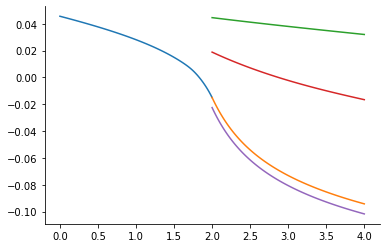

In [329]:
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_list), axis=0, weights=dmg_weight)
# ϕ_bound = np.average(ϕ_avg_list, axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
plt.plot(y_grid[:numy_bar+1], ϕ)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])
plt.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:])
plt.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:])
plt.plot(y_grid[numy_bar:], ϕ_list[2][numy_bar:])

In [270]:
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, θ_list)

(0.0, 8.749788625707845)

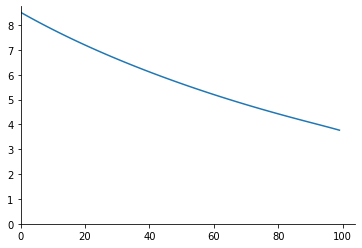

In [271]:
plt.plot(et[et>0])
plt.xlim(left=0)
plt.ylim(bottom=0)

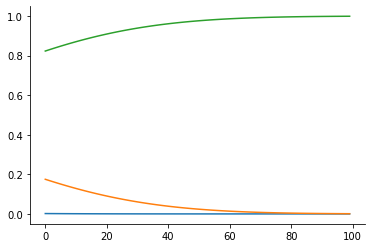

In [311]:
plt.plot(πᵈt[:,0])
plt.plot(πᵈt[:,1])
plt.plot(πᵈt[:,2])

In [272]:
ξₐ = 1/4_000
ξ = 1/400
ξₘ = ξ
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ)
ϕ_avg, ems_avg, πᶜ_avg, ι_avg, πᵈ_avg, h_avg, ϕ_avg_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.001701973946087637,	 ft error: 0.0014441530971859087
episode: 2,	 ode error: 0.001430735001627929,	 ft error: 0.0013021738830766595
episode: 3,	 ode error: 0.0013219263583669342,	 ft error: 0.0012342167654060454
episode: 4,	 ode error: 0.0012555272743293166,	 ft error: 0.0011892187455965625
episode: 5,	 ode error: 0.001205698621894978,	 ft error: 0.0011537539163887884
episode: 6,	 ode error: 0.0011651709663197782,	 ft error: 0.001123470571912951
episode: 7,	 ode error: 0.0011309722158806949,	 ft error: 0.0010968675990430561
episode: 8,	 ode error: 0.0011014468809918618,	 ft error: 0.0010729483403232871
episode: 9,	 ode error: 0.0010756506555361736,	 ft error: 0.0010514174607618725
episode: 10,	 ode error: 0.001052739772406524,	 ft error: 0.0010317166589183936
episode: 11,	 ode error: 0.0010322395949625392,	 ft error: 0.001013684862871896
episode: 12,	 ode error: 0.0010136402725028414,	 ft error: 0.000997058883178449
episode: 13,	 ode error: 0.00099660246531784

episode: 168,	 ode error: 0.00036920510885623983,	 ft error: 0.0003685004393593044
episode: 169,	 ode error: 0.00036751935456364924,	 ft error: 0.0003668201815478292
episode: 170,	 ode error: 0.00036584394130634746,	 ft error: 0.00036515019319117764
episode: 171,	 ode error: 0.00036417876948753006,	 ft error: 0.00036349037602414574
episode: 172,	 ode error: 0.0003625237410667803,	 ft error: 0.0003618406333049292
episode: 173,	 ode error: 0.000360878759524914,	 ft error: 0.00036020086978100685
episode: 174,	 ode error: 0.0003592437298296611,	 ft error: 0.00035857099165576467
episode: 175,	 ode error: 0.00035761855840241554,	 ft error: 0.0003569509065562184
episode: 176,	 ode error: 0.000356003153086154,	 ft error: 0.0003553405235017423
episode: 177,	 ode error: 0.0003543974231138183,	 ft error: 0.000353739752873584
episode: 178,	 ode error: 0.0003528012790781522,	 ft error: 0.0003521485063851434
episode: 179,	 ode error: 0.0003512146329018482,	 ft error: 0.00035056669705343013
episode: 

episode: 342,	 ode error: 0.0001785717502560451,	 ft error: 0.00017830315201602018
episode: 343,	 ode error: 0.0001778762993177314,	 ft error: 0.0001776087599128275
episode: 344,	 ode error: 0.0001771839444945617,	 ft error: 0.00017691745611965923
episode: 345,	 ode error: 0.00017649466901950345,	 ft error: 0.0001762292239406114
episode: 346,	 ode error: 0.00017580845624488568,	 ft error: 0.0001755440467982733
episode: 347,	 ode error: 0.00017512528964118098,	 ft error: 0.00017486190823257086
episode: 348,	 ode error: 0.00017444515279599912,	 ft error: 0.00017418279189967967
episode: 349,	 ode error: 0.00017376802941290498,	 ft error: 0.00017350668157100718
episode: 350,	 ode error: 0.0001730939033101123,	 ft error: 0.00017283356113180492
episode: 351,	 ode error: 0.00017242275841957723,	 ft error: 0.00017216341458024348
episode: 352,	 ode error: 0.00017175457878588812,	 ft error: 0.00017149622602648704
episode: 353,	 ode error: 0.00017108934856512287,	 ft error: 0.000170831979691329
e

episode: 514,	 ode error: 9.369892422367776e-05,	 ft error: 9.353736002753096e-05
episode: 515,	 ode error: 9.336030273123614e-05,	 ft error: 9.319907926736797e-05
episode: 516,	 ode error: 9.302302647557306e-05,	 ft error: 9.286214183011159e-05
episode: 517,	 ode error: 9.268708968122896e-05,	 ft error: 9.252654195839964e-05
episode: 518,	 ode error: 9.235248660849598e-05,	 ft error: 9.219227393042022e-05
episode: 519,	 ode error: 9.20192115532951e-05,	 ft error: 9.185933206009671e-05
episode: 520,	 ode error: 9.168725884682691e-05,	 ft error: 9.152771069634766e-05
episode: 521,	 ode error: 9.135662285537666e-05,	 ft error: 9.119740422297111e-05
episode: 522,	 ode error: 9.102729797999748e-05,	 ft error: 9.086840705848273e-05
episode: 523,	 ode error: 9.069927865625559e-05,	 ft error: 9.054071365567629e-05
episode: 524,	 ode error: 9.03725593539487e-05,	 ft error: 9.021431850141556e-05
episode: 525,	 ode error: 9.00471345767741e-05,	 ft error: 8.988921611633358e-05
episode: 526,	 ode 

episode: 655,	 ode error: 5.6985067886042014e-05,	 ft error: 5.6856824171535224e-05
episode: 656,	 ode error: 5.678939818128906e-05,	 ft error: 5.6661292537132923e-05
episode: 657,	 ode error: 5.6594448721707124e-05,	 ft error: 5.646647992266681e-05
episode: 658,	 ode error: 5.640021601036494e-05,	 ft error: 5.6272382842522305e-05
episode: 659,	 ode error: 5.620669657273119e-05,	 ft error: 5.6078997833682496e-05
episode: 660,	 ode error: 5.60138869572012e-05,	 ft error: 5.588632145607508e-05
episode: 661,	 ode error: 5.5821783735101184e-05,	 ft error: 5.569435029287306e-05
episode: 662,	 ode error: 5.56303835009996e-05,	 ft error: 5.550308095056411e-05
episode: 663,	 ode error: 5.5439682872617294e-05,	 ft error: 5.5312510059043106e-05
episode: 664,	 ode error: 5.524967849129716e-05,	 ft error: 5.5122634271797165e-05
episode: 665,	 ode error: 5.506036702182678e-05,	 ft error: 5.493345026588252e-05
episode: 666,	 ode error: 5.487174515267617e-05,	 ft error: 5.4744954742456484e-05
episode

episode: 788,	 ode error: 3.621508815366474e-05,	 ft error: 3.6098645178779073e-05
episode: 789,	 ode error: 3.6092493414527057e-05,	 ft error: 3.597611145496338e-05
episode: 790,	 ode error: 3.5970320122939085e-05,	 ft error: 3.5853998937874595e-05
episode: 791,	 ode error: 3.584856680259943e-05,	 ft error: 3.573230615267394e-05
episode: 792,	 ode error: 3.572723198303775e-05,	 ft error: 3.561103163021255e-05
episode: 793,	 ode error: 3.560631419949865e-05,	 ft error: 3.549017390698517e-05
episode: 794,	 ode error: 3.54858119929807e-05,	 ft error: 3.536973152550027e-05
episode: 795,	 ode error: 3.536572391022168e-05,	 ft error: 3.524970303358614e-05
episode: 796,	 ode error: 3.524604850353003e-05,	 ft error: 3.5130086984807206e-05
episode: 797,	 ode error: 3.5126784330680714e-05,	 ft error: 3.5010881938348413e-05
episode: 798,	 ode error: 3.5007929955201264e-05,	 ft error: 3.489208645878391e-05
episode: 799,	 ode error: 3.488948394595262e-05,	 ft error: 3.477369911626209e-05
episode: 

episode: 912,	 ode error: 2.3816493343745268e-05,	 ft error: 2.3706077473331644e-05
episode: 913,	 ode error: 2.3736409161572575e-05,	 ft error: 2.3626031203256386e-05
episode: 914,	 ode error: 2.365659880704154e-05,	 ft error: 2.354625861601678e-05
episode: 915,	 ode error: 2.3577061332847107e-05,	 ft error: 2.3466758764823886e-05
episode: 916,	 ode error: 2.3497795794787417e-05,	 ft error: 2.338753070591874e-05
episode: 917,	 ode error: 2.3418801252002882e-05,	 ft error: 2.330857349908122e-05
episode: 918,	 ode error: 2.334007676689986e-05,	 ft error: 2.3229886207236837e-05
episode: 919,	 ode error: 2.3261621405222315e-05,	 ft error: 2.315146789668802e-05
episode: 920,	 ode error: 2.3183434235954782e-05,	 ft error: 2.3073317636859714e-05
episode: 921,	 ode error: 2.310551433128594e-05,	 ft error: 2.2995434500646304e-05
episode: 922,	 ode error: 2.302786076670369e-05,	 ft error: 2.2917817563925896e-05
episode: 923,	 ode error: 2.2950472620964705e-05,	 ft error: 2.284046590599979e-05
e

episode: 1036,	 ode error: 1.5709050803346916e-05,	 ft error: 1.560238350008699e-05
episode: 1037,	 ode error: 1.5656622275456492e-05,	 ft error: 1.5549978528914266e-05
episode: 1038,	 ode error: 1.5604372087072208e-05,	 ft error: 1.5497751806846836e-05
episode: 1039,	 ode error: 1.5552299623977054e-05,	 ft error: 1.544570272002388e-05
episode: 1040,	 ode error: 1.550040427419181e-05,	 ft error: 1.5393830656758776e-05
episode: 1041,	 ode error: 1.5448685427860024e-05,	 ft error: 1.5342135007631597e-05
episode: 1042,	 ode error: 1.539714247718023e-05,	 ft error: 1.5290615165095927e-05
episode: 1043,	 ode error: 1.5345774816537478e-05,	 ft error: 1.5239270523918307e-05
episode: 1044,	 ode error: 1.529458184240933e-05,	 ft error: 1.5188100480854432e-05
episode: 1045,	 ode error: 1.5243562953340698e-05,	 ft error: 1.5137104434834181e-05
episode: 1046,	 ode error: 1.5192717549947004e-05,	 ft error: 1.5086281786845976e-05
episode: 1047,	 ode error: 1.5142045035041558e-05,	 ft error: 1.503563

episode: 1161,	 ode error: 1.0361555875253127e-05,	 ft error: 1.0257230456089025e-05
episode: 1162,	 ode error: 1.032727281559257e-05,	 ft error: 1.0222961952521814e-05
episode: 1163,	 ode error: 1.0293105753602467e-05,	 ft error: 1.018880939060903e-05
episode: 1164,	 ode error: 1.025905429192695e-05,	 ft error: 1.0154772373168383e-05
episode: 1165,	 ode error: 1.0225118034433347e-05,	 ft error: 1.0120850504243458e-05
episode: 1166,	 ode error: 1.0191296586528772e-05,	 ft error: 1.0087043389520045e-05
episode: 1167,	 ode error: 1.0157589554883758e-05,	 ft error: 1.0053350635909805e-05
episode: 1168,	 ode error: 1.0123996547505118e-05,	 ft error: 1.0019771851550268e-05
episode: 1169,	 ode error: 1.009051717395929e-05,	 ft error: 9.986306646313689e-06
episode: 1170,	 ode error: 1.0057151044891494e-05,	 ft error: 9.95295463088186e-06
episode: 1171,	 ode error: 1.0023897772423198e-05,	 ft error: 9.919715417856339e-06
episode: 1172,	 ode error: 9.99075697008479e-06,	 ft error: 9.88658862081

episode: 1285,	 ode error: 6.8837174304399885e-06,	 ft error: 6.780829087509507e-06
episode: 1286,	 ode error: 6.861172993695148e-06,	 ft error: 6.758293666272083e-06
episode: 1287,	 ode error: 6.838704432715831e-06,	 ft error: 6.735834086242972e-06
episode: 1288,	 ode error: 6.816311489057296e-06,	 ft error: 6.713450088693951e-06
episode: 1289,	 ode error: 6.793993904878593e-06,	 ft error: 6.691141416053278e-06
episode: 1290,	 ode error: 6.771751423432842e-06,	 ft error: 6.668907811813174e-06
episode: 1291,	 ode error: 6.749583788756607e-06,	 ft error: 6.646749019974715e-06
episode: 1292,	 ode error: 6.727490745746657e-06,	 ft error: 6.624664785718585e-06
episode: 1293,	 ode error: 6.705472040313492e-06,	 ft error: 6.602654854965621e-06
episode: 1294,	 ode error: 6.683527419054126e-06,	 ft error: 6.580718974515584e-06
episode: 1295,	 ode error: 6.661656629633949e-06,	 ft error: 6.558856892139679e-06
episode: 1296,	 ode error: 6.639859420361173e-06,	 ft error: 6.537068356303004e-06
epi

episode: 1410,	 ode error: 4.579494076060553e-06,	 ft error: 4.4775007921928535e-06
episode: 1411,	 ode error: 4.5646856702600234e-06,	 ft error: 4.462697940609458e-06
episode: 1412,	 ode error: 4.549926838226244e-06,	 ft error: 4.447944641286505e-06
episode: 1413,	 ode error: 4.535217411971953e-06,	 ft error: 4.433240726349023e-06
episode: 1414,	 ode error: 4.520557224003312e-06,	 ft error: 4.418586028315241e-06
episode: 1415,	 ode error: 4.50594610737487e-06,	 ft error: 4.403980380304762e-06
episode: 1416,	 ode error: 4.4913838957124416e-06,	 ft error: 4.389423616131076e-06
episode: 1417,	 ode error: 4.476870423285643e-06,	 ft error: 4.374915570139656e-06
episode: 1418,	 ode error: 4.462405524969506e-06,	 ft error: 4.360456077115438e-06
episode: 1419,	 ode error: 4.4479890360688435e-06,	 ft error: 4.346044972606637e-06
episode: 1420,	 ode error: 4.43362079243447e-06,	 ft error: 4.331682092531541e-06
episode: 1421,	 ode error: 4.419300630691104e-06,	 ft error: 4.317367273548589e-06
ep

episode: 1534,	 ode error: 3.074172363570402e-06,	 ft error: 2.972726681043277e-06
episode: 1535,	 ode error: 3.0643910670871298e-06,	 ft error: 2.9629488143094003e-06
episode: 1536,	 ode error: 3.054642343561318e-06,	 ft error: 2.953203507109296e-06
episode: 1537,	 ode error: 3.0449260830855496e-06,	 ft error: 2.943490649739052e-06
episode: 1538,	 ode error: 3.0352421763221553e-06,	 ft error: 2.93381013286483e-06
episode: 1539,	 ode error: 3.0255905141104078e-06,	 ft error: 2.924161847407218e-06
episode: 1540,	 ode error: 3.015970987713069e-06,	 ft error: 2.9145456845180995e-06
episode: 1541,	 ode error: 3.006383488787551e-06,	 ft error: 2.904961536135768e-06
episode: 1542,	 ode error: 2.9968279094092247e-06,	 ft error: 2.8954092942216443e-06
episode: 1543,	 ode error: 2.9873041419497745e-06,	 ft error: 2.8858888511997436e-06
episode: 1544,	 ode error: 2.977812079111566e-06,	 ft error: 2.8764000999335444e-06
episode: 1545,	 ode error: 2.968351613982941e-06,	 ft error: 2.86694293354095

episode: 2,	 ode error: 0.0014306921609161742,	 ft error: 0.0013023752374208622
episode: 3,	 ode error: 0.0013218926543960361,	 ft error: 0.0012343499141931654
episode: 4,	 ode error: 0.0012554818696492599,	 ft error: 0.0011891831681851484
episode: 5,	 ode error: 0.0012056820703157663,	 ft error: 0.001153736187501302
episode: 6,	 ode error: 0.0011651602177833256,	 ft error: 0.0011234593648477569
episode: 7,	 ode error: 0.0011309664977013055,	 ft error: 0.0010969500099903514
episode: 8,	 ode error: 0.0011013939691050627,	 ft error: 0.0010730013348122622
episode: 9,	 ode error: 0.001075613116646106,	 ft error: 0.0010514017291338958
episode: 10,	 ode error: 0.0010527298648323733,	 ft error: 0.0010317236604021236
episode: 11,	 ode error: 0.0010322360711173609,	 ft error: 0.0010136964578786607
episode: 12,	 ode error: 0.0010136376985105367,	 ft error: 0.0009970762393105796
episode: 13,	 ode error: 0.0009965994403863649,	 ft error: 0.0009816223895097796
episode: 14,	 ode error: 0.00098087330

episode: 113,	 ode error: 0.0004814094839566132,	 ft error: 0.0004801137255725415
episode: 114,	 ode error: 0.0004789451403762632,	 ft error: 0.00047766326797171515
episode: 115,	 ode error: 0.00047649920519531096,	 ft error: 0.00047523086225632666
episode: 116,	 ode error: 0.00047407133569067476,	 ft error: 0.00047281617217502514
episode: 117,	 ode error: 0.0004716611901719917,	 ft error: 0.0004704188619382432
episode: 118,	 ode error: 0.0004692684277988933,	 ft error: 0.0004680385961072092
episode: 119,	 ode error: 0.0004668927084344708,	 ft error: 0.00046567503951303973
episode: 120,	 ode error: 0.00046453369253612246,	 ft error: 0.0004633278572114171
episode: 121,	 ode error: 0.00046219104108456276,	 ft error: 0.00046099671447087426
episode: 122,	 ode error: 0.00045986441555229205,	 ft error: 0.0004586812767986767
episode: 123,	 ode error: 0.00045755347791178824,	 ft error: 0.0004563812100035619
episode: 124,	 ode error: 0.00045525789068430456,	 ft error: 0.00045409618029614485
epi

episode: 230,	 ode error: 0.00025960157269605457,	 ft error: 0.0002588644621203303
episode: 231,	 ode error: 0.0002581209438085515,	 ft error: 0.0002573883232344828
episode: 232,	 ode error: 0.00025664784236057684,	 ft error: 0.0002559197053594864
episode: 233,	 ode error: 0.0002551822709046946,	 ft error: 0.0002544586103791352
episode: 234,	 ode error: 0.000253724230518989,	 ft error: 0.00025300503871584595
episode: 235,	 ode error: 0.00025227372084736825,	 ft error: 0.00025155898937194443
episode: 236,	 ode error: 0.0002508307401397202,	 ft error: 0.00025012045997002685
episode: 237,	 ode error: 0.00024939528529186903,	 ft error: 0.0002486894467941536
episode: 238,	 ode error: 0.00024796735188532045,	 ft error: 0.00024726594482970177
episode: 239,	 ode error: 0.0002465469342266647,	 ft error: 0.0002458499478030322
episode: 240,	 ode error: 0.00024513402538667664,	 ft error: 0.0002444414482213192
episode: 241,	 ode error: 0.00024372861723900396,	 ft error: 0.00024304043741110726
episo

episode: 349,	 ode error: 0.0001307888323420197,	 ft error: 0.00013046164950579014
episode: 350,	 ode error: 0.00013004231720513122,	 ft error: 0.00012971742638846762
episode: 351,	 ode error: 0.00012930019342808946,	 ft error: 0.0001289775784413481
episode: 352,	 ode error: 0.0001285624338507365,	 ft error: 0.00012824207861884357
episode: 353,	 ode error: 0.00012782901146524378,	 ft error: 0.00012751090002668017
episode: 354,	 ode error: 0.0001270998994160811,	 ft error: 0.00012678401592314723
episode: 355,	 ode error: 0.00012637507099990948,	 ft error: 0.00012606139971766314
episode: 356,	 ode error: 0.00012565449966576016,	 ft error: 0.00012534302497193192
episode: 357,	 ode error: 0.0001249381590147751,	 ft error: 0.00012462886539908735
episode: 358,	 ode error: 0.0001242260228001285,	 ft error: 0.00012391889486397062
episode: 359,	 ode error: 0.0001235180649269736,	 ft error: 0.00012321308738280634
episode: 360,	 ode error: 0.00012281425945214408,	 ft error: 0.00012251141712294838

episode: 496,	 ode error: 5.6927143768834097e-05,	 ft error: 5.671206225001113e-05
episode: 497,	 ode error: 5.660457529407326e-05,	 ft error: 5.639055966256505e-05
episode: 498,	 ode error: 5.6283792529098625e-05,	 ft error: 5.607083515895654e-05
episode: 499,	 ode error: 5.596478558861514e-05,	 ft error: 5.575287892377323e-05
episode: 500,	 ode error: 5.5647544633606475e-05,	 ft error: 5.543668118714503e-05
episode: 501,	 ode error: 5.533205987094062e-05,	 ft error: 5.5122232223564493e-05
episode: 502,	 ode error: 5.501832155343025e-05,	 ft error: 5.4809522352557614e-05
episode: 503,	 ode error: 5.470631997959985e-05,	 ft error: 5.449854193835998e-05
episode: 504,	 ode error: 5.439604549361144e-05,	 ft error: 5.418928138977801e-05
episode: 505,	 ode error: 5.40874884850884e-05,	 ft error: 5.388173116005017e-05
episode: 506,	 ode error: 5.378063938908835e-05,	 ft error: 5.3575881746985764e-05
episode: 507,	 ode error: 5.3475488685939465e-05,	 ft error: 5.327172369271049e-05
episode: 5

episode: 617,	 ode error: 2.8545865136997244e-05,	 ft error: 2.8309303453701494e-05
episode: 618,	 ode error: 2.838315309674382e-05,	 ft error: 2.8146025315423095e-05
episode: 619,	 ode error: 2.8221290680186667e-05,	 ft error: 2.7983598694982424e-05
episode: 620,	 ode error: 2.8060273741492038e-05,	 ft error: 2.782201944856455e-05
episode: 621,	 ode error: 2.7900098142125368e-05,	 ft error: 2.7661283439154676e-05
episode: 622,	 ode error: 2.774075975108209e-05,	 ft error: 2.750138653709322e-05
episode: 623,	 ode error: 2.7582254445090602e-05,	 ft error: 2.734232462039965e-05
episode: 624,	 ode error: 2.7424578108861957e-05,	 ft error: 2.7184093574726214e-05
episode: 625,	 ode error: 2.7267726635318303e-05,	 ft error: 2.7026689293866795e-05
episode: 626,	 ode error: 2.711169592589191e-05,	 ft error: 2.6870107679780042e-05
episode: 627,	 ode error: 2.6956481890804893e-05,	 ft error: 2.6714344643121356e-05
episode: 628,	 ode error: 2.6802080449399236e-05,	 ft error: 2.6559396103196613e-0

episode: 776,	 ode error: 1.55813299309733e-05,	 ft error: 1.6862017092310798e-05
episode: 777,	 ode error: 1.5538681171369716e-05,	 ft error: 1.6818839574707832e-05
episode: 778,	 ode error: 1.549613496203649e-05,	 ft error: 1.6775769832132192e-05
episode: 779,	 ode error: 1.5453691073721675e-05,	 ft error: 1.673280758291105e-05
episode: 780,	 ode error: 1.5411349277675445e-05,	 ft error: 1.6689952544087876e-05
episode: 781,	 ode error: 1.5369109345653945e-05,	 ft error: 1.6647204431503398e-05
episode: 782,	 ode error: 1.532697104992376e-05,	 ft error: 1.660456296009629e-05
episode: 783,	 ode error: 1.5284934163265417e-05,	 ft error: 1.6562027843695003e-05
episode: 784,	 ode error: 1.5242998458977553e-05,	 ft error: 1.6519598795434097e-05
episode: 785,	 ode error: 1.5201163710877488e-05,	 ft error: 1.6477275527569207e-05
episode: 786,	 ode error: 1.5159429693305482e-05,	 ft error: 1.643505775163895e-05
episode: 787,	 ode error: 1.5117796181128118e-05,	 ft error: 1.6392945178349272e-05

episode: 937,	 ode error: 9.892707632822842e-06,	 ft error: 1.1119509519506854e-05
episode: 938,	 ode error: 9.863946328885165e-06,	 ft error: 1.1090517611546854e-05
episode: 939,	 ode error: 9.835256464272999e-06,	 ft error: 1.1061599557877593e-05
episode: 940,	 ode error: 9.80663787071421e-06,	 ft error: 1.103275523055743e-05
episode: 941,	 ode error: 9.778090380161309e-06,	 ft error: 1.100398450032634e-05
episode: 942,	 ode error: 9.749613824794898e-06,	 ft error: 1.0975287236270522e-05
episode: 943,	 ode error: 9.721208037028763e-06,	 ft error: 1.0946663306146225e-05
episode: 944,	 ode error: 9.692872849511935e-06,	 ft error: 1.0918112575986535e-05
episode: 945,	 ode error: 9.664608095134083e-06,	 ft error: 1.0889634910321116e-05
episode: 946,	 ode error: 9.636413607033023e-06,	 ft error: 1.0861230171644217e-05
episode: 947,	 ode error: 9.608289218596318e-06,	 ft error: 1.0832898221328307e-05
episode: 948,	 ode error: 9.580234763469488e-06,	 ft error: 1.080463891819002e-05
episode:

episode: 1102,	 ode error: 5.999957356487591e-06,	 ft error: 7.211938494548302e-06
episode: 1103,	 ode error: 5.980957936578253e-06,	 ft error: 7.192894342980076e-06
episode: 1104,	 ode error: 5.962006796959786e-06,	 ft error: 7.173898670109757e-06
episode: 1105,	 ode error: 5.9431038220065006e-06,	 ft error: 7.1549513636544795e-06
episode: 1106,	 ode error: 5.924248896325485e-06,	 ft error: 7.136052312048391e-06
episode: 1107,	 ode error: 5.905441904767314e-06,	 ft error: 7.117201403621562e-06
episode: 1108,	 ode error: 5.886682732412981e-06,	 ft error: 7.098398526380242e-06
episode: 1109,	 ode error: 5.867971264582301e-06,	 ft error: 7.079643569475602e-06
episode: 1110,	 ode error: 5.8493073868323415e-06,	 ft error: 7.0609364211104975e-06
episode: 1111,	 ode error: 5.8306909849564716e-06,	 ft error: 7.042276970794607e-06
episode: 1112,	 ode error: 5.812121944982627e-06,	 ft error: 7.023665106915822e-06
episode: 1113,	 ode error: 5.793600153178026e-06,	 ft error: 7.0051007189375625e-0

episode: 1282,	 ode error: 3.2570653037405776e-06,	 ft error: 4.464832774007481e-06
episode: 1283,	 ode error: 3.245111042592683e-06,	 ft error: 4.452872716479798e-06
episode: 1284,	 ode error: 3.233187838705664e-06,	 ft error: 4.440943846354314e-06
episode: 1285,	 ode error: 3.2212956147330794e-06,	 ft error: 4.429046085846026e-06
episode: 1286,	 ode error: 3.2094342935089e-06,	 ft error: 4.417179356140666e-06
episode: 1287,	 ode error: 3.197603798043414e-06,	 ft error: 4.405343580112428e-06
episode: 1288,	 ode error: 3.1858040515324987e-06,	 ft error: 4.393538679629365e-06
episode: 1289,	 ode error: 3.1740349773439044e-06,	 ft error: 4.381764577426894e-06
episode: 1290,	 ode error: 3.1622964990279338e-06,	 ft error: 4.370021195997572e-06
episode: 1291,	 ode error: 3.1505885403106657e-06,	 ft error: 4.358308458342805e-06
episode: 1292,	 ode error: 3.1389110250978588e-06,	 ft error: 4.346626287544952e-06
episode: 1293,	 ode error: 3.1272638774721047e-06,	 ft error: 4.334974606744202e-0

episode: 1462,	 ode error: 2.084447588225071e-06,	 ft error: 2.7469649421911955e-06
episode: 1463,	 ode error: 2.0870263401082177e-06,	 ft error: 2.739519695098743e-06
episode: 1464,	 ode error: 2.089602058020232e-06,	 ft error: 2.732094182625322e-06
episode: 1465,	 ode error: 2.0921747327783016e-06,	 ft error: 2.7246883541632667e-06
episode: 1466,	 ode error: 2.094744355308738e-06,	 ft error: 2.7173021590817803e-06
episode: 1467,	 ode error: 2.0973109166477375e-06,	 ft error: 2.7099355468310216e-06
episode: 1468,	 ode error: 2.099874407940458e-06,	 ft error: 2.7025884670346207e-06
episode: 1469,	 ode error: 2.1024348204389063e-06,	 ft error: 2.695260869454985e-06
episode: 1470,	 ode error: 2.1049921455050806e-06,	 ft error: 2.6879527040626905e-06
episode: 1471,	 ode error: 2.1075463746039248e-06,	 ft error: 2.680663920816747e-06
episode: 1472,	 ode error: 2.11009749930555e-06,	 ft error: 2.6733944696877288e-06
episode: 1473,	 ode error: 2.1126455112901142e-06,	 ft error: 2.66614430120

episode: 51,	 ode error: 0.0008388855524088442,	 ft error: 0.0008390765289546683
episode: 52,	 ode error: 0.0008363831638000566,	 ft error: 0.0008365593802847395
episode: 53,	 ode error: 0.0008338882764683093,	 ft error: 0.0008340514792954876
episode: 54,	 ode error: 0.000831400863666226,	 ft error: 0.0008315525262165765
episode: 55,	 ode error: 0.0008289208993868199,	 ft error: 0.0008290622726948976
episode: 56,	 ode error: 0.0008264483582385003,	 ft error: 0.0008265805123211858
episode: 57,	 ode error: 0.0008239832153458897,	 ft error: 0.0008241070719722706
episode: 58,	 ode error: 0.0008215254462715046,	 ft error: 0.0008216418048095341
episode: 59,	 ode error: 0.0008190750269536738,	 ft error: 0.0008191845848293129
episode: 60,	 ode error: 0.0008166319336569072,	 ft error: 0.0008167353026828963
episode: 61,	 ode error: 0.000814196142931838,	 ft error: 0.0008142938624631016
episode: 62,	 ode error: 0.0008117676315825579,	 ft error: 0.000811860179222868
episode: 63,	 ode error: 0.0008

episode: 219,	 ode error: 0.0005078400412055152,	 ft error: 0.0005077785202976803
episode: 220,	 ode error: 0.0005063256369640209,	 ft error: 0.0005062572524443486
episode: 221,	 ode error: 0.0005048157688875616,	 ft error: 0.0005047407540762865
episode: 222,	 ode error: 0.0005033104226672317,	 ft error: 0.0005032290397275624
episode: 223,	 ode error: 0.0005018095840181979,	 ft error: 0.0005017221014262432
episode: 224,	 ode error: 0.0005003132387108193,	 ft error: 0.0005002199207490565
episode: 225,	 ode error: 0.000498821372583929,	 ft error: 0.0004987224748106053
episode: 226,	 ode error: 0.0004973339715497297,	 ft error: 0.0004972297390779442
episode: 227,	 ode error: 0.0004958510215947997,	 ft error: 0.0004957416886781456
episode: 228,	 ode error: 0.0004943725087793895,	 ft error: 0.0004942582989699944
episode: 229,	 ode error: 0.0004928984192360641,	 ft error: 0.0004927795457682765
episode: 230,	 ode error: 0.0004914287391679988,	 ft error: 0.0004913054054548709
episode: 231,	 od

episode: 390,	 ode error: 0.0003047979587565032,	 ft error: 0.0003046159083520498
episode: 391,	 ode error: 0.00030388943285966847,	 ft error: 0.00030370778525444975
episode: 392,	 ode error: 0.0003029836153407359,	 ft error: 0.0003028023702937588
episode: 393,	 ode error: 0.00030208049812349973,	 ft error: 0.00030189965536798574
episode: 394,	 ode error: 0.00030118007315592453,	 ft error: 0.0003009996323956784
episode: 395,	 ode error: 0.0003002823324100614,	 ft error: 0.0003001022933237415
episode: 396,	 ode error: 0.0002993872678819789,	 ft error: 0.00029920763012211693
episode: 397,	 ode error: 0.0002984948715916881,	 ft error: 0.00029831563478568046
episode: 398,	 ode error: 0.00029760513558307303,	 ft error: 0.00029742629933299236
episode: 399,	 ode error: 0.00029671805192380875,	 ft error: 0.00029653961580935106
episode: 400,	 ode error: 0.000295833612705296,	 ft error: 0.0002956555762822592
episode: 401,	 ode error: 0.00029495181004258466,	 ft error: 0.00029477417284503227
epis

episode: 519,	 ode error: 0.00020738280344024087,	 ft error: 0.00020724613268199854
episode: 520,	 ode error: 0.00020676467524046891,	 ft error: 0.00020662829149980152
episode: 521,	 ode error: 0.0002061483897233974,	 ft error: 0.00020601229199987414
episode: 522,	 ode error: 0.00020553394139656458,	 ft error: 0.00020539812869174723
episode: 523,	 ode error: 0.0002049213247838805,	 ft error: 0.00020478579610146616
episode: 524,	 ode error: 0.00020431053442558134,	 ft error: 0.00020417528877145208
episode: 525,	 ode error: 0.00020370156487817422,	 ft error: 0.00020356660126077952
episode: 526,	 ode error: 0.00020309441071439697,	 ft error: 0.00020295972814406613
episode: 527,	 ode error: 0.0002024890665231644,	 ft error: 0.00020235466401230529
episode: 528,	 ode error: 0.0002018855269095213,	 ft error: 0.00020175140347268122
episode: 529,	 ode error: 0.00020128378649459224,	 ft error: 0.00020114994114930895
episode: 530,	 ode error: 0.00020068383991553903,	 ft error: 0.00020055027168069

episode: 631,	 ode error: 0.00014845018595687984,	 ft error: 0.00014834000116005036
episode: 632,	 ode error: 0.00014800774387570324,	 ft error: 0.00014789774959412622
episode: 633,	 ode error: 0.00014756662081005117,	 ft error: 0.0001474568163291797
episode: 634,	 ode error: 0.0001471268128282688,	 ft error: 0.00014701719743590025
episode: 635,	 ode error: 0.00014668831601041832,	 ft error: 0.00014657888899663463
episode: 636,	 ode error: 0.00014625112644824317,	 ft error: 0.0001461418871059883
episode: 637,	 ode error: 0.00014581524024513844,	 ft error: 0.00014570618786911388
episode: 638,	 ode error: 0.0001453806535161061,	 ft error: 0.00014527178740476415
episode: 639,	 ode error: 0.000144947362387732,	 ft error: 0.00014483868184071252
episode: 640,	 ode error: 0.00014451536299814457,	 ft error: 0.00014440686731810132
episode: 641,	 ode error: 0.00014408465149698044,	 ft error: 0.00014397633998931386
episode: 642,	 ode error: 0.00014365522404535239,	 ft error: 0.0001435470960173268

episode: 750,	 ode error: 0.00010407083659219032,	 ft error: 0.0001039789428524766
episode: 751,	 ode error: 0.00010376070235915548,	 ft error: 0.00010366892999533195
episode: 752,	 ode error: 0.00010345149275398937,	 ft error: 0.00010335984130638298
episode: 753,	 ode error: 0.00010314320502043627,	 ft error: 0.00010305167403061126
episode: 754,	 ode error: 0.0001028358364104523,	 ft error: 0.00010274442542220394
episode: 755,	 ode error: 0.00010252938418418758,	 ft error: 0.0001024380927421483
episode: 756,	 ode error: 0.00010222384560995361,	 ft error: 0.00010213267326170117
episode: 757,	 ode error: 0.0001019192179642067,	 ft error: 0.0001018281642582719
episode: 758,	 ode error: 0.00010161549853151901,	 ft error: 0.00010152456301819787
episode: 759,	 ode error: 0.00010131268460455512,	 ft error: 0.00010122186683628187
episode: 760,	 ode error: 0.00010101077348405004,	 ft error: 0.00010092007301449694
episode: 761,	 ode error: 0.00010070976247878068,	 ft error: 0.000100619178864114

episode: 865,	 ode error: 7.383903156847854e-05,	 ft error: 7.375847901868368e-05
episode: 866,	 ode error: 7.361903188928443e-05,	 ft error: 7.353855806154405e-05
episode: 867,	 ode error: 7.339968814399419e-05,	 ft error: 7.331929274688917e-05
episode: 868,	 ode error: 7.318099837717656e-05,	 ft error: 7.310068112049521e-05
episode: 869,	 ode error: 7.296296063922581e-05,	 ft error: 7.288272123368948e-05
episode: 870,	 ode error: 7.274557298634894e-05,	 ft error: 7.266541114404428e-05
episode: 871,	 ode error: 7.252883348054704e-05,	 ft error: 7.244874891435919e-05
episode: 872,	 ode error: 7.231274018959434e-05,	 ft error: 7.22327326142802e-05
episode: 873,	 ode error: 7.209729118702764e-05,	 ft error: 7.201736031784793e-05
episode: 874,	 ode error: 7.188248455212412e-05,	 ft error: 7.180263010567178e-05
episode: 875,	 ode error: 7.166831836988644e-05,	 ft error: 7.158854006377355e-05
episode: 876,	 ode error: 7.14547907310222e-05,	 ft error: 7.137508828474379e-05
episode: 877,	 ode

episode: 979,	 ode error: 5.255020078227498e-05,	 ft error: 5.24769987663339e-05
episode: 980,	 ode error: 5.2393675425529604e-05,	 ft error: 5.2320525440093434e-05
episode: 981,	 ode error: 5.2237616770815635e-05,	 ft error: 5.216451863132576e-05
episode: 982,	 ode error: 5.2082023426739776e-05,	 ft error: 5.200897694929152e-05
episode: 983,	 ode error: 5.192689400605472e-05,	 ft error: 5.185389900769222e-05
episode: 984,	 ode error: 5.177222712564832e-05,	 ft error: 5.169928342397638e-05
episode: 985,	 ode error: 5.16180214065326e-05,	 ft error: 5.1545128819894634e-05
episode: 986,	 ode error: 5.146427547382938e-05,	 ft error: 5.139143382136095e-05
episode: 987,	 ode error: 5.131098795675877e-05,	 ft error: 5.1238197057851265e-05
episode: 988,	 ode error: 5.115815748862711e-05,	 ft error: 5.108541716406882e-05
episode: 989,	 ode error: 5.1005782706813226e-05,	 ft error: 5.09330927777237e-05
episode: 990,	 ode error: 5.0853862252760304e-05,	 ft error: 5.0781222540828105e-05
episode: 9

episode: 1093,	 ode error: 3.7403712955349144e-05,	 ft error: 3.733540892581859e-05
episode: 1094,	 ode error: 3.729234963932072e-05,	 ft error: 3.722408060231423e-05
episode: 1095,	 ode error: 3.7181318378890806e-05,	 ft error: 3.7113084215463964e-05
episode: 1096,	 ode error: 3.707061818404101e-05,	 ft error: 3.700241877541144e-05
episode: 1097,	 ode error: 3.696024806770391e-05,	 ft error: 3.689208329590854e-05
episode: 1098,	 ode error: 3.68502070457531e-05,	 ft error: 3.6782076793390184e-05
episode: 1099,	 ode error: 3.674049413699711e-05,	 ft error: 3.667239828646548e-05
episode: 1100,	 ode error: 3.663110836317051e-05,	 ft error: 3.656304679799938e-05
episode: 1101,	 ode error: 3.652204874892112e-05,	 ft error: 3.645402135279974e-05
episode: 1102,	 ode error: 3.641331432180871e-05,	 ft error: 3.634532097872752e-05
episode: 1103,	 ode error: 3.630490411228853e-05,	 ft error: 3.623694470683558e-05
episode: 1104,	 ode error: 3.6196817153707605e-05,	 ft error: 3.612889157062853e-05


episode: 1207,	 ode error: 2.6627470397341726e-05,	 ft error: 2.6562485999174584e-05
episode: 1208,	 ode error: 2.6548239346094963e-05,	 ft error: 2.648327887599944e-05
episode: 1209,	 ode error: 2.6469244546591412e-05,	 ft error: 2.6404307926728803e-05
episode: 1210,	 ode error: 2.6390485294421886e-05,	 ft error: 2.6325572446926165e-05
episode: 1211,	 ode error: 2.6311960887273828e-05,	 ft error: 2.6247071734699277e-05
episode: 1212,	 ode error: 2.623367062493066e-05,	 ft error: 2.6168805090376335e-05
episode: 1213,	 ode error: 2.615561380926246e-05,	 ft error: 2.6090771816043395e-05
episode: 1214,	 ode error: 2.6077789744221843e-05,	 ft error: 2.60129712152668e-05
episode: 1215,	 ode error: 2.6000197735835716e-05,	 ft error: 2.593540259508235e-05
episode: 1216,	 ode error: 2.592283709219943e-05,	 ft error: 2.5858065263867358e-05
episode: 1217,	 ode error: 2.5845707123470923e-05,	 ft error: 2.5780958531803254e-05
episode: 1218,	 ode error: 2.5768807141865946e-05,	 ft error: 2.57040817

episode: 1316,	 ode error: 1.924497174378057e-05,	 ft error: 1.9182190061315756e-05
episode: 1317,	 ode error: 1.918775408892774e-05,	 ft error: 1.9124989282341225e-05
episode: 1318,	 ode error: 1.913070704940168e-05,	 ft error: 1.906795906540341e-05
episode: 1319,	 ode error: 1.907383011647652e-05,	 ft error: 1.9011098902390243e-05
episode: 1320,	 ode error: 1.9017122782943614e-05,	 ft error: 1.8954408286207352e-05
episode: 1321,	 ode error: 1.896058454310917e-05,	 ft error: 1.8897886711009376e-05
episode: 1322,	 ode error: 1.8904214892782097e-05,	 ft error: 1.8841533673310172e-05
episode: 1323,	 ode error: 1.8848013329279215e-05,	 ft error: 1.8785348670317486e-05
episode: 1324,	 ode error: 1.8791979351414842e-05,	 ft error: 1.8729331200719367e-05
episode: 1325,	 ode error: 1.8736112459496676e-05,	 ft error: 1.8673480765285522e-05
episode: 1326,	 ode error: 1.8680412155322543e-05,	 ft error: 1.8617796865988412e-05
episode: 1327,	 ode error: 1.8624877942174977e-05,	 ft error: 1.8562279

episode: 1436,	 ode error: 1.379905096346116e-05,	 ft error: 1.3404731454882043e-05
episode: 1437,	 ode error: 1.377713530445174e-05,	 ft error: 1.3364758225895928e-05
episode: 1438,	 ode error: 1.3755279014865316e-05,	 ft error: 1.33249041927667e-05
episode: 1439,	 ode error: 1.37334819407246e-05,	 ft error: 1.3285169000222993e-05
episode: 1440,	 ode error: 1.3711743928418492e-05,	 ft error: 1.3245552293872365e-05
episode: 1441,	 ode error: 1.3690064824700332e-05,	 ft error: 1.3206053720710154e-05
episode: 1442,	 ode error: 1.3668444476688672e-05,	 ft error: 1.316667292819429e-05
episode: 1443,	 ode error: 1.364688273186489e-05,	 ft error: 1.3127409565448039e-05
episode: 1444,	 ode error: 1.3625379438079371e-05,	 ft error: 1.3088263281964737e-05
episode: 1445,	 ode error: 1.360393444354739e-05,	 ft error: 1.3049233728486728e-05
episode: 1446,	 ode error: 1.3582547596843588e-05,	 ft error: 1.301032055769924e-05
episode: 1447,	 ode error: 1.3561218746902232e-05,	 ft error: 1.29715234219

episode: 1556,	 ode error: 1.155270694482952e-05,	 ft error: 9.367325980632243e-06
episode: 1557,	 ode error: 1.1536913530003326e-05,	 ft error: 9.33939199522967e-06
episode: 1558,	 ode error: 1.152116343239658e-05,	 ft error: 9.311541307686449e-06
episode: 1559,	 ode error: 1.1505456537165598e-05,	 ft error: 9.283773669497657e-06
episode: 1560,	 ode error: 1.1489792729751484e-05,	 ft error: 9.256088833499895e-06
episode: 1561,	 ode error: 1.1474171895880499e-05,	 ft error: 9.228486552298465e-06
episode: 1562,	 ode error: 1.145859392156442e-05,	 ft error: 9.200966580164005e-06
episode: 1563,	 ode error: 1.1443058693097388e-05,	 ft error: 9.173528671413411e-06
episode: 1564,	 ode error: 1.1427566097059683e-05,	 ft error: 9.146172581196248e-06
episode: 1565,	 ode error: 1.1412116020316122e-05,	 ft error: 9.118898066003597e-06
episode: 1566,	 ode error: 1.139670835000898e-05,	 ft error: 9.091704882372802e-06
episode: 1567,	 ode error: 1.1381342973564227e-05,	 ft error: 9.06459278776639e-0

episode: 1675,	 ode error: 9.948136570269735e-06,	 ft error: 6.565504989166268e-06
episode: 1676,	 ode error: 9.936765180709464e-06,	 ft error: 6.545925978855098e-06
episode: 1677,	 ode error: 9.925425288236974e-06,	 ft error: 6.5264053532761625e-06
episode: 1678,	 ode error: 9.914116807944722e-06,	 ft error: 6.506942938216964e-06
episode: 1679,	 ode error: 9.902839655140812e-06,	 ft error: 6.4875385604827125e-06
episode: 1680,	 ode error: 9.891593745357975e-06,	 ft error: 6.4681920461847255e-06
episode: 1681,	 ode error: 9.880378994345888e-06,	 ft error: 6.448903223608508e-06
episode: 1682,	 ode error: 9.869195318064751e-06,	 ft error: 6.429671920484456e-06
episode: 1683,	 ode error: 9.858042632693805e-06,	 ft error: 6.41049796528311e-06
episode: 1684,	 ode error: 9.846920854629058e-06,	 ft error: 6.391381186752569e-06
episode: 1685,	 ode error: 9.835829900485708e-06,	 ft error: 6.3723214148436735e-06
episode: 1686,	 ode error: 9.824769687084976e-06,	 ft error: 6.353318479507264e-06
e

episode: 1831,	 ode error: 8.50713789413111e-06,	 ft error: 4.1202876097101715e-06
episode: 1832,	 ode error: 8.49977761752828e-06,	 ft error: 4.108000311447979e-06
episode: 1833,	 ode error: 8.492437937798468e-06,	 ft error: 4.095749654893973e-06
episode: 1834,	 ode error: 8.485118798490079e-06,	 ft error: 4.083535530274851e-06
episode: 1835,	 ode error: 8.477820143306091e-06,	 ft error: 4.071357828973795e-06
episode: 1836,	 ode error: 8.470541916093476e-06,	 ft error: 4.059216442327726e-06
episode: 1837,	 ode error: 8.463284060852203e-06,	 ft error: 4.047111261904861e-06
episode: 1838,	 ode error: 8.456046521732496e-06,	 ft error: 4.0350421799673075e-06
episode: 1839,	 ode error: 8.448829243028378e-06,	 ft error: 4.023009088777174e-06
episode: 1840,	 ode error: 8.441632169181187e-06,	 ft error: 4.011011880966642e-06
episode: 1841,	 ode error: 8.434455244782031e-06,	 ft error: 3.999050449491707e-06
episode: 1842,	 ode error: 8.427298414570428e-06,	 ft error: 3.987124687724701e-06
epis

episode: 1999,	 ode error: 8.878743332421168e-06,	 ft error: 2.494704674967559e-06
episode: 2000,	 ode error: 8.883297579998474e-06,	 ft error: 2.4872649955857513e-06
episode: 2001,	 ode error: 8.887838996768881e-06,	 ft error: 2.479847501883163e-06
episode: 2002,	 ode error: 8.892367618269595e-06,	 ft error: 2.472452128310376e-06
episode: 2003,	 ode error: 8.896883479940923e-06,	 ft error: 2.4650788083927884e-06
episode: 2004,	 ode error: 8.90138661712292e-06,	 ft error: 2.4577274763959434e-06
episode: 2005,	 ode error: 8.905877065067129e-06,	 ft error: 2.450398067001721e-06
episode: 2006,	 ode error: 8.91035485892719e-06,	 ft error: 2.443090514706962e-06
episode: 2007,	 ode error: 8.914820033758247e-06,	 ft error: 2.435804754147286e-06
episode: 2008,	 ode error: 8.91927262452439e-06,	 ft error: 2.4285407207447207e-06
episode: 2009,	 ode error: 8.9237126660968e-06,	 ft error: 2.421298349227404e-06
episode: 2010,	 ode error: 8.928140193249648e-06,	 ft error: 2.414077575433697e-06
episo

episode: 108,	 ode error: 0.029658003634249974,	 ft error: 0.02965742472945454
episode: 109,	 ode error: 0.029570273376293518,	 ft error: 0.02956971220106741
episode: 110,	 ode error: 0.029482800929612675,	 ft error: 0.029483797984492337
episode: 111,	 ode error: 0.02939559056594466,	 ft error: 0.029396585028907594
episode: 112,	 ode error: 0.029308641125707018,	 ft error: 0.029309632848783334
episode: 113,	 ode error: 0.029221951828324436,	 ft error: 0.029222940892313552
episode: 114,	 ode error: 0.02913552189532221,	 ft error: 0.029136508501694063
episode: 115,	 ode error: 0.029049350550509084,	 ft error: 0.029050334937762066
episode: 116,	 ode error: 0.028963437020060614,	 ft error: 0.028964419421083264
episode: 117,	 ode error: 0.02887778053254244,	 ft error: 0.028878761158255273
episode: 118,	 ode error: 0.028792377098572186,	 ft error: 0.028794432799223262
episode: 119,	 ode error: 0.02870722965543988,	 ft error: 0.028709219932688455
episode: 120,	 ode error: 0.028622337280861148

episode: 213,	 ode error: 0.021742502038019022,	 ft error: 0.021743460538079518
episode: 214,	 ode error: 0.02167845340036889,	 ft error: 0.021679411236891582
episode: 215,	 ode error: 0.02161459654568252,	 ft error: 0.021615553922545626
episode: 216,	 ode error: 0.021550930906290133,	 ft error: 0.021551888029779736
episode: 217,	 ode error: 0.02148745591644955,	 ft error: 0.021488412991138944
episode: 218,	 ode error: 0.021424171012328037,	 ft error: 0.021425128237983298
episode: 219,	 ode error: 0.021361075631977186,	 ft error: 0.021362033201305735
episode: 220,	 ode error: 0.0212981692153024,	 ft error: 0.02129912731237823
episode: 221,	 ode error: 0.021235451204028897,	 ft error: 0.021236410003206235
episode: 222,	 ode error: 0.021172921041666,	 ft error: 0.021173880706874353
episode: 223,	 ode error: 0.021110578173471742,	 ft error: 0.021111538857786126
episode: 224,	 ode error: 0.02104842204641926,	 ft error: 0.021049383891862394
episode: 225,	 ode error: 0.020986452109166588,	 f

episode: 416,	 ode error: 0.012067322808571198,	 ft error: 0.012070473324974351
episode: 417,	 ode error: 0.012034232969520239,	 ft error: 0.01203740752450148
episode: 418,	 ode error: 0.012001262794607769,	 ft error: 0.012004461780575904
episode: 419,	 ode error: 0.011968412277303933,	 ft error: 0.01197163609736207
episode: 420,	 ode error: 0.011935681421727743,	 ft error: 0.011938930489551932
episode: 421,	 ode error: 0.011903070242507977,	 ft error: 0.011906344982322015
episode: 422,	 ode error: 0.011870578764745062,	 ft error: 0.011873879611373022
episode: 423,	 ode error: 0.011838207024056645,	 ft error: 0.011841534423039184
episode: 424,	 ode error: 0.011805955066692776,	 ft error: 0.01180930947446035
episode: 425,	 ode error: 0.011773822949709458,	 ft error: 0.011777204833801255
episode: 426,	 ode error: 0.011741810741191657,	 ft error: 0.011745220580510012
episode: 427,	 ode error: 0.011709918520518734,	 ft error: 0.011713356805621949
episode: 428,	 ode error: 0.011678146378667

episode: 521,	 ode error: 0.009397597008726466,	 ft error: 0.009415720730186322
episode: 522,	 ode error: 0.009388403640211946,	 ft error: 0.009407549968968356
episode: 523,	 ode error: 0.00938040996492156,	 ft error: 0.009400712690811469
episode: 524,	 ode error: 0.009373770540931798,	 ft error: 0.009395392204907007
episode: 525,	 ode error: 0.009368672524656438,	 ft error: 0.009391813799864679
episode: 526,	 ode error: 0.00936534606354029,	 ft error: 0.009389286146444034
episode: 527,	 ode error: 0.009364078704052621,	 ft error: 0.009389966512195458
episode: 528,	 ode error: 0.009365145658563776,	 ft error: 0.009393357473969055
episode: 529,	 ode error: 0.009368846375969794,	 ft error: 0.009399856683068333
episode: 530,	 ode error: 0.009375198559393014,	 ft error: 0.009409639115442714
episode: 531,	 ode error: 0.00938311052994298,	 ft error: 0.009421850882970415
episode: 532,	 ode error: 0.009387658531323256,	 ft error: 0.009431929671638226
episode: 533,	 ode error: 0.009371423999677

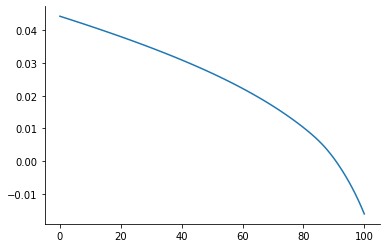

In [273]:
plt.plot(ϕ_avg)

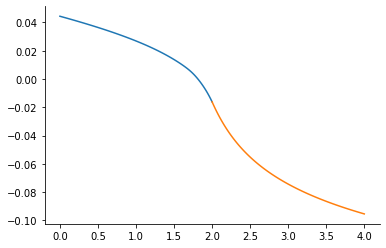

In [274]:
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_avg_list), axis=0, weights=dmg_weight)
# ϕ_bound = np.average(ϕ_avg_list, axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
plt.plot(y_grid[:numy_bar+1], ϕ_avg)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [275]:
yt_avg, et_avg, πᵈt_avg, πᶜt_avg, ιt_avg, ht_avg = simulate_jump(y_grid[:numy_bar+1], ems_avg, πᶜ_avg, πᵈ_avg, ι_avg, h_avg, θ_list)

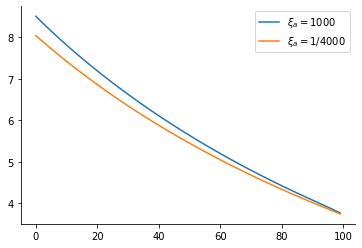

In [276]:
plt.plot(et[et>0], label="$\\xi_a = 1000$")
plt.plot(et_avg, label="$\\xi_a = 1/4000$")
plt.legend()

(0.0, 100.0)

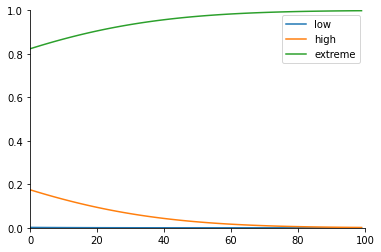

In [278]:
plt.plot(πᵈt_avg[:,0],label='low')
plt.plot(πᵈt_avg[:,1], label="high")
plt.plot(πᵈt_avg[:,2], label="extreme")
plt.legend()
plt.ylim(0,1)
plt.xlim(0,100)

(array([ 8., 12., 19., 20., 17., 29., 15., 11.,  9.,  4.]),
 array([0.0010154 , 0.00119479, 0.00137417, 0.00155356, 0.00173295,
        0.00191234, 0.00209172, 0.00227111, 0.0024505 , 0.00262988,
        0.00280927]),
 <BarContainer object of 10 artists>)

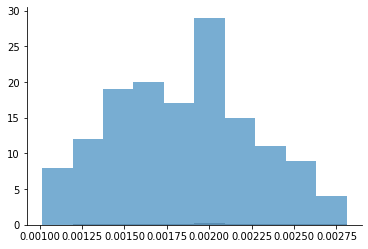

In [301]:
plt.hist(θ_list, weights=πᶜt_avg[-1], alpha=0.6, color='grey')
plt.hist(θ_list, alpha=0.6)

# partition: carbon and temp

In [280]:
ξₐ = 1/4_000
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θtemp_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ)
ϕ_temp, ems_temp, πᶜ_temp, ι_temp, πᵈ_temp, h_temp, ϕ_temp_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.001699109146391511,	 ft error: 0.0014389776816428226
episode: 2,	 ode error: 0.0014303929061628775,	 ft error: 0.0013020235810314756
episode: 3,	 ode error: 0.001319936274503811,	 ft error: 0.001233517405604844
episode: 4,	 ode error: 0.0012534668599948834,	 ft error: 0.001188144630366629
episode: 5,	 ode error: 0.0012039674004529128,	 ft error: 0.001152567783363673
episode: 6,	 ode error: 0.0011637981037292337,	 ft error: 0.0011223962556323015
episode: 7,	 ode error: 0.0011298126305705576,	 ft error: 0.001095811182442195
episode: 8,	 ode error: 0.0011004847643150686,	 ft error: 0.00107206194162787
episode: 9,	 ode error: 0.0010747590669816615,	 ft error: 0.0010504937696735116
episode: 10,	 ode error: 0.0010519486327741807,	 ft error: 0.0010308728032000663
episode: 11,	 ode error: 0.0010314576386880989,	 ft error: 0.001012858391769091
episode: 12,	 ode error: 0.0010128737788857427,	 ft error: 0.0009962477194096267
episode: 13,	 ode error: 0.0009958295806580778

episode: 146,	 ode error: 0.0004086165802149723,	 ft error: 0.0004077656814372929
episode: 147,	 ode error: 0.0004066760010898354,	 ft error: 0.00040583261414421645
episode: 148,	 ode error: 0.0004047484306211491,	 ft error: 0.0004039124432904731
episode: 149,	 ode error: 0.0004028337233793444,	 ft error: 0.0004020050258706406
episode: 150,	 ode error: 0.00040093173662792726,	 ft error: 0.0004001102215029385
episode: 151,	 ode error: 0.00039904233025188135,	 ft error: 0.00039822789236012895
episode: 152,	 ode error: 0.0003971653666889262,	 ft error: 0.0003963579031029836
episode: 153,	 ode error: 0.0003953007108624166,	 ft error: 0.0003945001208155094
episode: 154,	 ode error: 0.00039344823011704013,	 ft error: 0.00039265441494290337
episode: 155,	 ode error: 0.0003916077941563816,	 ft error: 0.0003908206572309179
episode: 156,	 ode error: 0.0003897792749824535,	 ft error: 0.00038899872166770166
episode: 157,	 ode error: 0.0003879625468374803,	 ft error: 0.00038718848442722414
episode:

episode: 317,	 ode error: 0.00019670817840430552,	 ft error: 0.0001964078384867942
episode: 318,	 ode error: 0.00019593042681950864,	 ft error: 0.00019563137007500472
episode: 319,	 ode error: 0.00019515623030917628,	 ft error: 0.00019485844681835693
episode: 320,	 ode error: 0.00019438556869967854,	 ft error: 0.0001940890486399477
episode: 321,	 ode error: 0.00019361842197180212,	 ft error: 0.00019332315561631602
episode: 322,	 ode error: 0.000192854770259172,	 ft error: 0.0001925607479754075
episode: 323,	 ode error: 0.00019209459384648346,	 ft error: 0.00019180180609514041
episode: 324,	 ode error: 0.0001913378731680206,	 ft error: 0.000191046310501856
episode: 325,	 ode error: 0.00019058458880585308,	 ft error: 0.00019029424186860674
episode: 326,	 ode error: 0.0001898347214886844,	 ft error: 0.00018954558101363003
episode: 327,	 ode error: 0.00018908825208982364,	 ft error: 0.00018880030889916838
episode: 328,	 ode error: 0.00018834516162607627,	 ft error: 0.00018805840662936465
e

episode: 489,	 ode error: 0.00010243627480880388,	 ft error: 0.00010226334652541544
episode: 490,	 ode error: 0.00010206258967641023,	 ft error: 0.00010189005720873576
episode: 491,	 ode error: 0.00010169040474078503,	 ft error: 0.00010151826568686093
episode: 492,	 ode error: 0.00010131971327496914,	 ft error: 0.00010114796525293365
episode: 493,	 ode error: 0.00010095050859207811,	 ft error: 0.0001007791492400184
episode: 494,	 ode error: 0.00010058278404536183,	 ft error: 0.00010041181102126337
episode: 495,	 ode error: 0.00010021653302771537,	 ft error: 0.00010004594400943775
episode: 496,	 ode error: 9.98517489720237e-05,	 ft error: 9.968154165727883e-05
episode: 497,	 ode error: 9.948842535062322e-05,	 ft error: 9.931859745668237e-05
episode: 498,	 ode error: 9.912655567521401e-05,	 ft error: 9.895710493918834e-05
episode: 499,	 ode error: 9.876613349685411e-05,	 ft error: 9.859705767554147e-05
episode: 500,	 ode error: 9.840715240579264e-05,	 ft error: 9.823844927541367e-05
epis

episode: 661,	 ode error: 5.5713178941314986e-05,	 ft error: 5.5583679284265664e-05
episode: 662,	 ode error: 5.55221073423902e-05,	 ft error: 5.539273898125252e-05
episode: 663,	 ode error: 5.533173436989469e-05,	 ft error: 5.5202496150828326e-05
episode: 664,	 ode error: 5.514205666896964e-05,	 ft error: 5.501294745041223e-05
episode: 665,	 ode error: 5.4953070908269654e-05,	 ft error: 5.482408956089998e-05
episode: 666,	 ode error: 5.476477378025179e-05,	 ft error: 5.4635919187126514e-05
episode: 667,	 ode error: 5.457716200093295e-05,	 ft error: 5.444843305775031e-05
episode: 668,	 ode error: 5.439023231024653e-05,	 ft error: 5.4261627925345876e-05
episode: 669,	 ode error: 5.420398147194393e-05,	 ft error: 5.4075500566172496e-05
episode: 670,	 ode error: 5.40184062738882e-05,	 ft error: 5.389004778100689e-05
episode: 671,	 ode error: 5.383350352781676e-05,	 ft error: 5.3705266394356764e-05
episode: 672,	 ode error: 5.364927006955788e-05,	 ft error: 5.352115325499285e-05
episode: 6

episode: 833,	 ode error: 3.103122444439736e-05,	 ft error: 3.091530130773975e-05
episode: 834,	 ode error: 3.0926407267754374e-05,	 ft error: 3.0810535670231884e-05
episode: 835,	 ode error: 3.0821949718160555e-05,	 ft error: 3.070612946312612e-05
episode: 836,	 ode error: 3.071785054714507e-05,	 ft error: 3.060208143871683e-05
episode: 837,	 ode error: 3.0614108510519785e-05,	 ft error: 3.04983903536236e-05
episode: 838,	 ode error: 3.0510722368590052e-05,	 ft error: 3.039505496890693e-05
episode: 839,	 ode error: 3.040769088613637e-05,	 ft error: 3.0292074050068212e-05
episode: 840,	 ode error: 3.0305012832057467e-05,	 ft error: 3.018944636684155e-05
episode: 841,	 ode error: 3.0202686979738835e-05,	 ft error: 3.0087170693332554e-05
episode: 842,	 ode error: 3.0100712106984734e-05,	 ft error: 2.998524580806461e-05
episode: 843,	 ode error: 2.9999086995797673e-05,	 ft error: 2.9883670493747554e-05
episode: 844,	 ode error: 2.9897810432515234e-05,	 ft error: 2.9782443537555252e-05
epi

episode: 1004,	 ode error: 1.7447000368689316e-05,	 ft error: 1.733755857112144e-05
episode: 1005,	 ode error: 1.738864593140441e-05,	 ft error: 1.727923091082717e-05
episode: 1006,	 ode error: 1.7330490309064696e-05,	 ft error: 1.722110196280639e-05
episode: 1007,	 ode error: 1.7272532815982775e-05,	 ft error: 1.7163171041773933e-05
episode: 1008,	 ode error: 1.721477276883784e-05,	 ft error: 1.7105437464850125e-05
episode: 1009,	 ode error: 1.7157209486663e-05,	 ft error: 1.70479005513526e-05
episode: 1010,	 ode error: 1.7099842290930708e-05,	 ft error: 1.699055962316639e-05
episode: 1011,	 ode error: 1.7042670505498987e-05,	 ft error: 1.6933414004582002e-05
episode: 1012,	 ode error: 1.6985693456398384e-05,	 ft error: 1.6876463021994748e-05
episode: 1013,	 ode error: 1.6928910472308587e-05,	 ft error: 1.681970600439046e-05
episode: 1014,	 ode error: 1.6872320883916576e-05,	 ft error: 1.676314228302167e-05
episode: 1015,	 ode error: 1.6815924024548385e-05,	 ft error: 1.67067711913844

episode: 1171,	 ode error: 1.0001772043478777e-05,	 ft error: 9.89563592825038e-06
episode: 1172,	 ode error: 9.968703104508599e-06,	 ft error: 9.862581067827485e-06
episode: 1173,	 ode error: 9.935746035813942e-06,	 ft error: 9.829638023447126e-06
episode: 1174,	 ode error: 9.902900454120231e-06,	 ft error: 9.79680641208236e-06
episode: 1175,	 ode error: 9.87016597761407e-06,	 ft error: 9.764085852094023e-06
episode: 1176,	 ode error: 9.837542225694744e-06,	 ft error: 9.731475963184466e-06
episode: 1177,	 ode error: 9.805028819143786e-06,	 ft error: 9.698976366189401e-06
episode: 1178,	 ode error: 9.772625380034122e-06,	 ft error: 9.666586683424832e-06
episode: 1179,	 ode error: 9.740331531731482e-06,	 ft error: 9.63430653859454e-06
episode: 1180,	 ode error: 9.70814689898558e-06,	 ft error: 9.602135556466274e-06
episode: 1181,	 ode error: 9.676071107699285e-06,	 ft error: 9.57007336326495e-06
episode: 1182,	 ode error: 9.644103785218976e-06,	 ft error: 9.53811958651074e-06
episode: 1

episode: 1337,	 ode error: 5.793827218891832e-06,	 ft error: 5.689419667725034e-06
episode: 1338,	 ode error: 5.774948053353544e-06,	 ft error: 5.670547913288101e-06
episode: 1339,	 ode error: 5.7561323026888685e-06,	 ft error: 5.65173954499935e-06
episode: 1340,	 ode error: 5.737379751242079e-06,	 ft error: 5.632994347382995e-06
episode: 1341,	 ode error: 5.718690183857808e-06,	 ft error: 5.614312105495234e-06
episode: 1342,	 ode error: 5.700063386552276e-06,	 ft error: 5.595692605271189e-06
episode: 1343,	 ode error: 5.681499145754787e-06,	 ft error: 5.577135633339873e-06
episode: 1344,	 ode error: 5.662997248642959e-06,	 ft error: 5.558640977047317e-06
episode: 1345,	 ode error: 5.644557483170049e-06,	 ft error: 5.540208424340924e-06
episode: 1346,	 ode error: 5.626179638096719e-06,	 ft error: 5.5218377642089296e-06
episode: 1347,	 ode error: 5.60786350290159e-06,	 ft error: 5.503528786171552e-06
episode: 1348,	 ode error: 5.589608867681822e-06,	 ft error: 5.485281280373511e-06
epis

episode: 1507,	 ode error: 3.344119462198123e-06,	 ft error: 3.240636265606593e-06
episode: 1508,	 ode error: 3.33344207135728e-06,	 ft error: 3.2299627056309177e-06
episode: 1509,	 ode error: 3.3228002872824538e-06,	 ft error: 3.2193247376475593e-06
episode: 1510,	 ode error: 3.3121939896800035e-06,	 ft error: 3.208722241243578e-06
episode: 1511,	 ode error: 3.3016230588171465e-06,	 ft error: 3.198155096884962e-06
episode: 1512,	 ode error: 3.2910873752398486e-06,	 ft error: 3.1876231850608283e-06
episode: 1513,	 ode error: 3.280586819925154e-06,	 ft error: 3.1771263869310546e-06
episode: 1514,	 ode error: 3.2701212742910525e-06,	 ft error: 3.1666645838174245e-06
episode: 1515,	 ode error: 3.2596906201327273e-06,	 ft error: 3.1562376576430946e-06
episode: 1516,	 ode error: 3.2492947395949085e-06,	 ft error: 3.1458454906550344e-06
episode: 1517,	 ode error: 3.2389335153644276e-06,	 ft error: 3.1354879654934185e-06
episode: 1518,	 ode error: 3.2286068304090325e-06,	 ft error: 3.12516496

episode: 16,	 ode error: 0.0009517849143425778,	 ft error: 0.0009401245772638032
episode: 17,	 ode error: 0.0009389126623783857,	 ft error: 0.0009280484193554979
episode: 18,	 ode error: 0.0009267411625726693,	 ft error: 0.0009165781522467761
episode: 19,	 ode error: 0.0009151452335978637,	 ft error: 0.0009056288057866559
episode: 20,	 ode error: 0.0009041812576127944,	 ft error: 0.000895195264172307
episode: 21,	 ode error: 0.0008936843250862361,	 ft error: 0.000885181339714865
episode: 22,	 ode error: 0.0008836246505084349,	 ft error: 0.000875549233918333
episode: 23,	 ode error: 0.0008739718286807842,	 ft error: 0.0008662961460714538
episode: 24,	 ode error: 0.0008646796300385928,	 ft error: 0.0008573663477074497
episode: 25,	 ode error: 0.0008557250444495357,	 ft error: 0.0008487451986362767
episode: 26,	 ode error: 0.0008470800396067425,	 ft error: 0.0008404113145327938
episode: 27,	 ode error: 0.0008387207839440837,	 ft error: 0.0008322237800773823
episode: 28,	 ode error: 0.0008

episode: 159,	 ode error: 0.0003816501647087527,	 ft error: 0.00038069449012079204
episode: 160,	 ode error: 0.00037971171507565485,	 ft error: 0.00037875895607316035
episode: 161,	 ode error: 0.00037777928987429803,	 ft error: 0.00037682937255867355
episode: 162,	 ode error: 0.0003758527987603543,	 ft error: 0.0003749056570181176
episode: 163,	 ode error: 0.00037393216098096,	 ft error: 0.0003729877362787168
episode: 164,	 ode error: 0.0003720173051432418,	 ft error: 0.00037107554630523565
episode: 165,	 ode error: 0.00037010816895807026,	 ft error: 0.00036916903192732675
episode: 166,	 ode error: 0.00036820469896116294,	 ft error: 0.0003672681465463276
episode: 167,	 ode error: 0.0003663068502141548,	 ft error: 0.00036537285182422496
episode: 168,	 ode error: 0.00036441458598788904,	 ft error: 0.0003634831173560116
episode: 169,	 ode error: 0.0003625278774303817,	 ft error: 0.00036159892032895197
episode: 170,	 ode error: 0.0003606467032220293,	 ft error: 0.0003597202451712083
episod

episode: 315,	 ode error: 0.0001586730703610036,	 ft error: 0.00015825801649408297
episode: 316,	 ode error: 0.00015776097320512625,	 ft error: 0.0001573488358115836
episode: 317,	 ode error: 0.00015685427463035405,	 ft error: 0.00015644503349313463
episode: 318,	 ode error: 0.00015595294272330838,	 ft error: 0.00015554657774574193
episode: 319,	 ode error: 0.00015505694569981987,	 ft error: 0.0001546534369013114
episode: 320,	 ode error: 0.00015416625190169098,	 ft error: 0.00015376557942240837
episode: 321,	 ode error: 0.00015328082979516563,	 ft error: 0.0001528829738856735
episode: 322,	 ode error: 0.0001524006479709934,	 ft error: 0.00015200558899868452
episode: 323,	 ode error: 0.0001515256751448826,	 ft error: 0.00015113339359269323
episode: 324,	 ode error: 0.00015065588015858368,	 ft error: 0.00015026635662505433
episode: 325,	 ode error: 0.00014979123198125292,	 ft error: 0.00014940444718105259
episode: 326,	 ode error: 0.0001489316997109302,	 ft error: 0.0001485476344754294


episode: 474,	 ode error: 6.430252664880987e-05,	 ft error: 6.406133014282926e-05
episode: 475,	 ode error: 6.393866481419408e-05,	 ft error: 6.369872553519304e-05
episode: 476,	 ode error: 6.357681635196322e-05,	 ft error: 6.333812471487807e-05
episode: 477,	 ode error: 6.321697032781793e-05,	 ft error: 6.297951685512819e-05
episode: 478,	 ode error: 6.285911585693794e-05,	 ft error: 6.262289117646425e-05
episode: 479,	 ode error: 6.250324210397499e-05,	 ft error: 6.226823694668408e-05
episode: 480,	 ode error: 6.214933828290272e-05,	 ft error: 6.191554348070061e-05
episode: 481,	 ode error: 6.179739365682637e-05,	 ft error: 6.156480014044934e-05
episode: 482,	 ode error: 6.14473975379411e-05,	 ft error: 6.121599633507335e-05
episode: 483,	 ode error: 6.109933928740937e-05,	 ft error: 6.086912152039141e-05
episode: 484,	 ode error: 6.0753208315158396e-05,	 ft error: 6.0524165199499214e-05
episode: 485,	 ode error: 6.0408994079683446e-05,	 ft error: 6.018111692193684e-05
episode: 486,	

episode: 640,	 ode error: 2.4891637005547895e-05,	 ft error: 2.4640693963295934e-05
episode: 641,	 ode error: 2.4747897480286362e-05,	 ft error: 2.449643354438443e-05
episode: 642,	 ode error: 2.4604911619410396e-05,	 ft error: 2.435292864866323e-05
episode: 643,	 ode error: 2.4462675553317548e-05,	 ft error: 2.421017540369756e-05
episode: 644,	 ode error: 2.4321185426312976e-05,	 ft error: 2.406816995086103e-05
episode: 645,	 ode error: 2.418043739691063e-05,	 ft error: 2.3926908445405053e-05
episode: 646,	 ode error: 2.4040427638071242e-05,	 ft error: 2.3786387056967673e-05
episode: 647,	 ode error: 2.3901152337556524e-05,	 ft error: 2.3646601969712355e-05
episode: 648,	 ode error: 2.3762607698107744e-05,	 ft error: 2.3507549382698056e-05
episode: 649,	 ode error: 2.362478993781327e-05,	 ft error: 2.343253302663703e-05
episode: 650,	 ode error: 2.3487695290236722e-05,	 ft error: 2.3373187697199364e-05
episode: 651,	 ode error: 2.335132000469691e-05,	 ft error: 2.3313986460075008e-05


episode: 812,	 ode error: 1.4180736068228209e-05,	 ft error: 1.544822632960907e-05
episode: 813,	 ode error: 1.414141640074113e-05,	 ft error: 1.5408526108651177e-05
episode: 814,	 ode error: 1.4102192019699425e-05,	 ft error: 1.5368923988260306e-05
episode: 815,	 ode error: 1.4063062712961781e-05,	 ft error: 1.532941969011742e-05
episode: 816,	 ode error: 1.4024028268910745e-05,	 ft error: 1.529001293737222e-05
episode: 817,	 ode error: 1.3985088476443913e-05,	 ft error: 1.5250703455302328e-05
episode: 818,	 ode error: 1.3946243124977729e-05,	 ft error: 1.5211490969659533e-05
episode: 819,	 ode error: 1.3907492004437856e-05,	 ft error: 1.5172375208404495e-05
episode: 820,	 ode error: 1.38688349052652e-05,	 ft error: 1.5133355900342113e-05
episode: 821,	 ode error: 1.3830271618400997e-05,	 ft error: 1.5094432776301125e-05
episode: 822,	 ode error: 1.379180193529175e-05,	 ft error: 1.5055605568567443e-05
episode: 823,	 ode error: 1.3753425647887381e-05,	 ft error: 1.5016874010699104e-05

episode: 983,	 ode error: 8.683036222399237e-06,	 ft error: 9.904980531709462e-06
episode: 984,	 ode error: 8.657257820532849e-06,	 ft error: 9.879089721808362e-06
episode: 985,	 ode error: 8.631543831181794e-06,	 ft error: 9.853265622780199e-06
episode: 986,	 ode error: 8.605894099943378e-06,	 ft error: 9.827508039237284e-06
episode: 987,	 ode error: 8.580308472828663e-06,	 ft error: 9.801816775653154e-06
episode: 988,	 ode error: 8.554786796269846e-06,	 ft error: 9.776191635483638e-06
episode: 989,	 ode error: 8.529328917118435e-06,	 ft error: 9.75063242221926e-06
episode: 990,	 ode error: 8.503934682644064e-06,	 ft error: 9.725138939061425e-06
episode: 991,	 ode error: 8.478603940540748e-06,	 ft error: 9.699710988471388e-06
episode: 992,	 ode error: 8.453336538925507e-06,	 ft error: 9.674348373257351e-06
episode: 993,	 ode error: 8.428132326335105e-06,	 ft error: 9.64905089596152e-06
episode: 994,	 ode error: 8.402991151734273e-06,	 ft error: 9.623818359010458e-06
episode: 995,	 ode

episode: 1155,	 ode error: 5.080797294064454e-06,	 ft error: 6.293860772624282e-06
episode: 1156,	 ode error: 5.064122572710761e-06,	 ft error: 6.277155526479561e-06
episode: 1157,	 ode error: 5.04749056293307e-06,	 ft error: 6.2604932548939365e-06
episode: 1158,	 ode error: 5.0309011607683465e-06,	 ft error: 6.243873853529573e-06
episode: 1159,	 ode error: 5.014354262476576e-06,	 ft error: 6.227297218384017e-06
episode: 1160,	 ode error: 4.99784976454941e-06,	 ft error: 6.2107632453507295e-06
episode: 1161,	 ode error: 4.981387563707539e-06,	 ft error: 6.194271830762636e-06
episode: 1162,	 ode error: 4.9649675568976545e-06,	 ft error: 6.177822871160829e-06
episode: 1163,	 ode error: 4.948589641292939e-06,	 ft error: 6.161416263190482e-06
episode: 1164,	 ode error: 4.932253714297048e-06,	 ft error: 6.145051903739633e-06
episode: 1165,	 ode error: 4.915959673537472e-06,	 ft error: 6.12872968962693e-06
episode: 1166,	 ode error: 4.899707416869598e-06,	 ft error: 6.112449518272389e-06
epi

episode: 1326,	 ode error: 2.7725689891782627e-06,	 ft error: 3.983423794197879e-06
episode: 1327,	 ode error: 2.7618618680910246e-06,	 ft error: 3.972716357050303e-06
episode: 1328,	 ode error: 2.751182709020603e-06,	 ft error: 3.962036978014116e-06
episode: 1329,	 ode error: 2.7405314417685124e-06,	 ft error: 3.951385586000352e-06
episode: 1330,	 ode error: 2.729907996301391e-06,	 ft error: 3.940762110405764e-06
episode: 1331,	 ode error: 2.719312302749212e-06,	 ft error: 3.930166480869968e-06
episode: 1332,	 ode error: 2.708744291410705e-06,	 ft error: 3.919598627148228e-06
episode: 1333,	 ode error: 2.6982038927446817e-06,	 ft error: 3.909058478891725e-06
episode: 1334,	 ode error: 2.6876910373749155e-06,	 ft error: 3.8985459662142325e-06
episode: 1335,	 ode error: 2.6772056560905747e-06,	 ft error: 3.888061019241089e-06
episode: 1336,	 ode error: 2.666747679841967e-06,	 ft error: 3.877603568606484e-06
episode: 1337,	 ode error: 2.656317039743223e-06,	 ft error: 3.8671735445861e-06

episode: 1497,	 ode error: 2.1652247359384537e-06,	 ft error: 2.5076781193465276e-06
episode: 1498,	 ode error: 2.167721232969799e-06,	 ft error: 2.5008651960885717e-06
episode: 1499,	 ode error: 2.17021435098511e-06,	 ft error: 2.4940703894036726e-06
episode: 1500,	 ode error: 2.172704084504396e-06,	 ft error: 2.4872936528821943e-06
episode: 1501,	 ode error: 2.175190428135214e-06,	 ft error: 2.4805349396866037e-06
episode: 1502,	 ode error: 2.1776733765682807e-06,	 ft error: 2.4737942033494407e-06
episode: 1503,	 ode error: 2.180152924580723e-06,	 ft error: 2.4670713971719493e-06
episode: 1504,	 ode error: 2.18262906703532e-06,	 ft error: 2.4603664751608285e-06
episode: 1505,	 ode error: 2.1851017988780094e-06,	 ft error: 2.4536793909411365e-06
episode: 1506,	 ode error: 2.187571115139133e-06,	 ft error: 2.447010098450183e-06
episode: 1507,	 ode error: 2.1900370109291024e-06,	 ft error: 2.4403585516484067e-06
episode: 1508,	 ode error: 2.192499481444847e-06,	 ft error: 2.433724704820

episode: 67,	 ode error: 0.0008003896378381852,	 ft error: 0.0008004647617464861
episode: 68,	 ode error: 0.0007980023561573115,	 ft error: 0.0007980741243454141
episode: 69,	 ode error: 0.0007956222031146621,	 ft error: 0.0007956908521945111
episode: 70,	 ode error: 0.000793249156814392,	 ft error: 0.0007933149014911536
episode: 71,	 ode error: 0.0007908831954837334,	 ft error: 0.0007909462310257132
episode: 72,	 ode error: 0.0007885242974662786,	 ft error: 0.0007885848018413776
episode: 73,	 ode error: 0.0007861724412161201,	 ft error: 0.0007862305769459205
episode: 74,	 ode error: 0.0007838276052927172,	 ft error: 0.0007838835210689326
episode: 75,	 ode error: 0.0007814897683563844,	 ft error: 0.000781543600452822
episode: 76,	 ode error: 0.0007791589091643067,	 ft error: 0.0007792107826755032
episode: 77,	 ode error: 0.000776835006567015,	 ft error: 0.0007768850364971737
episode: 78,	 ode error: 0.0007745180395052496,	 ft error: 0.000774566331729389
episode: 79,	 ode error: 0.00077

episode: 217,	 ode error: 0.0005113004183366314,	 ft error: 0.000511252136055999
episode: 218,	 ode error: 0.000509775651919611,	 ft error: 0.0005097202320597748
episode: 219,	 ode error: 0.0005082554540880888,	 ft error: 0.0005081928986689956
episode: 220,	 ode error: 0.00050673981072043,	 ft error: 0.0005066702861738354
episode: 221,	 ode error: 0.0005052287075103345,	 ft error: 0.0005051524566482048
episode: 222,	 ode error: 0.0005037221301105985,	 ft error: 0.0005036394239410491
episode: 223,	 ode error: 0.0005022200642023015,	 ft error: 0.0005021311786741756
episode: 224,	 ode error: 0.0005007224955254171,	 ft error: 0.0005006277011860433
episode: 225,	 ode error: 0.0004992294098911842,	 ft error: 0.0004991289676560772
episode: 226,	 ode error: 0.0004977407931862118,	 ft error: 0.0004976349528818674
episode: 227,	 ode error: 0.0004962566313729728,	 ft error: 0.0004961456314913487
episode: 228,	 ode error: 0.0004947769104887867,	 ft error: 0.0004946609784513278
episode: 229,	 ode e

episode: 372,	 ode error: 0.0003218873885594137,	 ft error: 0.00032169618180292553
episode: 373,	 ode error: 0.0003209279204150772,	 ft error: 0.00032073712039846586
episode: 374,	 ode error: 0.000319971312562967,	 ft error: 0.0003197809197092357
episode: 375,	 ode error: 0.00031901755647193017,	 ft error: 0.000318827571156588
episode: 376,	 ode error: 0.000318066643636396,	 ft error: 0.0003178770661875959
episode: 377,	 ode error: 0.0003171185655762893,	 ft error: 0.000316929396277967
episode: 378,	 ode error: 0.000316173313836956,	 ft error: 0.0003159845529282039
episode: 379,	 ode error: 0.00031523087998907976,	 ft error: 0.0003150425276667035
episode: 380,	 ode error: 0.00031429125562860527,	 ft error: 0.0003141033120475367
episode: 381,	 ode error: 0.0003133544323766597,	 ft error: 0.00031316689765146605
episode: 382,	 ode error: 0.0003124204018794709,	 ft error: 0.0003122332760857142
episode: 383,	 ode error: 0.0003114891558082915,	 ft error: 0.0003113024389836868
episode: 384,	 

episode: 527,	 ode error: 0.00020265524356815885,	 ft error: 0.0002025195863529043
episode: 528,	 ode error: 0.00020205121065096246,	 ft error: 0.00020191583548069086
episode: 529,	 ode error: 0.00020144897839916487,	 ft error: 0.0002013138842785663
episode: 530,	 ode error: 0.00020084854144557793,	 ft error: 0.00020071372738114657
episode: 531,	 ode error: 0.00020024989443900745,	 ft error: 0.00020011535944071865
episode: 532,	 ode error: 0.0001996530320442163,	 ft error: 0.00019951877512289218
episode: 533,	 ode error: 0.0001990579489418653,	 ft error: 0.00019892396911182683
episode: 534,	 ode error: 0.00019846463982847468,	 ft error: 0.00019833093610583757
episode: 535,	 ode error: 0.00019787309941637161,	 ft error: 0.00019773967081984645
episode: 536,	 ode error: 0.00019728332243364535,	 ft error: 0.00019715016798427243
episode: 537,	 ode error: 0.0001966953036240971,	 ft error: 0.00019656242234609528
episode: 538,	 ode error: 0.00019610903774719846,	 ft error: 0.000195976428666265

episode: 682,	 ode error: 0.0001275932005439836,	 ft error: 0.00012749095743456545
episode: 683,	 ode error: 0.00012721294005646683,	 ft error: 0.00012711085565456082
episode: 684,	 ode error: 0.00012683381323305644,	 ft error: 0.00012673188693782905
episode: 685,	 ode error: 0.00012645581669450904,	 ft error: 0.0001263540479070254
episode: 686,	 ode error: 0.00012607894707165066,	 ft error: 0.0001259773351955836
episode: 687,	 ode error: 0.0001257032010053477,	 ft error: 0.0001256017454464668
episode: 688,	 ode error: 0.00012532857514648043,	 ft error: 0.00012522727531235253
episode: 689,	 ode error: 0.0001249550661559072,	 ft error: 0.00012485392145739072
episode: 690,	 ode error: 0.0001245826707044407,	 ft error: 0.00012448168055331776
episode: 691,	 ode error: 0.00012421138547281572,	 ft error: 0.00012411054928357368
episode: 692,	 ode error: 0.0001238412071516567,	 ft error: 0.00012374052434103538
episode: 693,	 ode error: 0.00012347213244145398,	 ft error: 0.0001233716024282942
e

episode: 840,	 ode error: 7.962365913915311e-05,	 ft error: 7.954031117969144e-05
episode: 841,	 ode error: 7.938641410597453e-05,	 ft error: 7.93031534009984e-05
episode: 842,	 ode error: 7.914987641655482e-05,	 ft error: 7.906670264063813e-05
episode: 843,	 ode error: 7.891404396223882e-05,	 ft error: 7.883095679085221e-05
episode: 844,	 ode error: 7.867891464065368e-05,	 ft error: 7.859591375068235e-05
episode: 845,	 ode error: 7.844448635569291e-05,	 ft error: 7.836157142550779e-05
episode: 846,	 ode error: 7.821075701749773e-05,	 ft error: 7.812792772662891e-05
episode: 847,	 ode error: 7.797772454243962e-05,	 ft error: 7.789498057168369e-05
episode: 848,	 ode error: 7.774538685309767e-05,	 ft error: 7.766272788478634e-05
episode: 849,	 ode error: 7.751374187824392e-05,	 ft error: 7.74311675956485e-05
episode: 850,	 ode error: 7.72827875528243e-05,	 ft error: 7.720029764055059e-05
episode: 851,	 ode error: 7.705252181793899e-05,	 ft error: 7.697011596187928e-05
episode: 852,	 ode 

episode: 998,	 ode error: 4.969582038252449e-05,	 ft error: 4.962294936660302e-05
episode: 999,	 ode error: 4.954780726713708e-05,	 ft error: 4.947498538109459e-05
episode: 1000,	 ode error: 4.940023547557156e-05,	 ft error: 4.9327462546452004e-05
episode: 1001,	 ode error: 4.925310369208549e-05,	 ft error: 4.9180379547384786e-05
episode: 1002,	 ode error: 4.910641060485604e-05,	 ft error: 4.9033735073135874e-05
episode: 1003,	 ode error: 4.896015490597088e-05,	 ft error: 4.8887527816093845e-05
episode: 1004,	 ode error: 4.8814335291418216e-05,	 ft error: 4.874175647322695e-05
episode: 1005,	 ode error: 4.86689504610705e-05,	 ft error: 4.859641974492661e-05
episode: 1006,	 ode error: 4.852399911867795e-05,	 ft error: 4.845151633574759e-05
episode: 1007,	 ode error: 4.837947997185488e-05,	 ft error: 4.830704495357534e-05
episode: 1008,	 ode error: 4.8235391732066694e-05,	 ft error: 4.816300431092121e-05
episode: 1009,	 ode error: 4.8091733114620115e-05,	 ft error: 4.801939312339595e-05


episode: 1155,	 ode error: 3.111717251217186e-05,	 ft error: 3.1050261654943144e-05
episode: 1156,	 ode error: 3.102455556525238e-05,	 ft error: 3.095767339644784e-05
episode: 1157,	 ode error: 3.093221478110437e-05,	 ft error: 3.086536120526969e-05
episode: 1158,	 ode error: 3.0840149336332006e-05,	 ft error: 3.07733242587797e-05
episode: 1159,	 ode error: 3.0748358409996056e-05,	 ft error: 3.068156173601418e-05
episode: 1160,	 ode error: 3.0656841183604325e-05,	 ft error: 3.0590072819062605e-05
episode: 1161,	 ode error: 3.056559684110429e-05,	 ft error: 3.0498856692188585e-05
episode: 1162,	 ode error: 3.0474624568875737e-05,	 ft error: 3.040791254201499e-05
episode: 1163,	 ode error: 3.0383923555725098e-05,	 ft error: 3.031723955770893e-05
episode: 1164,	 ode error: 3.0293492992876153e-05,	 ft error: 3.0226836931074308e-05
episode: 1165,	 ode error: 3.0203332073965028e-05,	 ft error: 3.013670385576539e-05
episode: 1166,	 ode error: 3.0113439995030442e-05,	 ft error: 3.0046839528443

episode: 1313,	 ode error: 1.943400618250636e-05,	 ft error: 1.9370642050884717e-05
episode: 1314,	 ode error: 1.9376226292785494e-05,	 ft error: 1.9312879372818115e-05
episode: 1315,	 ode error: 1.9318618694725816e-05,	 ft error: 1.9255288932068515e-05
episode: 1316,	 ode error: 1.9261182874605667e-05,	 ft error: 1.9197870215481583e-05
episode: 1317,	 ode error: 1.9203918320233847e-05,	 ft error: 1.914062271087443e-05
episode: 1318,	 ode error: 1.914682452094636e-05,	 ft error: 1.9083545907636983e-05
episode: 1319,	 ode error: 1.908990096760252e-05,	 ft error: 1.902663929700954e-05
episode: 1320,	 ode error: 1.9033147152578648e-05,	 ft error: 1.8969902371481405e-05
episode: 1321,	 ode error: 1.8976562569764837e-05,	 ft error: 1.8913334625345984e-05
episode: 1322,	 ode error: 1.8920146714560817e-05,	 ft error: 1.885693555359058e-05
episode: 1323,	 ode error: 1.886389908387011e-05,	 ft error: 1.880070465397806e-05
episode: 1324,	 ode error: 1.8807819176095038e-05,	 ft error: 1.874464142

episode: 1471,	 ode error: 1.30779147003033e-05,	 ft error: 1.2084191497498583e-05
episode: 1472,	 ode error: 1.3057958605491525e-05,	 ft error: 1.2048156013087324e-05
episode: 1473,	 ode error: 1.3038056791935649e-05,	 ft error: 1.2012227983508133e-05
episode: 1474,	 ode error: 1.3018209117816792e-05,	 ft error: 1.197640708832289e-05
episode: 1475,	 ode error: 1.2998415441661563e-05,	 ft error: 1.1940693007602329e-05
episode: 1476,	 ode error: 1.2978675622337105e-05,	 ft error: 1.1905085423591366e-05
episode: 1477,	 ode error: 1.2958989519050727e-05,	 ft error: 1.1869584018164847e-05
episode: 1478,	 ode error: 1.2939356991353548e-05,	 ft error: 1.1834188475418062e-05
episode: 1479,	 ode error: 1.2919777899134039e-05,	 ft error: 1.1798898478937447e-05
episode: 1480,	 ode error: 1.2900252102623493e-05,	 ft error: 1.176371371439111e-05
episode: 1481,	 ode error: 1.2880779462393402e-05,	 ft error: 1.1728633867770974e-05
episode: 1482,	 ode error: 1.286135983935193e-05,	 ft error: 1.169365

episode: 1629,	 ode error: 1.0514693526314596e-05,	 ft error: 7.538539138300197e-06
episode: 1630,	 ode error: 1.0501759490954094e-05,	 ft error: 7.516058556737241e-06
episode: 1631,	 ode error: 1.0488861158012023e-05,	 ft error: 7.493645012105847e-06
episode: 1632,	 ode error: 1.0475998431797766e-05,	 ft error: 7.471298303964499e-06
episode: 1633,	 ode error: 1.0463171216862922e-05,	 ft error: 7.449018233999609e-06
episode: 1634,	 ode error: 1.0450379417997239e-05,	 ft error: 7.426804602741107e-06
episode: 1635,	 ode error: 1.0437622940240585e-05,	 ft error: 7.404657212106702e-06
episode: 1636,	 ode error: 1.0424901688872314e-05,	 ft error: 7.382575864846771e-06
episode: 1637,	 ode error: 1.041221556941018e-05,	 ft error: 7.3605603640355035e-06
episode: 1638,	 ode error: 1.039956448761947e-05,	 ft error: 7.338610512885868e-06
episode: 1639,	 ode error: 1.0386948349501232e-05,	 ft error: 7.316726116137392e-06
episode: 1640,	 ode error: 1.0374367061291253e-05,	 ft error: 7.2949069786683

episode: 1787,	 ode error: 8.857893097691128e-06,	 ft error: 4.702767179842748e-06
episode: 1788,	 ode error: 8.849557073469139e-06,	 ft error: 4.68874290694236e-06
episode: 1789,	 ode error: 8.841244317528091e-06,	 ft error: 4.6747604554956785e-06
episode: 1790,	 ode error: 8.832954766354417e-06,	 ft error: 4.660819699816207e-06
episode: 1791,	 ode error: 8.824688356604406e-06,	 ft error: 4.646920516391632e-06
episode: 1792,	 ode error: 8.816445025095296e-06,	 ft error: 4.63306278069194e-06
episode: 1793,	 ode error: 8.808224708816756e-06,	 ft error: 4.619246369389855e-06
episode: 1794,	 ode error: 8.800027344919922e-06,	 ft error: 4.605471159343141e-06
episode: 1795,	 ode error: 8.791852870721892e-06,	 ft error: 4.591737027548337e-06
episode: 1796,	 ode error: 8.783701223705909e-06,	 ft error: 4.578043851788394e-06
episode: 1797,	 ode error: 8.775572341519677e-06,	 ft error: 4.5643915093374066e-06
episode: 1798,	 ode error: 8.767466161976768e-06,	 ft error: 4.55077987894977e-06
episo

episode: 1945,	 ode error: 8.6024179111522e-06,	 ft error: 2.9337076404752547e-06
episode: 1946,	 ode error: 8.607727555855718e-06,	 ft error: 2.9249588173278313e-06
episode: 1947,	 ode error: 8.613022280468317e-06,	 ft error: 2.9162360839588937e-06
episode: 1948,	 ode error: 8.618302126144345e-06,	 ft error: 2.90753936265283e-06
episode: 1949,	 ode error: 8.623567133929746e-06,	 ft error: 2.8988685755552508e-06
episode: 1950,	 ode error: 8.628817344757962e-06,	 ft error: 2.890223645505656e-06
episode: 1951,	 ode error: 8.634052799457107e-06,	 ft error: 2.8816044956211004e-06
episode: 1952,	 ode error: 8.639273538745897e-06,	 ft error: 2.873011048787344e-06
episode: 1953,	 ode error: 8.644479603228036e-06,	 ft error: 2.8644432280289234e-06
episode: 1954,	 ode error: 8.649671033402934e-06,	 ft error: 2.8559009577581547e-06
episode: 1955,	 ode error: 8.654847869664637e-06,	 ft error: 2.8473841612771298e-06
episode: 1956,	 ode error: 8.660010152292982e-06,	 ft error: 2.8388927624430535e-0

episode: 29,	 ode error: 0.03777411911533807,	 ft error: 0.0377668586401958
episode: 30,	 ode error: 0.0376620962114045,	 ft error: 0.037665598689438085
episode: 31,	 ode error: 0.03755042041295205,	 ft error: 0.03755035475015915
episode: 32,	 ode error: 0.037439096035804656,	 ft error: 0.037433085084132386
episode: 33,	 ode error: 0.0373281077199283,	 ft error: 0.037320833619688784
episode: 34,	 ode error: 0.03721745111002984,	 ft error: 0.037210226899396424
episode: 35,	 ode error: 0.03710712408091124,	 ft error: 0.03710038346905087
episode: 36,	 ode error: 0.036997125307538695,	 ft error: 0.036991000355195425
episode: 37,	 ode error: 0.036887453749634244,	 ft error: 0.03688197007929883
episode: 38,	 ode error: 0.03677811638738795,	 ft error: 0.03677061466202207
episode: 39,	 ode error: 0.0366690793826127,	 ft error: 0.03667042298299321
episode: 40,	 ode error: 0.036560394748283376,	 ft error: 0.03655337044885669
episode: 41,	 ode error: 0.036452032712002494,	 ft error: 0.03644548492

episode: 205,	 ode error: 0.022430140564412747,	 ft error: 0.022431073276191576
episode: 206,	 ode error: 0.022364035190774005,	 ft error: 0.02236496808811994
episode: 207,	 ode error: 0.022298127759604942,	 ft error: 0.0222990609497938
episode: 208,	 ode error: 0.02223241768528361,	 ft error: 0.02223335128205791
episode: 209,	 ode error: 0.022166904384097606,	 ft error: 0.02216783850542618
episode: 210,	 ode error: 0.022101587274218105,	 ft error: 0.02210252204031408
episode: 211,	 ode error: 0.022036465775670932,	 ft error: 0.022037401307228126
episode: 212,	 ode error: 0.021971539310305904,	 ft error: 0.021972475726945717
episode: 213,	 ode error: 0.021906807301766147,	 ft error: 0.0219077447206506
episode: 214,	 ode error: 0.021842269175458607,	 ft error: 0.0218432077100846
episode: 215,	 ode error: 0.02177792435852699,	 ft error: 0.02177886411772819
episode: 216,	 ode error: 0.02171377227982827,	 ft error: 0.021714713366970027
episode: 217,	 ode error: 0.021649812369913375,	 ft er

episode: 387,	 ode error: 0.013183898552212095,	 ft error: 0.013186405196894402
episode: 388,	 ode error: 0.013146916914096987,	 ft error: 0.013149444468901391
episode: 389,	 ode error: 0.013110064934487315,	 ft error: 0.013112612769006587
episode: 390,	 ode error: 0.01307334151755058,	 ft error: 0.01307590909440511
episode: 391,	 ode error: 0.01303674567015046,	 ft error: 0.013039332541705344
episode: 392,	 ode error: 0.013000276497437051,	 ft error: 0.013002882300992743
episode: 393,	 ode error: 0.012963933197004182,	 ft error: 0.012966557648975327
episode: 394,	 ode error: 0.012927715052125612,	 ft error: 0.012930357941643988
episode: 395,	 ode error: 0.012891621424502415,	 ft error: 0.012894282606796075
episode: 396,	 ode error: 0.012855651746870048,	 ft error: 0.012858331136692732
episode: 397,	 ode error: 0.01281980551573284,	 ft error: 0.012822503081036201
episode: 398,	 ode error: 0.012784082284420592,	 ft error: 0.012786798040409128
episode: 399,	 ode error: 0.0127484816565991

episode: 572,	 ode error: 2.0604708012003105e-05,	 ft error: 3.64377696504085e-06
episode: 573,	 ode error: 2.0608556870656416e-05,	 ft error: 3.5587360334062477e-06
episode: 574,	 ode error: 2.061237570028898e-05,	 ft error: 3.475235719937094e-06
episode: 575,	 ode error: 2.0616165873471365e-05,	 ft error: 3.3932573585693238e-06
episode: 576,	 ode error: 2.061992842144724e-05,	 ft error: 3.3127826341849964e-06
episode: 577,	 ode error: 2.062366409470579e-05,	 ft error: 3.233793521804455e-06
episode: 578,	 ode error: 2.0627373409924107e-05,	 ft error: 3.1562722359324002e-06
episode: 579,	 ode error: 2.0631056692689103e-05,	 ft error: 3.0802011887163623e-06
episode: 580,	 ode error: 2.0634714108809445e-05,	 ft error: 3.0055629557610803e-06
episode: 581,	 ode error: 2.0638345694339922e-05,	 ft error: 2.932340247586522e-06
episode: 582,	 ode error: 2.0641951377648978e-05,	 ft error: 2.860515886729531e-06
episode: 583,	 ode error: 2.064553100000261e-05,	 ft error: 2.7900727885462238e-06
ep

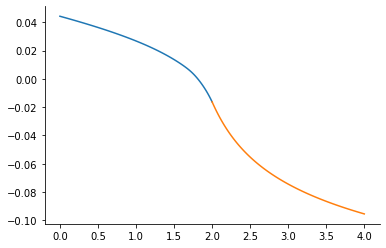

In [281]:
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_temp_list), axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
plt.plot(y_grid[:numy_bar+1], ϕ_temp)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [282]:
yt_temp, et_temp, πᵈt_temp, πᶜt_temp, ιt_temp, ht_temp = simulate_jump(y_grid[:numy_bar+1], ems_temp, πᶜ_temp, πᵈ_temp, ι_temp, h_temp, θtemp_list)

In [283]:
ξₐ = 1/4_000
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θcarb_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ)
ϕ_carb, ems_carb, πᶜ_carb, ι_carb, πᵈ_carb, h_carb, ϕ_carb_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.0017019739703526787,	 ft error: 0.00144414598378247
episode: 2,	 ode error: 0.0014383343248590141,	 ft error: 0.0013105570702616476
episode: 3,	 ode error: 0.0013267970397779585,	 ft error: 0.0012414039194658837
episode: 4,	 ode error: 0.0012602014307667058,	 ft error: 0.0011957551391640932
episode: 5,	 ode error: 0.0012109517204287978,	 ft error: 0.0011600565649760011
episode: 6,	 ode error: 0.0011709785998525878,	 ft error: 0.001129796658485793
episode: 7,	 ode error: 0.0011372205070669758,	 ft error: 0.0011033857177941105
episode: 8,	 ode error: 0.001107947066497439,	 ft error: 0.0010795563149876648
episode: 9,	 ode error: 0.001082319159774398,	 ft error: 0.001058036324052949
episode: 10,	 ode error: 0.0010595314471888487,	 ft error: 0.0010384069208600557
episode: 11,	 ode error: 0.0010390629581333642,	 ft error: 0.0010204023287612015
episode: 12,	 ode error: 0.0010204500923983015,	 ft error: 0.0010037107721251864
episode: 13,	 ode error: 0.0010035043481435

episode: 155,	 ode error: 0.00039654566923763557,	 ft error: 0.00039574505789165737
episode: 156,	 ode error: 0.0003947025109677689,	 ft error: 0.00039390852637681784
episode: 157,	 ode error: 0.00039287118356095326,	 ft error: 0.0003920837325492125
episode: 158,	 ode error: 0.0003910515634489457,	 ft error: 0.0003902705547274843
episode: 159,	 ode error: 0.0003892435291882845,	 ft error: 0.0003884688733039876
episode: 160,	 ode error: 0.00038744696140765027,	 ft error: 0.0003866785706941924
episode: 161,	 ode error: 0.00038566174275657817,	 ft error: 0.00038489953128690907
episode: 162,	 ode error: 0.0003838877578563046,	 ft error: 0.0003831316413965604
episode: 163,	 ode error: 0.0003821248932515583,	 ft error: 0.00038137478921686463
episode: 164,	 ode error: 0.0003803730373646058,	 ft error: 0.00037962886477591745
episode: 165,	 ode error: 0.00037863208044995275,	 ft error: 0.0003778937598924425
episode: 166,	 ode error: 0.000376901914550934,	 ft error: 0.00037616936813388013
episod

episode: 338,	 ode error: 0.00018395337296536458,	 ft error: 0.0001836683746408302
episode: 339,	 ode error: 0.00018323770026023982,	 ft error: 0.0001829538049510221
episode: 340,	 ode error: 0.00018252521494907656,	 ft error: 0.00018224241447211317
episode: 341,	 ode error: 0.00018181589970703315,	 ft error: 0.00018153418595433698
episode: 342,	 ode error: 0.00018110973733374152,	 ft error: 0.00018082910227178636
episode: 343,	 ode error: 0.00018040671075190897,	 ft error: 0.00018012714642060928
episode: 344,	 ode error: 0.00017970680300615893,	 ft error: 0.00017942830151817618
episode: 345,	 ode error: 0.00017900999726197856,	 ft error: 0.00017873255080155342
episode: 346,	 ode error: 0.00017831627680432022,	 ft error: 0.00017803987762683254
episode: 347,	 ode error: 0.0001776256250365844,	 ft error: 0.0001773502654673261
episode: 348,	 ode error: 0.000176938025479347,	 ft error: 0.00017666369791301262
episode: 349,	 ode error: 0.0001762534617692921,	 ft error: 0.00017598015866910252

episode: 522,	 ode error: 9.251059162131885e-05,	 ft error: 9.234093076457747e-05
episode: 523,	 ode error: 9.217816495673853e-05,	 ft error: 9.20088338104974e-05
episode: 524,	 ode error: 9.184705163245823e-05,	 ft error: 9.16780483960905e-05
episode: 525,	 ode error: 9.151724611270763e-05,	 ft error: 9.134856900248438e-05
episode: 526,	 ode error: 9.11887428954643e-05,	 ft error: 9.102039014422895e-05
episode: 527,	 ode error: 9.086153651187553e-05,	 ft error: 9.069350636883393e-05
episode: 528,	 ode error: 9.053562152604253e-05,	 ft error: 9.036791225665308e-05
episode: 529,	 ode error: 9.021099253472202e-05,	 ft error: 9.004360242030607e-05
episode: 530,	 ode error: 8.988764416685015e-05,	 ft error: 8.972057150451648e-05
episode: 531,	 ode error: 8.95655710833939e-05,	 ft error: 8.939881418564925e-05
episode: 532,	 ode error: 8.924476797659631e-05,	 ft error: 8.907832517127123e-05
episode: 533,	 ode error: 8.892522956998423e-05,	 ft error: 8.875909919978109e-05
episode: 534,	 ode e

episode: 706,	 ode error: 4.8715981290503346e-05,	 ft error: 4.858309532858781e-05
episode: 707,	 ode error: 4.8550530904196325e-05,	 ft error: 4.8417738108333386e-05
episode: 708,	 ode error: 4.838565979044772e-05,	 ft error: 4.8252959548023e-05
episode: 709,	 ode error: 4.8221365577131485e-05,	 ft error: 4.808875728519457e-05
episode: 710,	 ode error: 4.8057645910626855e-05,	 ft error: 4.792512897538089e-05
episode: 711,	 ode error: 4.789449845549751e-05,	 ft error: 4.776207229261846e-05
episode: 712,	 ode error: 4.7731920894086215e-05,	 ft error: 4.759958492831414e-05
episode: 713,	 ode error: 4.7569910926728814e-05,	 ft error: 4.743766459154586e-05
episode: 714,	 ode error: 4.7408466270875186e-05,	 ft error: 4.727630900871564e-05
episode: 715,	 ode error: 4.72475846614404e-05,	 ft error: 4.7115515923202664e-05
episode: 716,	 ode error: 4.708726385023443e-05,	 ft error: 4.695528309531701e-05
episode: 717,	 ode error: 4.692750160570662e-05,	 ft error: 4.6795608301790824e-05
episode: 

episode: 890,	 ode error: 2.6148512861186605e-05,	 ft error: 2.602709557801101e-05
episode: 891,	 ode error: 2.6060695506990817e-05,	 ft error: 2.5939320392071957e-05
episode: 892,	 ode error: 2.5973178065431964e-05,	 ft error: 2.585184495779158e-05
episode: 893,	 ode error: 2.5885959499921804e-05,	 ft error: 2.576466823907738e-05
episode: 894,	 ode error: 2.5799038777751804e-05,	 ft error: 2.567778920393079e-05
episode: 895,	 ode error: 2.571241486954768e-05,	 ft error: 2.559120682349888e-05
episode: 896,	 ode error: 2.562608674974839e-05,	 ft error: 2.5504920072698854e-05
episode: 897,	 ode error: 2.5540053396126282e-05,	 ft error: 2.541892793017179e-05
episode: 898,	 ode error: 2.545431379029307e-05,	 ft error: 2.5333229377935695e-05
episode: 899,	 ode error: 2.5368866917189516e-05,	 ft error: 2.5247823401616798e-05
episode: 900,	 ode error: 2.528371176543215e-05,	 ft error: 2.5162708990403293e-05
episode: 901,	 ode error: 2.5198847327129073e-05,	 ft error: 2.5077885136999083e-05
ep

episode: 1074,	 ode error: 1.4128905164761257e-05,	 ft error: 1.4013064493316001e-05
episode: 1075,	 ode error: 1.4081996785373632e-05,	 ft error: 1.3966176918798572e-05
episode: 1076,	 ode error: 1.4035247370144683e-05,	 ft error: 1.3919448228483233e-05
episode: 1077,	 ode error: 1.398865637348588e-05,	 ft error: 1.3872877877111705e-05
episode: 1078,	 ode error: 1.3942223251878216e-05,	 ft error: 1.382646532141485e-05
episode: 1079,	 ode error: 1.3895947463609076e-05,	 ft error: 1.3780210020135816e-05
episode: 1080,	 ode error: 1.3849828468909817e-05,	 ft error: 1.3734111433590565e-05
episode: 1081,	 ode error: 1.380386572979043e-05,	 ft error: 1.3688169024269245e-05
episode: 1082,	 ode error: 1.3758058710210412e-05,	 ft error: 1.3642382256373597e-05
episode: 1083,	 ode error: 1.3712406875962969e-05,	 ft error: 1.3596750595955739e-05
episode: 1084,	 ode error: 1.3666909694669705e-05,	 ft error: 1.3551273511010672e-05
episode: 1085,	 ode error: 1.3621566635941412e-05,	 ft error: 1.3505

episode: 1258,	 ode error: 7.694499812450364e-06,	 ft error: 7.581406199358431e-06
episode: 1259,	 ode error: 7.669320022232534e-06,	 ft error: 7.556236639172376e-06
episode: 1260,	 ode error: 7.644224890848684e-06,	 ft error: 7.531151698381144e-06
episode: 1261,	 ode error: 7.619214130102914e-06,	 ft error: 7.506151088835604e-06
episode: 1262,	 ode error: 7.594287452603694e-06,	 ft error: 7.481234523358064e-06
episode: 1263,	 ode error: 7.569444572178572e-06,	 ft error: 7.456401715973579e-06
episode: 1264,	 ode error: 7.544685203516276e-06,	 ft error: 7.431652381401088e-06
episode: 1265,	 ode error: 7.5200090621837384e-06,	 ft error: 7.406986235539148e-06
episode: 1266,	 ode error: 7.495415865032347e-06,	 ft error: 7.382402995211498e-06
episode: 1267,	 ode error: 7.470905329593283e-06,	 ft error: 7.357902378167062e-06
episode: 1268,	 ode error: 7.446477174564764e-06,	 ft error: 7.333484103288121e-06
episode: 1269,	 ode error: 7.422131119518005e-06,	 ft error: 7.3091478901970985e-06
ep

episode: 1442,	 ode error: 4.233025455114225e-06,	 ft error: 4.121280752801086e-06
episode: 1443,	 ode error: 4.219442874224999e-06,	 ft error: 4.107703186368809e-06
episode: 1444,	 ode error: 4.2059056021919415e-06,	 ft error: 4.094170909403154e-06
episode: 1445,	 ode error: 4.1924134859371975e-06,	 ft error: 4.08068376885525e-06
episode: 1446,	 ode error: 4.178966372932495e-06,	 ft error: 4.0672416122313395e-06
episode: 1447,	 ode error: 4.165564111125635e-06,	 ft error: 4.053844287662164e-06
episode: 1448,	 ode error: 4.152206549126324e-06,	 ft error: 4.04049164362541e-06
episode: 1449,	 ode error: 4.1388935358093555e-06,	 ft error: 4.027183529362044e-06
episode: 1450,	 ode error: 4.12562492084316e-06,	 ft error: 4.013919794390586e-06
episode: 1451,	 ode error: 4.1124005541586526e-06,	 ft error: 4.000700288761538e-06
episode: 1452,	 ode error: 4.099220286474421e-06,	 ft error: 3.987524863265554e-06
episode: 1453,	 ode error: 4.086083968734026e-06,	 ft error: 3.974393369017097e-06
ep

episode: 1626,	 ode error: 2.3617886611055922e-06,	 ft error: 2.2507041874675338e-06
episode: 1627,	 ode error: 2.3544265264806774e-06,	 ft error: 2.2433445021757814e-06
episode: 1628,	 ode error: 2.3470887607493843e-06,	 ft error: 2.236009176264283e-06
episode: 1629,	 ode error: 2.339775282295467e-06,	 ft error: 2.2286981280622564e-06
episode: 1630,	 ode error: 2.332486009699896e-06,	 ft error: 2.221411276315255e-06
episode: 1631,	 ode error: 2.3252208618248843e-06,	 ft error: 2.2141485397919602e-06
episode: 1632,	 ode error: 2.3179797577944786e-06,	 ft error: 2.2069098378392957e-06
episode: 1633,	 ode error: 2.310762617044218e-06,	 ft error: 2.199695089688536e-06
episode: 1634,	 ode error: 2.3035693592877386e-06,	 ft error: 2.1925042151954566e-06
episode: 1635,	 ode error: 2.296399904603511e-06,	 ft error: 2.1853371345165185e-06
episode: 1636,	 ode error: 2.289254173060899e-06,	 ft error: 2.1781937677156638e-06
episode: 1637,	 ode error: 2.2821320852628012e-06,	 ft error: 2.171074035

episode: 113,	 ode error: 0.00048644653155382957,	 ft error: 0.0004851313599486355
episode: 114,	 ode error: 0.0004839671916817361,	 ft error: 0.0004826661156734936
episode: 115,	 ode error: 0.00048150624704743647,	 ft error: 0.00048021890005170203
episode: 116,	 ode error: 0.0004790633560227082,	 ft error: 0.0004777893789835337
episode: 117,	 ode error: 0.0004766381778738134,	 ft error: 0.00047537721859679943
episode: 118,	 ode error: 0.000474230372598862,	 ft error: 0.0004729820851696413
episode: 119,	 ode error: 0.00047183960080394104,	 ft error: 0.00047060364508825136
episode: 120,	 ode error: 0.0004694655236176325,	 ft error: 0.00046824156483313284
episode: 121,	 ode error: 0.00046710780264380496,	 ft error: 0.00046589551100035637
episode: 122,	 ode error: 0.0004647660999531507,	 ft error: 0.0004635651503561572
episode: 123,	 ode error: 0.0004624400781136946,	 ft error: 0.0004612501499276963
episode: 124,	 ode error: 0.0004601294002605354,	 ft error: 0.0004589501771280295
episode:

episode: 277,	 ode error: 0.00020116272378493006,	 ft error: 0.00020061331935774623
episode: 278,	 ode error: 0.0002000101789028085,	 ft error: 0.0001994706821742409
episode: 279,	 ode error: 0.0001988637066296892,	 ft error: 0.00019833451601105243
episode: 280,	 ode error: 0.0001977232602627236,	 ft error: 0.0001972048610479384
episode: 281,	 ode error: 0.00019658878622705225,	 ft error: 0.00019608177502875487
episode: 282,	 ode error: 0.00019546022245218585,	 ft error: 0.00019496534223090167
episode: 283,	 ode error: 0.00019433749601606713,	 ft error: 0.00019385568785728244
episode: 284,	 ode error: 0.0001932205196463081,	 ft error: 0.0001927530022046801
episode: 285,	 ode error: 0.00019210918635692174,	 ft error: 0.00019165758348575296
episode: 286,	 ode error: 0.00019100336087957105,	 ft error: 0.00019056991873371565
episode: 287,	 ode error: 0.00018990286521964413,	 ft error: 0.00018949084945587188
episode: 288,	 ode error: 0.00018880780749332962,	 ft error: 0.00018830363001307027

episode: 447,	 ode error: 7.699217010708511e-05,	 ft error: 7.672506610584737e-05
episode: 448,	 ode error: 7.656329440510758e-05,	 ft error: 7.629772245850339e-05
episode: 449,	 ode error: 7.61367657188402e-05,	 ft error: 7.58727126475937e-05
episode: 450,	 ode error: 7.571257177537989e-05,	 ft error: 7.54500246034212e-05
episode: 451,	 ode error: 7.529070034141105e-05,	 ft error: 7.502964628954926e-05
episode: 452,	 ode error: 7.487113922427806e-05,	 ft error: 7.46115657042588e-05
episode: 453,	 ode error: 7.445387627308614e-05,	 ft error: 7.419577088188986e-05
episode: 454,	 ode error: 7.403889937962927e-05,	 ft error: 7.378224989418314e-05
episode: 455,	 ode error: 7.362619647930215e-05,	 ft error: 7.337099085122831e-05
episode: 456,	 ode error: 7.321575555190897e-05,	 ft error: 7.296198190257416e-05
episode: 457,	 ode error: 7.280756462243467e-05,	 ft error: 7.255521123840833e-05
episode: 458,	 ode error: 7.24016117616866e-05,	 ft error: 7.21506670901817e-05
episode: 459,	 ode err

episode: 626,	 ode error: 2.8202114253504836e-05,	 ft error: 2.7980083114354886e-05
episode: 627,	 ode error: 2.8042798066742073e-05,	 ft error: 2.7820205196367003e-05
episode: 628,	 ode error: 2.7884317362761334e-05,	 ft error: 2.766116484684278e-05
episode: 629,	 ode error: 2.772666781141798e-05,	 ft error: 2.750295773262801e-05
episode: 630,	 ode error: 2.756984509687916e-05,	 ft error: 2.734557953465444e-05
episode: 631,	 ode error: 2.7413844917980744e-05,	 ft error: 2.718902594847176e-05
episode: 632,	 ode error: 2.7258662988427452e-05,	 ft error: 2.703329268436324e-05
episode: 633,	 ode error: 2.7104295037136774e-05,	 ft error: 2.6878375467484505e-05
episode: 634,	 ode error: 2.6950736808477706e-05,	 ft error: 2.6724270038210506e-05
episode: 635,	 ode error: 2.679798406266475e-05,	 ft error: 2.657097215282937e-05
episode: 636,	 ode error: 2.664603257596413e-05,	 ft error: 2.6418477583311138e-05
episode: 637,	 ode error: 2.6494878140955955e-05,	 ft error: 2.626678211779347e-05
epi

episode: 810,	 ode error: 1.3559571717589744e-05,	 ft error: 1.4788637231974896e-05
episode: 811,	 ode error: 1.3522255494103694e-05,	 ft error: 1.4750933520953543e-05
episode: 812,	 ode error: 1.3485028475290292e-05,	 ft error: 1.4713321690451586e-05
episode: 813,	 ode error: 1.3447890467984012e-05,	 ft error: 1.4675801475530492e-05
episode: 814,	 ode error: 1.3410841279500092e-05,	 ft error: 1.4638372612847672e-05
episode: 815,	 ode error: 1.337388071762659e-05,	 ft error: 1.4601034839800686e-05
episode: 816,	 ode error: 1.3337008590625957e-05,	 ft error: 1.4563787895463995e-05
episode: 817,	 ode error: 1.3300224707230956e-05,	 ft error: 1.4526631519721594e-05
episode: 818,	 ode error: 1.3263528876642864e-05,	 ft error: 1.4489565453949343e-05
episode: 819,	 ode error: 1.3226920908529703e-05,	 ft error: 1.4452589440656454e-05
episode: 820,	 ode error: 1.3190400613022194e-05,	 ft error: 1.4415703223751483e-05
episode: 821,	 ode error: 1.3153967800713025e-05,	 ft error: 1.43789065484729

episode: 993,	 ode error: 8.038397047240687e-06,	 ft error: 9.221214531974591e-06
episode: 994,	 ode error: 8.014526859604888e-06,	 ft error: 9.197259403804134e-06
episode: 995,	 ode error: 7.990715773248408e-06,	 ft error: 9.173364212538653e-06
episode: 996,	 ode error: 7.966963651807966e-06,	 ft error: 9.149528786914681e-06
episode: 997,	 ode error: 7.943270359269533e-06,	 ft error: 9.12575295685993e-06
episode: 998,	 ode error: 7.919635759963991e-06,	 ft error: 9.102036553678325e-06
episode: 999,	 ode error: 7.89605971856521e-06,	 ft error: 9.078379409969048e-06
episode: 1000,	 ode error: 7.872542100088826e-06,	 ft error: 9.054781359534025e-06
episode: 1001,	 ode error: 7.849082769886714e-06,	 ft error: 9.03124223752827e-06
episode: 1002,	 ode error: 7.825681593644467e-06,	 ft error: 9.0077618805177e-06
episode: 1003,	 ode error: 7.802338437380582e-06,	 ft error: 8.984340126247844e-06
episode: 1004,	 ode error: 7.779053167440199e-06,	 ft error: 8.960976813909838e-06
episode: 1005,	 

episode: 1177,	 ode error: 4.514786022572067e-06,	 ft error: 5.6870666010252115e-06
episode: 1178,	 ode error: 4.499766948019211e-06,	 ft error: 5.672016504936854e-06
episode: 1179,	 ode error: 4.484786171524765e-06,	 ft error: 5.657004974469101e-06
episode: 1180,	 ode error: 4.469843600496913e-06,	 ft error: 5.642031915808107e-06
episode: 1181,	 ode error: 4.454939142548893e-06,	 ft error: 5.627097234966553e-06
episode: 1182,	 ode error: 4.440072705497687e-06,	 ft error: 5.6122008383156325e-06
episode: 1183,	 ode error: 4.425244197363244e-06,	 ft error: 5.597342632550351e-06
episode: 1184,	 ode error: 4.4104535263668726e-06,	 ft error: 5.582522524446669e-06
episode: 1185,	 ode error: 4.395700600932169e-06,	 ft error: 5.567740421000278e-06
episode: 1186,	 ode error: 4.380985329684769e-06,	 ft error: 5.552996229542251e-06
episode: 1187,	 ode error: 4.366307621454167e-06,	 ft error: 5.53828985699889e-06
episode: 1188,	 ode error: 4.351667385266882e-06,	 ft error: 5.5236212115108065e-06
e

episode: 1361,	 ode error: 2.3103237871797088e-06,	 ft error: 3.480121239160065e-06
episode: 1362,	 ode error: 2.3009846199401344e-06,	 ft error: 3.4707806931151093e-06
episode: 1363,	 ode error: 2.2916697889093895e-06,	 ft error: 3.4614645690276653e-06
episode: 1364,	 ode error: 2.282379233201255e-06,	 ft error: 3.4521728050721885e-06
episode: 1365,	 ode error: 2.2731128920708645e-06,	 ft error: 3.442905340197977e-06
episode: 1366,	 ode error: 2.26387070491522e-06,	 ft error: 3.433662113157728e-06
episode: 1367,	 ode error: 2.254652611275793e-06,	 ft error: 3.4244430629007394e-06
episode: 1368,	 ode error: 2.2454585508342696e-06,	 ft error: 3.4152481286191714e-06
episode: 1369,	 ode error: 2.2362884634133363e-06,	 ft error: 3.4060772494820535e-06
episode: 1370,	 ode error: 2.2271422889775475e-06,	 ft error: 3.3969303650284908e-06
episode: 1371,	 ode error: 2.2180199676315637e-06,	 ft error: 3.387807414681939e-06
episode: 1372,	 ode error: 2.2089214396221843e-06,	 ft error: 3.378708338

episode: 1545,	 ode error: 2.332760366216785e-06,	 ft error: 2.116066709241064e-06
episode: 1546,	 ode error: 2.334846103224967e-06,	 ft error: 2.1103199148118463e-06
episode: 1547,	 ode error: 2.336929003662544e-06,	 ft error: 2.1045883892451917e-06
episode: 1548,	 ode error: 2.3390090634454346e-06,	 ft error: 2.098872093556081e-06
episode: 1549,	 ode error: 2.3410862785599768e-06,	 ft error: 2.0931709883431626e-06
episode: 1550,	 ode error: 2.3431606450610297e-06,	 ft error: 2.087485034552028e-06
episode: 1551,	 ode error: 2.3452321590678544e-06,	 ft error: 2.0818141929779266e-06
episode: 1552,	 ode error: 2.347300816765523e-06,	 ft error: 2.0761584246358398e-06
episode: 1553,	 ode error: 2.3493666144052436e-06,	 ft error: 2.0705176907257856e-06
episode: 1554,	 ode error: 2.3514295483026263e-06,	 ft error: 2.064891952632819e-06
episode: 1555,	 ode error: 2.3534896148357854e-06,	 ft error: 2.0592811713603574e-06
episode: 1556,	 ode error: 2.3555468104484835e-06,	 ft error: 2.053685308

episode: 127,	 ode error: 0.0006636727812274761,	 ft error: 0.0006638702392323023
episode: 128,	 ode error: 0.0006616929072683954,	 ft error: 0.0006618853056145995
episode: 129,	 ode error: 0.0006597189523645948,	 ft error: 0.0006599064063092519
episode: 130,	 ode error: 0.0006577508985422903,	 ft error: 0.0006579335167741323
episode: 131,	 ode error: 0.0006557887278989803,	 ft error: 0.0006559666131620892
episode: 132,	 ode error: 0.0006538324226015236,	 ft error: 0.0006540056722704098
episode: 133,	 ode error: 0.0006518819648842032,	 ft error: 0.000652050671543572
episode: 134,	 ode error: 0.0006499373370471087,	 ft error: 0.0006501015889687444
episode: 135,	 ode error: 0.0006479985214544045,	 ft error: 0.0006481584031120767
episode: 136,	 ode error: 0.0006460655005328172,	 ft error: 0.0006462210930462583
episode: 137,	 ode error: 0.0006441382567701796,	 ft error: 0.0006442896383316438
episode: 138,	 ode error: 0.0006422167727141002,	 ft error: 0.0006423640189735329
episode: 139,	 od

episode: 290,	 ode error: 0.0004078765224097915,	 ft error: 0.00040764849721824003
episode: 291,	 ode error: 0.000406660742962692,	 ft error: 0.00040643260281939453
episode: 292,	 ode error: 0.00040544858958949743,	 ft error: 0.0004052203540171745
episode: 293,	 ode error: 0.000404240051420681,	 ft error: 0.000404011739284435
episode: 294,	 ode error: 0.0004030351176210202,	 ft error: 0.0004028067471512307
episode: 295,	 ode error: 0.0004018337773894242,	 ft error: 0.00040160536620433007
episode: 296,	 ode error: 0.0004006360199587751,	 ft error: 0.00040040758508423185
episode: 297,	 ode error: 0.0003994418345957593,	 ft error: 0.000399213392487871
episode: 298,	 ode error: 0.0003982512106007149,	 ft error: 0.00039802277716320666
episode: 299,	 ode error: 0.0003970641373074636,	 ft error: 0.0003968357279139634
episode: 300,	 ode error: 0.0003958806040831747,	 ft error: 0.0003956522335901251
episode: 301,	 ode error: 0.0003947006003282011,	 ft error: 0.00039447228309596094
episode: 302,

episode: 456,	 ode error: 0.0002485028546065335,	 ft error: 0.00024833070815420227
episode: 457,	 ode error: 0.0002477622095016888,	 ft error: 0.00024759043660861163
episode: 458,	 ode error: 0.0002470237721551179,	 ft error: 0.0002468523718012391
episode: 459,	 ode error: 0.00024628753598588803,	 ft error: 0.0002461165071469355
episode: 460,	 ode error: 0.0002455534944326972,	 ft error: 0.00024538283608215494
episode: 461,	 ode error: 0.0002448216409538181,	 ft error: 0.00024465135206180877
episode: 462,	 ode error: 0.00024409196902703894,	 ft error: 0.00024392204856088506
episode: 463,	 ode error: 0.00024336447214960656,	 ft error: 0.00024319491907421703
episode: 464,	 ode error: 0.0002426391438381635,	 ft error: 0.00024246995711639058
episode: 465,	 ode error: 0.00024191597762869674,	 ft error: 0.0002417471562202178
episode: 466,	 ode error: 0.00024119496707647133,	 ft error: 0.00024102650993942007
episode: 467,	 ode error: 0.00024047610575597808,	 ft error: 0.00024030801184677747
e

episode: 622,	 ode error: 0.00015140933637485085,	 ft error: 0.0001512853348492142
episode: 623,	 ode error: 0.00015095811909371208,	 ft error: 0.00015083433118442957
episode: 624,	 ode error: 0.0001505082469019385,	 ft error: 0.00015038467182829085
episode: 625,	 ode error: 0.00015005971579040082,	 ft error: 0.00014993635277395687
episode: 626,	 ode error: 0.00014961252176191756,	 ft error: 0.0001494893700267989
episode: 627,	 ode error: 0.0001491666608312177,	 ft error: 0.00014904371960458573
episode: 628,	 ode error: 0.00014872212902491164,	 ft error: 0.00014859939753567958
episode: 629,	 ode error: 0.00014827892238144754,	 ft error: 0.00014815639986153392
episode: 630,	 ode error: 0.0001478370369510819,	 ft error: 0.00014771472263465832
episode: 631,	 ode error: 0.00014739646879584193,	 ft error: 0.00014727436191972848
episode: 632,	 ode error: 0.00014695721398949157,	 ft error: 0.00014683531379293865
episode: 633,	 ode error: 0.00014651926861749566,	 ft error: 0.000146397574341955

episode: 788,	 ode error: 9.225873828078287e-05,	 ft error: 9.216125124685467e-05
episode: 789,	 ode error: 9.198385654255619e-05,	 ft error: 9.188648445924523e-05
episode: 790,	 ode error: 9.170979429637578e-05,	 ft error: 9.16125367326585e-05
episode: 791,	 ode error: 9.143654909949241e-05,	 ft error: 9.133940562645419e-05
episode: 792,	 ode error: 9.116411851643844e-05,	 ft error: 9.106708870665337e-05
episode: 793,	 ode error: 9.089250011900597e-05,	 ft error: 9.079558354626224e-05
episode: 794,	 ode error: 9.062169148621967e-05,	 ft error: 9.052488772684497e-05
episode: 795,	 ode error: 9.035169020432318e-05,	 ft error: 9.025499883523932e-05
episode: 796,	 ode error: 9.008249386675067e-05,	 ft error: 8.998591446762738e-05
episode: 797,	 ode error: 8.98141000741108e-05,	 ft error: 8.971763222527981e-05
episode: 798,	 ode error: 8.954650643416145e-05,	 ft error: 8.945014971774765e-05
episode: 799,	 ode error: 8.927971056179023e-05,	 ft error: 8.918346456216845e-05
episode: 800,	 ode

episode: 953,	 ode error: 5.6392734944314335e-05,	 ft error: 5.630945320643048e-05
episode: 954,	 ode error: 5.6224782200210645e-05,	 ft error: 5.614156306209724e-05
episode: 955,	 ode error: 5.605733019862743e-05,	 ft error: 5.597417343577068e-05
episode: 956,	 ode error: 5.5890377446796645e-05,	 ft error: 5.580728283665256e-05
episode: 957,	 ode error: 5.5723922456400146e-05,	 ft error: 5.564088977644266e-05
episode: 958,	 ode error: 5.555796374355731e-05,	 ft error: 5.547499277220684e-05
episode: 959,	 ode error: 5.5392499828808145e-05,	 ft error: 5.5309590345683134e-05
episode: 960,	 ode error: 5.5227529237103284e-05,	 ft error: 5.514468102277292e-05
episode: 961,	 ode error: 5.506305049779003e-05,	 ft error: 5.498026333330963e-05
episode: 962,	 ode error: 5.489906214459835e-05,	 ft error: 5.481633581193764e-05
episode: 963,	 ode error: 5.473556271562983e-05,	 ft error: 5.4652896997695974e-05
episode: 964,	 ode error: 5.457255075334204e-05,	 ft error: 5.448994543401827e-05
episode:

episode: 1119,	 ode error: 3.437628689144834e-05,	 ft error: 3.430088831163358e-05
episode: 1120,	 ode error: 3.4273976610681677e-05,	 ft error: 3.4198613143669274e-05
episode: 1121,	 ode error: 3.4171971377732315e-05,	 ft error: 3.4096642905582605e-05
episode: 1122,	 ode error: 3.407027028314914e-05,	 ft error: 3.3994976687360775e-05
episode: 1123,	 ode error: 3.39688724201898e-05,	 ft error: 3.389361358338561e-05
episode: 1124,	 ode error: 3.38677768848153e-05,	 ft error: 3.379255268993557e-05
episode: 1125,	 ode error: 3.376698277568219e-05,	 ft error: 3.369179310583337e-05
episode: 1126,	 ode error: 3.366648919413172e-05,	 ft error: 3.3591333933278664e-05
episode: 1127,	 ode error: 3.356629524418745e-05,	 ft error: 3.3491174276321464e-05
episode: 1128,	 ode error: 3.3466400032540955e-05,	 ft error: 3.3391313242157425e-05
episode: 1129,	 ode error: 3.33668026685479e-05,	 ft error: 3.329174994075775e-05
episode: 1130,	 ode error: 3.3267502264219167e-05,	 ft error: 3.3192483484360366e

episode: 1284,	 ode error: 2.1027366218805566e-05,	 ft error: 2.0956437074790928e-05
episode: 1285,	 ode error: 2.0964857689617948e-05,	 ft error: 2.0893948980046005e-05
episode: 1286,	 ode error: 2.0902535542091302e-05,	 ft error: 2.0831647202235182e-05
episode: 1287,	 ode error: 2.084039922052583e-05,	 ft error: 2.076953118509047e-05
episode: 1288,	 ode error: 2.0778448170875787e-05,	 ft error: 2.0707600375489504e-05
episode: 1289,	 ode error: 2.0716681840749276e-05,	 ft error: 2.064585422105007e-05
episode: 1290,	 ode error: 2.0655099679401084e-05,	 ft error: 2.0584292171194063e-05
episode: 1291,	 ode error: 2.0593701137726177e-05,	 ft error: 2.0522913677240018e-05
episode: 1292,	 ode error: 2.0532485668259054e-05,	 ft error: 2.046171819143165e-05
episode: 1293,	 ode error: 2.047145272516442e-05,	 ft error: 2.0400705168880744e-05
episode: 1294,	 ode error: 2.04106017642348e-05,	 ft error: 2.0339874065069173e-05
episode: 1295,	 ode error: 2.034993224288577e-05,	 ft error: 2.027922433

episode: 1449,	 ode error: 1.3435923618380067e-05,	 ft error: 1.2803338316121534e-05
episode: 1450,	 ode error: 1.3415039052162555e-05,	 ft error: 1.2765160251707968e-05
episode: 1451,	 ode error: 1.3394211068461045e-05,	 ft error: 1.2727096024983675e-05
episode: 1452,	 ode error: 1.3373439520452323e-05,	 ft error: 1.2689145296359191e-05
episode: 1453,	 ode error: 1.3352724261663801e-05,	 ft error: 1.2651307727401528e-05
episode: 1454,	 ode error: 1.3332065145973933e-05,	 ft error: 1.2613582980834186e-05
episode: 1455,	 ode error: 1.331146202760939e-05,	 ft error: 1.2575970720305845e-05
episode: 1456,	 ode error: 1.3290914761143427e-05,	 ft error: 1.2538470610297855e-05
episode: 1457,	 ode error: 1.3270423201499127e-05,	 ft error: 1.250108231649431e-05
episode: 1458,	 ode error: 1.3249987203947366e-05,	 ft error: 1.2463805505597003e-05
episode: 1459,	 ode error: 1.3229606624103126e-05,	 ft error: 1.2426639845094142e-05
episode: 1460,	 ode error: 1.3209281317927292e-05,	 ft error: 1.238

episode: 1614,	 ode error: 1.0657391970487362e-05,	 ft error: 7.822116918400809e-06
episode: 1615,	 ode error: 1.064409488357206e-05,	 ft error: 7.798791826080231e-06
episode: 1616,	 ode error: 1.0630834411701126e-05,	 ft error: 7.775536285068812e-06
episode: 1617,	 ode error: 1.0617610457117998e-05,	 ft error: 7.752350088818805e-06
episode: 1618,	 ode error: 1.0604422922310967e-05,	 ft error: 7.729233029394694e-06
episode: 1619,	 ode error: 1.0591271710019475e-05,	 ft error: 7.706184901636512e-06
episode: 1620,	 ode error: 1.0578156723226955e-05,	 ft error: 7.683205499551631e-06
episode: 1621,	 ode error: 1.056507786516162e-05,	 ft error: 7.660294618303903e-06
episode: 1622,	 ode error: 1.0552035039296117e-05,	 ft error: 7.637452053843585e-06
episode: 1623,	 ode error: 1.0539028149349471e-05,	 ft error: 7.614677601843386e-06
episode: 1624,	 ode error: 1.052605709928118e-05,	 ft error: 7.591971060011415e-06
episode: 1625,	 ode error: 1.0513121793296352e-05,	 ft error: 7.569332225084343

episode: 1779,	 ode error: 8.893756637991297e-06,	 ft error: 4.7788303889073624e-06
episode: 1780,	 ode error: 8.885344326543054e-06,	 ft error: 4.764579967925231e-06
episode: 1781,	 ode error: 8.876955461100134e-06,	 ft error: 4.750372039989219e-06
episode: 1782,	 ode error: 8.86858997780575e-06,	 ft error: 4.736206478903974e-06
episode: 1783,	 ode error: 8.860247812970844e-06,	 ft error: 4.7220831578727775e-06
episode: 1784,	 ode error: 8.851928903075514e-06,	 ft error: 4.7080019513016475e-06
episode: 1785,	 ode error: 8.843633184762089e-06,	 ft error: 4.693962733504087e-06
episode: 1786,	 ode error: 8.835360594844499e-06,	 ft error: 4.679965379071153e-06
episode: 1787,	 ode error: 8.827111070300659e-06,	 ft error: 4.666009763287793e-06
episode: 1788,	 ode error: 8.818884548272827e-06,	 ft error: 4.652095761994065e-06
episode: 1789,	 ode error: 8.81068096606702e-06,	 ft error: 4.638223250659953e-06
episode: 1790,	 ode error: 8.80250026115617e-06,	 ft error: 4.624392105911923e-06
epis

episode: 1943,	 ode error: 8.58808404439546e-06,	 ft error: 2.928280583800828e-06
episode: 1944,	 ode error: 8.593355181036306e-06,	 ft error: 2.9195483571923626e-06
episode: 1945,	 ode error: 8.598611520304502e-06,	 ft error: 2.9108421697547166e-06
episode: 1946,	 ode error: 8.603853102968136e-06,	 ft error: 2.9021619436797597e-06
episode: 1947,	 ode error: 8.609079969677702e-06,	 ft error: 2.8935076015756955e-06
episode: 1948,	 ode error: 8.61429216097309e-06,	 ft error: 2.884879066189505e-06
episode: 1949,	 ode error: 8.61948971729343e-06,	 ft error: 2.8762762609158e-06
episode: 1950,	 ode error: 8.624672678965323e-06,	 ft error: 2.867699108501561e-06
episode: 1951,	 ode error: 8.62984108620592e-06,	 ft error: 2.8591475329427705e-06
episode: 1952,	 ode error: 8.634994979130214e-06,	 ft error: 2.8506214575877804e-06
episode: 1953,	 ode error: 8.64013439774063e-06,	 ft error: 2.8421208065713506e-06
episode: 1954,	 ode error: 8.645259381937162e-06,	 ft error: 2.833645504213278e-06
epis

episode: 36,	 ode error: 0.024920611653085754,	 ft error: 0.024922918359514178
episode: 37,	 ode error: 0.024847049330822654,	 ft error: 0.02484962983609451
episode: 38,	 ode error: 0.02477371777249751,	 ft error: 0.02477276110635529
episode: 39,	 ode error: 0.02470059570454148,	 ft error: 0.024702684886978393
episode: 40,	 ode error: 0.024627692312849527,	 ft error: 0.02463006332659686
episode: 41,	 ode error: 0.024555015000421742,	 ft error: 0.024554757789604736
episode: 42,	 ode error: 0.0244825594546633,	 ft error: 0.02448065409403529
episode: 43,	 ode error: 0.024410309063984066,	 ft error: 0.024412163104314082
episode: 44,	 ode error: 0.024338276397800115,	 ft error: 0.02433992884128896
episode: 45,	 ode error: 0.024266464376996522,	 ft error: 0.024266395378405768
episode: 46,	 ode error: 0.02419486982013693,	 ft error: 0.02419379264411529
episode: 47,	 ode error: 0.024123490936789907,	 ft error: 0.02412184458191987
episode: 48,	 ode error: 0.024052326261219514,	 ft error: 0.0240

episode: 215,	 ode error: 0.014717243182673739,	 ft error: 0.014718896633516184
episode: 216,	 ode error: 0.014674310676107846,	 ft error: 0.014675982054592012
episode: 217,	 ode error: 0.014631510192033362,	 ft error: 0.014633199819083694
episode: 218,	 ode error: 0.014588841493749342,	 ft error: 0.01459054969793816
episode: 219,	 ode error: 0.014546304354377291,	 ft error: 0.014548031471481501
episode: 220,	 ode error: 0.014503898557486742,	 ft error: 0.014505644929881564
episode: 221,	 ode error: 0.014461623897774924,	 ft error: 0.014463389873656437
episode: 222,	 ode error: 0.014419480181805704,	 ft error: 0.014421266114192182
episode: 223,	 ode error: 0.01437746722881374,	 ft error: 0.01437927347428795
episode: 224,	 ode error: 0.014335584871580195,	 ft error: 0.014337411788722573
episode: 225,	 ode error: 0.01429383295738724,	 ft error: 0.014295680904829652
episode: 226,	 ode error: 0.014252211349059168,	 ft error: 0.014254080683104853
episode: 227,	 ode error: 0.0142107199260988

episode: 402,	 ode error: 0.009314681833344435,	 ft error: 0.00937206736083173
episode: 403,	 ode error: 0.009061763752185986,	 ft error: 0.009131523507320851
episode: 404,	 ode error: 0.00824343131899903,	 ft error: 0.008326485811112928
episode: 405,	 ode error: 0.006054763826688428,	 ft error: 0.006142770875733235
episode: 406,	 ode error: 0.0022305945116454767,	 ft error: 0.0022796933769642326
episode: 407,	 ode error: 7.565591759731208e-05,	 ft error: 7.940056350837453e-05
episode: 408,	 ode error: 5.2344067490906485e-05,	 ft error: 5.1534564634349765e-05
episode: 409,	 ode error: 5.176306120159883e-05,	 ft error: 5.095951423191488e-05
episode: 410,	 ode error: 5.120731167228363e-05,	 ft error: 5.0404718366532195e-05
episode: 411,	 ode error: 5.066614444933085e-05,	 ft error: 4.986270120554045e-05
episode: 412,	 ode error: 5.013492468918066e-05,	 ft error: 4.9329906887061556e-05
episode: 413,	 ode error: 4.961153805885276e-05,	 ft error: 4.8804579515412026e-05
episode: 414,	 ode er

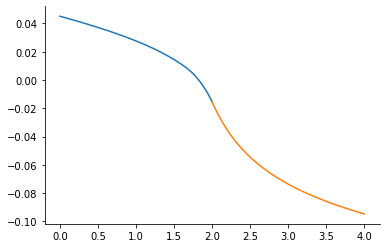

In [284]:
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_carb_list), axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
plt.plot(y_grid[:numy_bar+1], ϕ_carb)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [285]:
yt_carb, et_carb, πᵈt_carb, πᶜt_carb, ιt_carb, ht_carb = simulate_jump(y_grid[:numy_bar+1], ems_carb, πᶜ_carb, πᵈ_carb, ι_carb, h_carb,  θcarb_list)

Text(0.5, 0, 'years')

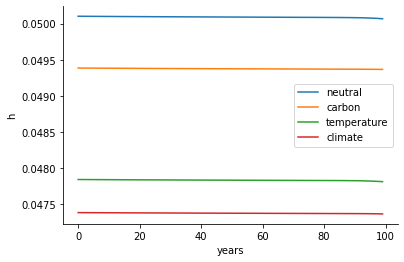

In [286]:
plt.plot(ht[ht>0], label="neutral")
plt.plot(ht_carb[ht_carb>0], label = "carbon")
plt.plot(ht_temp[ht_temp>0], label = "temperature")
plt.plot(ht_avg[ht_avg>0], label = "climate")
plt.legend()
plt.ylabel('h')
plt.xlabel('years')
# plt.ylim(0,0.0035)

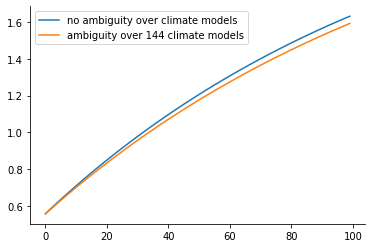

In [292]:
plt.plot(yt[yt>0],label="no ambiguity over climate models")
# plt.plot(yt_carb[yt_carb>0],label="ambiguity over carbon models")
# plt.plot(yt_temp[yt_temp>0],label="ambiguity over temperature models")
plt.plot(yt_avg[yt_avg>0],label="ambiguity over 144 climate models")
plt.legend()

(0.0, 100.0)

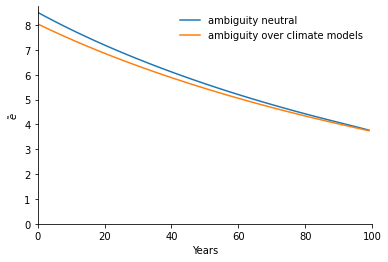

In [289]:
plt.plot(et[et>0], label="ambiguity neutral")
# plt.plot(et_carb[et_carb>0], label="ambiguity over carbon models")
# plt.plot(et_temp[et_temp>0], label="ambiguity over temperature models")
plt.plot(et_avg[et_avg>0], label="ambiguity over climate models")
plt.legend(frameon=False)
plt.ylabel("$\\tilde e$")
plt.xlabel('Years')
plt.ylim(bottom=0)
plt.xlim(0,100)
# plt.savefig("../figures/ems_partition_damage.png", facecolor='w', edgecolor='w',bbox_inches="tight")

## Approach two:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j: \sum_j g_j \hat \pi_j=1} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta + \mathcal{I}(y)\sum_j\hat\pi_j g_j\left[\phi_j(y) - \phi(y) \right] \\
&  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j g_j \log g_j
\end{aligned}
$$
Minimize over $g_j$ gives:
$$
g_j = \cfrac{\exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right)}{\sum_{j} \hat\pi_j \exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right)}
$$
Plug back in:
$$
\begin{aligned}
0 = \max_{\tilde e} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta  \\
&   - \xi_m \mathcal{I}(y) \log \left(\sum_j \hat\pi_j \exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right) \right)
\end{aligned}
$$

First order condition for $\tilde e$:
$$
 \frac{d^2 \phi}{dy^2} |\sigma_y|^2 (\tilde e)^2 + [\frac{d\phi(y)}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y)]\theta \tilde e + \delta \eta = 0
$$

In [ ]:
y_grid_cap = y_grid[:numy_bar+1]

In [ ]:
# solve for approach 2
ς = 1/10
ξₘ = 0.1
dmg_weight = np.array([0.5, 0.5])
dΛ = γ1 + γ2*y_grid_cap
ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)
tol = 1e-8
ϕ = - δ*η*y_grid_cap**2
dy = y_grid_cap[1] - y_grid_cap[0]
ems = δ*η
ems_old = ems
episode = 0
ϵ = .3
lhs_error = 1
πo = np.ones(len(γ3_list))/len(γ3_list)
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    # update control
    temp = dϕdy + (η-1)*dΛ
    a = dϕdyy*σy**2  
    b = temp*θ
    c = δ*η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*1 + ems_old*0.
    inside = np.array([πo[i]*np.exp(1/ξₘ*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
    sum_inside = np.sum(inside, axis=0)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)
    By = θ*ems
    Cyy = ems**2*σy**2/2
    D = δ*η*np.log(ems) + (η-1)*dΛ*θ*ems - ξₘ*get_intensity(y_grid_cap,ς)*np.log(sum_inside)
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

In [ ]:
plt.plot(y_grid_cap, ϕ)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [ ]:
plt.plot(ems)